# Modeling detection, occupancy, and abundance with HMC
Part A: imports all the data and covariates
Part B: Prior predictive checks
Part C: Increasingly complex models

## A. Import Packages and Data

Virtual env: stan

In [1]:
import os
import pandas as pd
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import numpy as np
import pickle
import pprint # Pretty Printer!
import warnings
import statistics
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from arviz.labels import BaseLabeller

c:\Users\ilebe\anaconda3\envs\stan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
obs_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/All Processed Final Location"
covariates_path = "C:/Users/ilebe/Documents/!Masters!/Analysis/0. Data/Processed/covariates"
stan_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan"
get_rid_of_these_sites_retn_too_large = ["H23-RS-167", "H-RS-1-98", "H23-RS-109"]
predictive_check_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Outputs\Prior predictive checks"
csv_output_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Outputs\CSV\All covariates\OSFL"
idata_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Inference Data"
posterior_figures_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Output\Posteriors"
summary_tables_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Output\Posteriors\Summary tables"

In [3]:
trial1_output_location_for_TEWA = r"C:\Users\ilebe\Documents\!Masters!\Analysis\2. Output\Aundance conditional on Occupancy\TEWA\Trial1"

In [6]:
# truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered.csv"))
truncated_100m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_100m_count_per_site_filtered FIXED.csv"))
truncated_150m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_150m_count_per_site_filtered FIXED.csv"))
truncated_250m_counts = pd.read_csv(os.path.join(obs_path, "Truncated_250m_count_per_site_filtered FIXED.csv"))
counts = pd.read_csv(os.path.join(obs_path, "count_per_site_filtered.csv"))
veg = pd.read_csv(os.path.join(covariates_path, 'AVI_merged_4cats.csv'), usecols=['location', 'percent_decid'	,'percent_mixed',	'percent_spruce'	,'percent_pine'
])
patch_size_lat_long = pd.read_csv(os.path.join(covariates_path, "RETN_all_years_top_up_area_and_perimeter.csv"))
date_time = pd.read_csv(os.path.join(covariates_path, "Julian_day_TimeofDay.csv"))
harv_age = pd.read_csv(os.path.join(covariates_path, "Harv_age.csv"))
neighbour_weights = pd.read_csv(os.path.join(covariates_path, "weights_1000.csv"))
veg_cats = pd.read_csv(os.path.join(covariates_path, 'Veg categorical.csv'), usecols=['location', 'Veg_cat'])


In [41]:
counts.head()

location  recording_date_time  TEWA  RCKI  WTSP  YRWA  REVI  OSFL
0  AM-429-NW  2014-05-15 07:00:00     0     0     2     0     0     0
1  AM-429-NW  2014-05-15 08:00:00     0     0     2     0     0     0
2  AM-429-NW  2014-05-16 06:00:00     0     0     6     0     0     0
3  AM-429-NW  2014-05-17 06:00:00     0     0     4     0     0     0
4  AM-429-NW  2014-05-17 09:00:00     0     0     5     0     0     0

In [92]:
neighbour_weights.loc[neighbour_weights['location'] =='AM-429-NW']

location      TEWA      RCKI      WTSP      YRWA      REVI      OSFL
182  AM-429-NW  0.195181  0.033735  0.624096  0.081928  0.093976  0.014458

In [7]:
number_of_visits_per_site = pd.read_csv(os.path.join(obs_path, "number_of_transcribed_recordings_per_site.csv"))
list_of_sites_to_use = number_of_visits_per_site[number_of_visits_per_site['number_of_visits'] >= 10]['location'].to_list()

number_of_visits_per_site.head(3)

location  number_of_visits
0  H-CC-2-13                 3
1  H22-RS-84                 7
2  H-RS-6-53                 8

In [8]:
list_of_sites_to_use.remove("H23-RS-167")
list_of_sites_to_use.remove("H-RS-1-98")
list_of_sites_to_use.remove("H23-RS-109")

In [7]:
len(list_of_sites_to_use)

392

What if I were to check only the sites where there is at least 1 tree of retention?

In [9]:
sites_with_retn = patch_size_lat_long[patch_size_lat_long['RETN_m2'] > 0]['location'].to_list()

In [10]:
len(sites_with_retn)

246

### A.2 verify data and visit structure

In [9]:
warnings.filterwarnings('ignore')
truncCounts250_10vis = truncated_250m_counts[truncated_250m_counts['location'].isin(list_of_sites_to_use)]
truncCounts250_10vis.sort_values('location', inplace=True)

truncCounts150_10vis = truncated_150m_counts[truncated_150m_counts['location'].isin(list_of_sites_to_use)]
truncCounts150_10vis.sort_values('location', inplace=True)

truncCounts100_10vis = truncated_100m_counts[truncated_100m_counts['location'].isin(list_of_sites_to_use)]
truncCounts100_10vis.sort_values('location', inplace=True)

unlimitedCounts_10vis = counts[counts['location'].isin(list_of_sites_to_use)]
unlimitedCounts_10vis.sort_values('location', inplace=True)

veg_10vis = veg[veg['location'].isin(list_of_sites_to_use)]
veg_10vis.sort_values('location', inplace=True)

veg_cats_10vis =  veg_cats[veg_cats['location'].isin(list_of_sites_to_use)]
veg_cats_10vis.sort_values('location', inplace=True)

patch_size_lat_long_10vis = patch_size_lat_long[patch_size_lat_long['location'].isin(list_of_sites_to_use)]
patch_size_lat_long_10vis.sort_values('location', inplace=True)

date_time_10vis = date_time[date_time['location'].isin(list_of_sites_to_use)]
date_time_10vis.sort_values('location', inplace=True)

harv_age_10vis = harv_age[harv_age['location'].isin(list_of_sites_to_use)]
harv_age_10vis.sort_values('location', inplace=True)

neighbour_10vis = neighbour_weights[neighbour_weights['location'].isin(list_of_sites_to_use)]
neighbour_10vis.sort_values('location', inplace=True)

In [24]:
veg_cats.Veg_cat.unique()

array(['Deciduous', 'Mixedwood', 'Pine', 'Spruce'], dtype=object)

In [10]:
len(neighbour_10vis.location.unique())

392

In [155]:
# Reading the obs_count_10.csv file
obs_count_10 = truncCounts150_10vis
# obs_count_10 = truncCounts250_10vis
# obs_count_10 = unlimitedCounts_10vis
# Filter out sites with less than 10 visits
sites_with_10_or_more_visits = obs_count_10['location'].value_counts() >= 10
sites_to_consider = sites_with_10_or_more_visits[sites_with_10_or_more_visits].index

filtered_obs_count = obs_count_10[obs_count_10['location'].isin(sites_to_consider)]

# Subsample to exactly 10 visits per site
final_obs_count = filtered_obs_count.groupby('location').apply(lambda x: x.sample(n=10, replace=False)).reset_index(drop=True)
final_obs_count['visit_number'] = final_obs_count.groupby('location').cumcount() + 1
final_obs_count['recording_date_time'] = pd.to_datetime(final_obs_count['recording_date_time'])

final_obs_count['Day_of_Year'] = final_obs_count['recording_date_time'].dt.dayofyear

final_obs_count['Time_of_Day'] = final_obs_count['recording_date_time'].dt.hour * 60 + final_obs_count['recording_date_time'].dt.minute
patch_size_lat_long_10vis['patch'] = patch_size_lat_long_10vis.apply(lambda row: 0 if row['RETN_m2'] == 0 else 1, axis=1)
veg_cats_10vis['Tree_group'] =  veg_cats_10vis['Veg_cat'].map({"Pine": 1, "Deciduous": 2, "Mixedwood": 3, "Spruce": 4})

In [156]:
bird = 'REVI'
N_matrix_visit_num = final_obs_count.pivot(index='location', columns='visit_number', values=f"{bird}").fillna(0).astype(int).values.tolist()

percent_deciduous = veg_10vis['percent_decid'].tolist()
percent_mixedwood = veg_10vis['percent_mixed'].tolist()
percent_pine = veg_10vis['percent_pine'].tolist()
percent_spruce = veg_10vis['percent_spruce'].tolist()
veg_categories_ints = veg_cats_10vis['Tree_group'].to_list()
veg_categories_str = veg_cats_10vis['Veg_cat'].to_list()
# Extracting the covariates
latitude = patch_size_lat_long_10vis['latitude'].tolist()
longitude = patch_size_lat_long_10vis['longitude'].tolist()
neighbour = neighbour_10vis[f"{bird}"].tolist()

size = patch_size_lat_long_10vis['RETN_m2'].tolist()
patch = patch_size_lat_long_10vis['patch'].to_list()
age = harv_age_10vis['Year_since_logging'].tolist()
age2 = [i**2 for i in age]
date_time_10vis_sorted = date_time_10vis.sort_values(by=['location', 'recording_date_time'])

time_of_day_matrix = final_obs_count.pivot(index='location', columns='visit_number', values='Time_of_Day').fillna(0).astype(int).values.tolist()
Julian_date_matrix = final_obs_count.pivot(index='location', columns='visit_number', values='Day_of_Year').fillna(0).astype(int).values.tolist()

# Calculate the rounded mean of each site. This is a sad output, cause in the end almost everything is 1 or 0.
rounded_means = [round(sum(site_counts) / len(site_counts)) for site_counts in N_matrix_visit_num]

# Calculate the maximum count encountered at each site
max_counts = [max(site_counts) for site_counts in N_matrix_visit_num]
#  Mode
mode_counts = [statistics.mode(site_counts) for site_counts in N_matrix_visit_num]

# Collapse site occurrences into a single number per site
collapsed_occupancy = [int(any(site_counts)) for site_counts in N_matrix_visit_num]

# Calculate the maximum count total
max_total = max(max_counts)

In [157]:
PRE_obs_and_covs_dict_max_count = {
    "I": len(obs_count_10['location'].unique()),
    "J": 10,
    "M": max_counts,
    "latitude": latitude,
    "longitude": longitude,
    "tree_groups": veg_categories_ints,
    "percent_conifer": percent_spruce, 
    "percent_deciduous": percent_deciduous,
    "percent_pine": percent_pine,
    # "forest_category": veg_categories_str,
    "size": size,
    "patch" : patch,
    "age": age,
    "age2" :age2,
    "neighbour": neighbour
}

PRE_obs_and_covs_dict_multi_visit = {
    "I": len(obs_count_10['location'].unique()),
    "J": 10,
    "y" : N_matrix_visit_num,
    "K" : max_total,
    "latitude": latitude,
    "longitude": longitude,
    "percent_conifer": percent_spruce, 
    "percent_deciduous": percent_deciduous,
    "percent_pine": percent_pine,
    "size": size,
    "patch" : patch,
    "age": age,
    "age2" :age2,
    "neighbour": neighbour,
    "tod" :time_of_day_matrix,
    "toy" : Julian_date_matrix
}

In [158]:
MinMax_obs_and_covs_dict = {}
for key, value in PRE_obs_and_covs_dict_max_count.items():
    if isinstance(value, (list, np.ndarray)) and key not in ['M', 'patch', 'neighbour', 'forest_category', "tree_groups"]:
        scaled = MinMaxScaler().fit_transform(np.array(value).reshape(-1, 1))
        MinMax_obs_and_covs_dict[key] = scaled.ravel().tolist()

    else:
        MinMax_obs_and_covs_dict[key] = value
# MinMax_obs_and_covs_dict['M'] = PRE_obs_and_covs_dict_max_count['M']
# MinMax_obs_and_covs_dict['neighbour'] = PRE_obs_and_covs_dict_max_count['neighbour']
# MinMax_obs_and_covs_dict['neighbour']

In [19]:
import json

json_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\json"
# Save this dictionary as a JSON file
with open(os.path.join(json_path, 'TEWAunlimited_dict.json'), 'w') as file:
    json.dump(MinMax_obs_and_covs_dict, file)

In [13]:
grouped_df = final_obs_count.groupby('location')[['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']].max().reset_index()
grouped_df.to_csv(os.path.join(obs_path, "max_count_all_spp 250m truncation.csv"), index=False)

In [14]:
final_obs_count.to_csv(os.path.join(obs_path, "multi_visit_count_all_spp 250m truncation.csv"), index=False)

### A.3 Prepare data for dictionary format for compiler

#### A.3.1 Save as obs and covs dataframes for the R frequentist approach

In [65]:
# veg_10vis, patch_size_lat_long_10vis, harv_age_10vis, neighbour_10vis
full_covariates = pd.merge(veg_10vis, neighbour_10vis, on='location')
full_covariates = pd.merge(full_covariates, patch_size_lat_long_10vis, on='location')
full_covariates = pd.merge(full_covariates, harv_age_10vis, on='location')
full_covariates = pd.merge(full_covariates, veg_cats_10vis, on='location')

In [18]:
full_covariates.to_csv(os.path.join(covariates_path, 'merged_covariates.csv'), index=False)

In [76]:
spp_list = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']
max_count_df = final_obs_count.groupby(by = 'location', as_index=False).agg({bird : 'max' for bird in spp_list})

In [78]:
covs = full_covariates.loc[:, ~full_covariates.columns.isin(['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL'])]
covs_max_countDF = pd.merge(max_count_df, covs, on = 'location')
covs_max_countDF.to_csv(os.path.join(obs_path, "max count with covs 250m.csv"), index=False)

In [19]:
obs_matrix = final_obs_count.pivot(index='location', columns='visit_number', values=f"{bird}").fillna(0).astype(int).reset_index()
obs_matrix.to_csv(os.path.join(obs_path, "multi_visit_count 100m truncation.csv"), index=False)
# Calculate the maximum count encountered at each site
# obs_matrix['max_counts'] = obs_matrix.applylambda
# [max(site_counts) for site_counts in N_matrix_visit_num]

## A.3.2 Standardised Dictionary

In [17]:
for key, value in PRE_obs_and_covs_dict_max_count.items():
    if isinstance(value, (list, np.ndarray)) and key not in ['y', 'tod', 'toy']:
        print(key)

M
latitude
longitude
percent_conifer
percent_deciduous
percent_pine
size
patch
age
age2
neighbour


In [146]:
MinMax_obs_and_covs_dict = {}
for key, value in PRE_obs_and_covs_dict_multi_visit.items():
    if isinstance(value, (list, np.ndarray)) and key not in ['y', 'tod', 'toy']:
        scaled = MinMaxScaler().fit_transform(np.array(value).reshape(-1, 1))
        MinMax_obs_and_covs_dict[key] = scaled.ravel().tolist()

    else:
        MinMax_obs_and_covs_dict[key] = value

In [34]:
for key, value in PRE_obs_and_covs_dict_max_count.items():
    if isinstance(value, (list, np.ndarray)):
        print(key)

M
latitude
longitude
percent_conifer
percent_deciduous
percent_pine
size
patch
age
age2
neighbour


In [ ]:
obs_and_covs_dict = {
    "I": len(counts_10vis['location'].unique()),
    "J": 10,
    "N": N_matrix_visit_num,
    "y" : collapsed_occupancy,
    "M": max_counts,
    "latitude": latitude,
    "longitude": longitude,
    "percent_conifer": percent_spruce, 
    "percent_deciduous": percent_deciduous,
    "percent_pine": percent_pine,
    "size": size_log,
    "age": age,
    "age2" :age2,
    "time_of_day": time_of_day_matrix,
    "Julian_date": Julian_date_matrix,
}

In [241]:
MinMax_obs_and_covs_dict.keys()

dict_keys(['I', 'J', 'M', 'latitude', 'longitude', 'tree_groups', 'percent_conifer', 'percent_deciduous', 'percent_pine', 'size', 'patch', 'age', 'age2', 'neighbour'])

In [242]:
import json

json_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\json"
# Save this dictionary as a JSON file
with open(os.path.join(json_path, 'OSFL100m_dict.json'), 'w') as file:
    json.dump(MinMax_obs_and_covs_dict, file)


In [96]:
STAND_obs_and_covs_dict = {}
for key, value in PRE_obs_and_covs_dict.items():
    if isinstance(value, (list, np.ndarray)):
        scaled = StandardScaler().fit_transform(np.array(value).reshape(-1, 1))
        STAND_obs_and_covs_dict[key] = scaled.ravel()
    else:
        STAND_obs_and_covs_dict[key] = value

STAND_obs_and_covs_dict

{'I': 395,
 'J': 10,
 'M': array([-0.75591747,  0.13273551,  1.91004146,  0.13273551, -0.75591747,
         0.13273551,  1.02138848,  1.02138848, -0.75591747, -0.75591747,
         1.02138848, -0.75591747, -0.75591747, -0.75591747,  0.13273551,
        -0.75591747, -0.75591747, -0.75591747, -0.75591747, -0.75591747,
         0.13273551, -0.75591747, -0.75591747, -0.75591747,  0.13273551,
         0.13273551,  0.13273551, -0.75591747, -0.75591747, -0.75591747,
        -0.75591747, -0.75591747,  0.13273551, -0.75591747, -0.75591747,
        -0.75591747, -0.75591747, -0.75591747,  1.91004146,  1.02138848,
        -0.75591747, -0.75591747,  1.91004146,  1.02138848,  2.79869443,
         2.79869443, -0.75591747, -0.75591747,  1.02138848, -0.75591747,
         0.13273551, -0.75591747,  1.02138848,  1.02138848,  0.13273551,
        -0.75591747, -0.75591747, -0.75591747,  1.02138848, -0.75591747,
        -0.75591747, -0.75591747, -0.75591747, -0.75591747, -0.75591747,
         1.02138848, -0.7

In [20]:
with open("WTSP_obs_and_covs_dict.json", "w") as outfile: 
    json.dump(obs_and_covs_dict, outfile)

In [103]:
final_obs_count[['location', 'TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']].to_csv(os.path.join(obs_path, "ABUND 100m.csv"), index=False)

In [105]:
abund = pd.read_csv(os.path.join(obs_path, "ABUND.csv"))

In [106]:
species_columns = abund.columns[1:7]
for col in species_columns:
    abund[col] = abund[col].apply(lambda x: 1 if x > 0 else x)

In [108]:
abund.to_csv(os.path.join(obs_path, "OCCU.csv"), index=False)

In [60]:
OCCU = pd.read_csv(os.path.join(obs_path, "OCCU.csv"))

In [69]:
OCCU.groupby(by='location', as_index=False).agg('max').to_csv(os.path.join(obs_path, "OCCU_grouped.csv"), index=False)

### A3.3 60-80 bird obs per combintion of forest type, for 100m and 250m?

From a paper about distance samping (Shonfield and Bayne?), it says this is a minimum requirement

In [30]:
obs100m_veg = pd.merge(unlimitedCounts_10vis, veg_cats_10vis)
obs100m_ind_loc = obs100m_veg.groupby(by = 'location').agg({'TEWA': 'max', 'RCKI': 'max', 'WTSP': 'max', 'YRWA': 'max', 'REVI': 'max', 'OSFL': 'max', 'Veg_cat': 'first'}).reset_index(drop=True)
obs100m_ind_loc

TEWA  RCKI  WTSP  YRWA  REVI  OSFL    Veg_cat
0       0     0     6     0     0     0       Pine
1       1     0     6     0     1     1  Deciduous
2       3     0     5     0     2     1  Mixedwood
3       1     0     4     0     1     0     Spruce
4       0     0     4     0     1     0  Mixedwood
..    ...   ...   ...   ...   ...   ...        ...
387     0     0     4     1     0     0     Spruce
388     0     0     5     0     0     0     Spruce
389     3     0     5     1     0     0       Pine
390     1     0     4     0     0     1     Spruce
391     4     0     3     1     0     0  Mixedwood

[392 rows x 7 columns]

In [36]:
# obs100m_ind_loc[(obs100m_ind_loc['Veg_cat'] == 'Pine') & (obs100m_ind_loc['TEWA'] > 0)].count()
obs100m_ind_loc[obs100m_ind_loc['OSFL'] > 0].count()

TEWA       72
RCKI       72
WTSP       72
YRWA       72
REVI       72
OSFL       72
Veg_cat    72
dtype: int64

## B. Prior predictive checks

Generate simulated data form the model using prior distributions and comparing these generated values to the observed data. This helps whether the model and priors are appropriate for the data and context.

### B.1 Covariate Samples distributions

#### B.1.a Covariate: Year

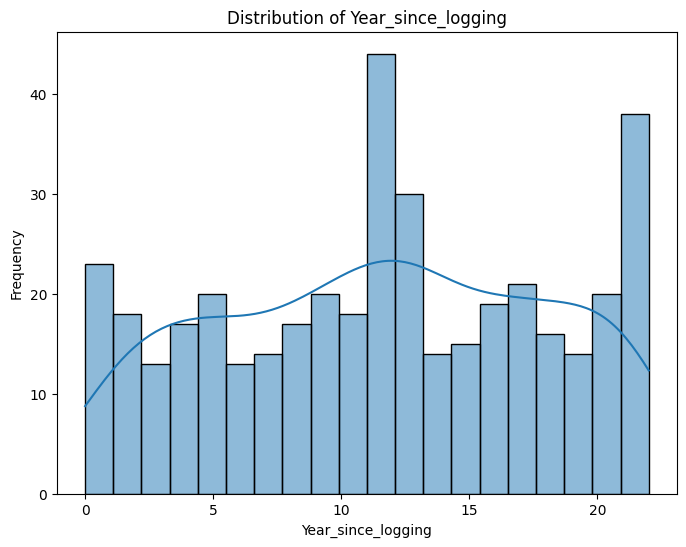

In [18]:
# Plot the distribution of Year_since_logging
plt.figure(figsize=(8, 6))
sns.histplot(harv_age['Year_since_logging'], kde=True, bins=20)
plt.title('Distribution of Year_since_logging')
plt.xlabel('Year_since_logging')
plt.ylabel('Frequency')
plt.savefig(os.path.join(predictive_check_path, "year_since_logging.png"))


#### B.1.b Covariate: forests

Text(0.5, 1.0, 'Square Root Transformation')

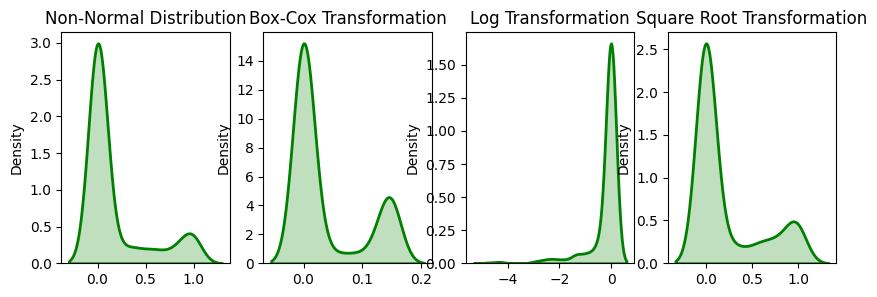

In [27]:
warnings.filterwarnings('ignore')
testing_with =percent_pine

fig, ax = plt.subplots(1, 4, figsize=(10,3))

sns.distplot(testing_with, hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
ax[0].set_title('Non-Normal Distribution')
 
sns.distplot(stats.boxcox([i+1 for i in testing_with])[0], hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
ax[1].set_title('Box-Cox Transformation')

sns.distplot([math.log(i, 10) if i != 0 else i for i in testing_with], hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[2])
ax[2].set_title('Log Transformation')

sns.distplot([math.sqrt(i) if i != 0 else i for i in testing_with], hist = False, kde = True,
            kde_kws = {'fill': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[3])
ax[3].set_title('Square Root Transformation')





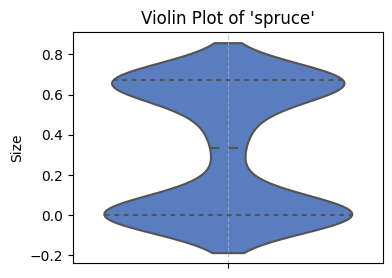

In [32]:
spruce_boxcox = stats.boxcox([i+1 for i in percent_spruce])[0]

plt.figure(figsize=(4,3))
sns.violinplot(y=spruce_boxcox, inner="quartile", palette="muted")
plt.title("Violin Plot of 'spruce'")
plt.ylabel("Size")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [34]:
smaller_patches = patch_size_lat_long_10vis[patch_size_lat_long_10vis['RETN_m2']> 0]

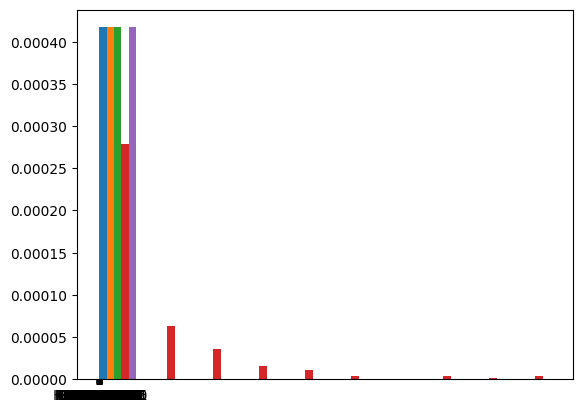

In [36]:
# patch_size_lat_long_10vis
ax =plt.hist(smaller_patches, density=True, bins=10)

### B.2 Response observations

#### B.2.a Count: Are the bird counts a Poisson?

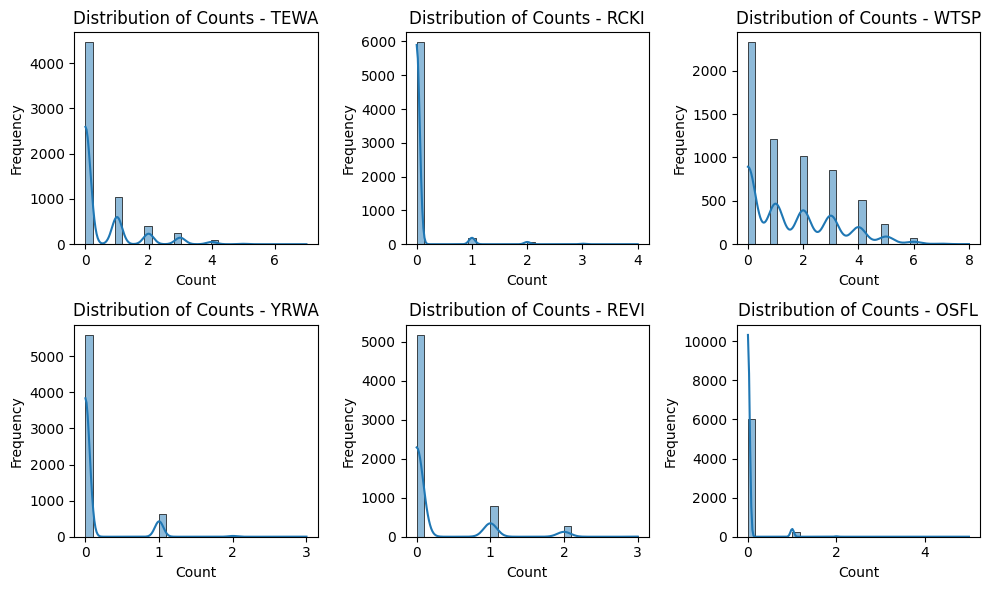

In [21]:
# Plot the distribution of counts for each bird species in subplots
plt.figure(figsize=(10, 6))

# List of bird species
bird_species = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.histplot(counts[species], kde=True, bins=30)
    plt.title(f'Distribution of Counts - {species}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(predictive_check_path, "count_distribution.png"))


This seems fairly zero-inflated!

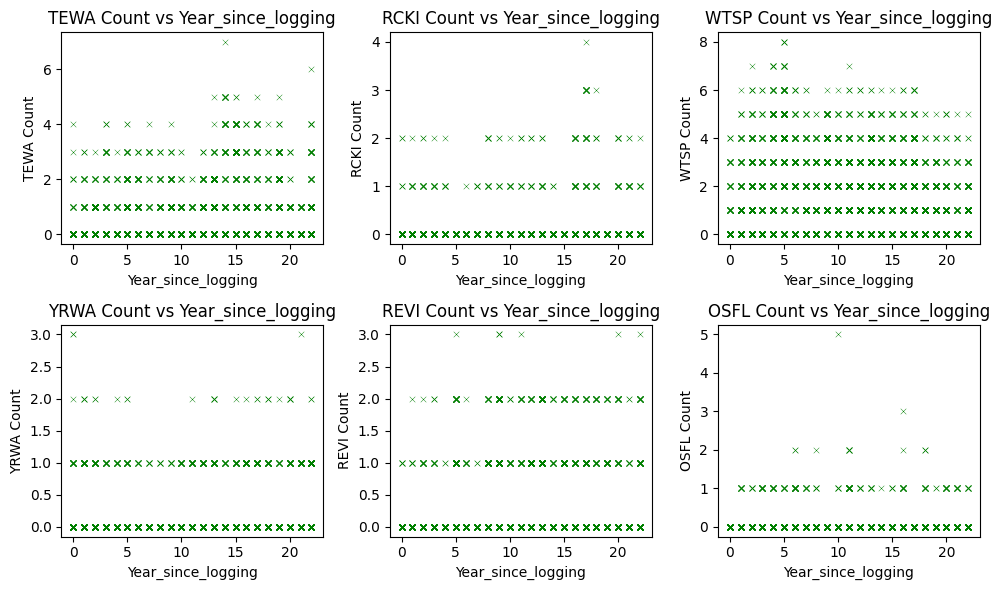

In [22]:
# Merge the two datasets on the 'location' column
merged_data = pd.merge(counts, harv_age, on='location')
# Plotting the total bird count against Year_since_logging for each species in subplots
plt.figure(figsize=(10, 6))

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=merged_data, x='Year_since_logging', y=species,  marker='x', color='green', s=16)
    plt.title(f'{species} Count vs Year_since_logging')
    plt.xlabel('Year_since_logging')
    plt.ylabel(f'{species} Count')

plt.tight_layout()
plt.savefig(os.path.join(predictive_check_path, "count_per_year.png"))


##### B.2.b Simulating count
First, let's simulate some counts from a Poisson process with lambdas generated from a Uniform distribution

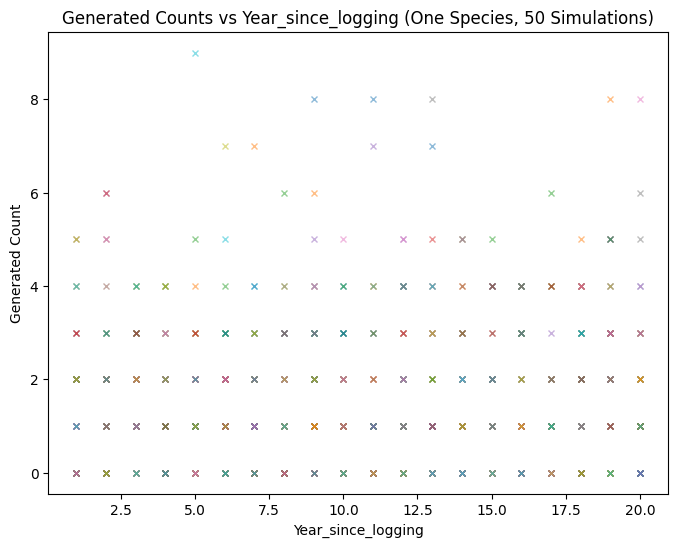

In [87]:
# Define unique years for simulation
unique_years = np.arange(1, 21)  # Adjust as per your data

# Number of simulations
n_simulations = 50

# Plotting the generated data for one species
plt.figure(figsize=(8, 6))

for i in range(n_simulations):
    # Simulating Poisson rates (lambdas) for one species from a uniform distribution between 0 and 8
    lambdas_simulated_one_species = np.random.uniform(low=0, high=3, size=len(unique_years))
    
    # Generating data by sampling from a Poisson distribution with the simulated lambdas
    generated_counts_one_species = np.random.poisson(lambdas_simulated_one_species)
    
    # Plotting the generated data for each simulation
    plt.plot(unique_years, generated_counts_one_species, marker='x', linestyle='', markersize=5, alpha=0.5)

plt.title('Generated Counts vs Year_since_logging (One Species, 50 Simulations)')
plt.xlabel('Year_since_logging')
plt.ylabel('Generated Count')
plt.show()


That looks pretty good. The sd on the lambdas ~ U(mean, sd) could change between species.<br>

Now, let's think about generating lambdas from slopes and intercepts.<br>
When using a log-link in a Poisson, the relationship between the predictors and the response variable is expressed on the log scale. The mean of the Poisson distribution ($\lambda$) is related to the predictoirs through:<br>
> log(lambda) = intercept + beta * covariate

1. Simulate intercepts and slopes. Lambda and intercept must be positive.
- simulate alpha from a log-normal
- simulate beta form a normal

2. Calculate lambda
- using the log-linear expression, doing some matrix algebra

3. Exponentiate lambda, so that it is always positive

4. Plots!




**Abundance integrated occupancy**

C:\Users\ilebe\AppData\Local\Temp\ipykernel_30728\3461955722.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


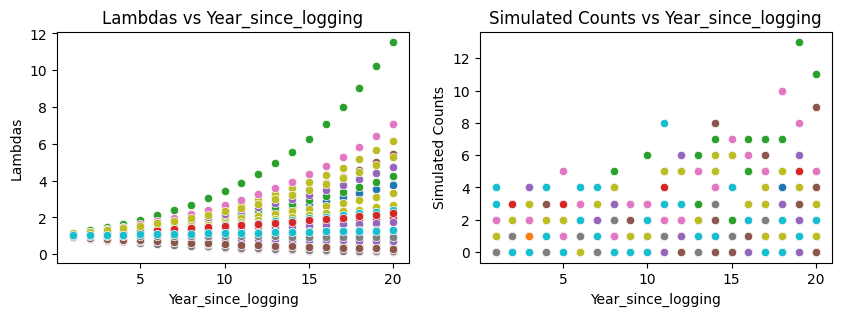

In [152]:
# Define unique years for simulation
unique_years = np.arange(1, 21)  # Adjust as per your data

# Number of simulations
n_simulations = 50

# Simulating intercepts (alpha) from a log-normal distribution
# alphas_simulated = np.random.lognormal(mean=0.04, sigma=0.001, size=n_simulations)

# can only be positve
alphas_simulated = np.random.exponential(scale=0.03, size=n_simulations)

# Simulating slopes (beta) from a normal distribution
betas_simulated = np.random.normal(loc=0, scale=0.05, size=n_simulations)

# Maximum allowable lambda value
max_lambda = 5  # Adjust this value based on your specific requirements

# Assume alphas_simulated and betas_simulated are column matrices and unique_years is a row array

# Reshape alphas_simulated and betas_simulated to column matrices
alphas_matrix = np.array(alphas_simulated).reshape(-1, 1)
betas_matrix = np.array(betas_simulated).reshape(-1, 1)

# Calculate lambda_matrix
lambda_matrix = np.exp(alphas_matrix + betas_matrix * unique_years)

# print(lambda_matrix)

fig, ax = plt.subplots(1, 2, figsize=(10,3))
# Plotting the simulated lambdas for each simulation

for i in range(n_simulations):
    sns.scatterplot(x=unique_years, y=lambda_matrix[i], ax= ax[0])

ax[0].set_title('Lambdas vs Year_since_logging')
ax[0].set_xlabel('Year_since_logging')
ax[0].set_ylabel('Lambdas')


# Store simulated counts
simulated_counts = {}

# Generating data by sampling from a Poisson distribution with the simulated lambdas
for i in range(n_simulations):
    counts = np.random.poisson(lambda_matrix[i])  
    simulated_counts[i] = counts
 

# Plotting the simulated counts for each simulation
for i in range(n_simulations):
    sns.scatterplot(x=unique_years, y=simulated_counts[i], ax=ax[1])

ax[1].set_title('Simulated Counts vs Year_since_logging')
ax[1].set_xlabel('Year_since_logging')
ax[1].set_ylabel('Simulated Counts')
fig.show()

These priors seem to make sense for species that have high counts, like the WTSP. They are too optimistic for some species where there are rarely more than 1 individual detected, like the YRWA.
> intercept ~ exp(0.03) <br>
> slope ~ normal(0, 0.5)

#### B.2.b Occurrence

In [24]:
# Merge the two datasets on the 'location' column
merged_data = pd.merge(counts, harv_age, on='location')
merged_age_size = pd.merge(merged_data, patch_size_lat_long, on='location')

occurrence_age_size = merged_age_size.copy(deep=True)
bird_species_columns = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Calculating the occurrence for each bird species and adding new columns to the DataFrame
for col in bird_species_columns:
    new_col = col + '_occurrence'
    merged_age_size[new_col] = (merged_age_size[col] > 0).astype(int)

occurrence_age_size[bird_species_columns] = merged_age_size[bird_species_columns].applymap(lambda x: 1 if x > 0 else 0)

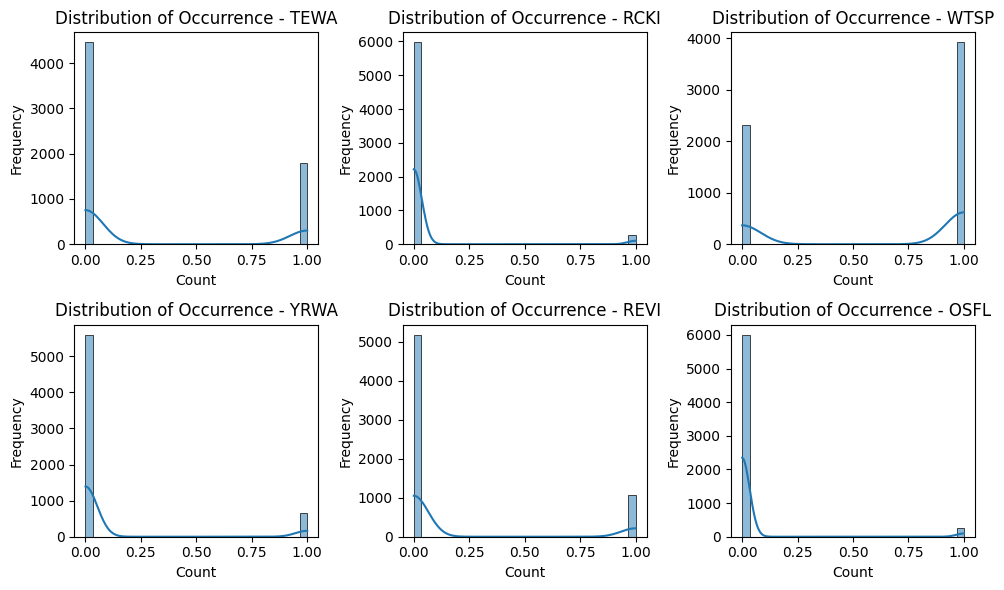

In [25]:
# Plot the distribution of counts for each bird species in subplots
plt.figure(figsize=(10, 6))

# List of bird species
bird_species = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.histplot(occurrence_age_size[species], kde=True, bins=30)
    plt.title(f'Distribution of Occurrence - {species}')
    plt.xlabel('Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(predictive_check_path, "occurrence_distribution.png"))


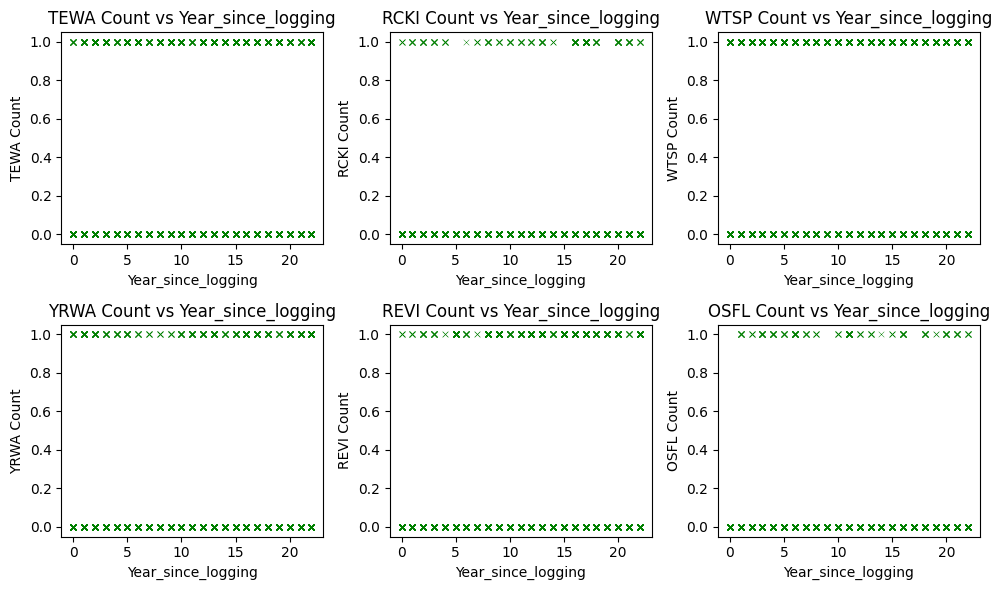

In [193]:

# Plotting the total bird count against Year_since_logging for each species in subplots
plt.figure(figsize=(10, 6))

for i, species in enumerate(bird_species):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=occurrence_age_size, x='Year_since_logging', y=species,  marker='x', color='green', s=16)
    plt.title(f'{species} Count vs Year_since_logging')
    plt.xlabel('Year_since_logging')
    plt.ylabel(f'{species} Count')

plt.tight_layout()
plt.show()


##### B.2.b Simulating occurrence

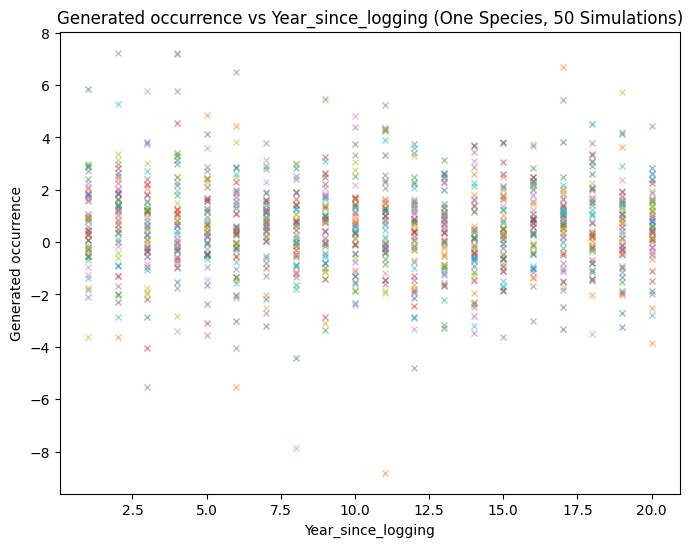

In [198]:
# Define unique years for simulation
unique_years = np.arange(1, 21)  # Adjust as per your data

# Number of simulations
n_simulations = 50

# Plotting the generated data for one species
plt.figure(figsize=(8, 6))

for i in range(n_simulations):
    # Simulating Poisson rates (lambdas) for one species from a uniform distribution between 0 and 8
    theta = np.random.beta(1, 1, size=len(unique_years))
    
    # Generating data by sampling from a Poisson distribution with the simulated lambdas
    generated_counts_one_species = np.random.logistic(theta)
    
    # Plotting the generated data for each simulation
    plt.plot(unique_years, generated_counts_one_species, marker='x', linestyle='', markersize=5, alpha=0.5)

plt.title('Generated occurrence vs Year_since_logging (One Species, 50 Simulations)')
plt.xlabel('Year_since_logging')
plt.ylabel('Generated occurrence')
plt.show()

## C. Models

### C.1 Poisson, age only

#### C.1.a Compile model

In [ ]:
poisson_model = CmdStanModel(stan_file=os.path.join(stan_path, "poisson.stan"))

#### C.1.b Sample

In [55]:
poissonModel_samples = poisson_model.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

15:28:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


15:28:26 - cmdstanpy - INFO - CmdStan done processing.


#### C.1.c Posteriors

In [60]:

# Extract inference data
Poisson_inference_data = az.from_cmdstanpy(
    posterior=poissonModel_samples, 
    posterior_predictive="M_pred",
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"]},
    log_likelihood="log_lik"
)

Poisson_inference_data.to_netcdf(os.path.join(idata_path, "Poisson.nc"))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\Poisson.nc'

In [22]:
# Load the InferenceData from the NetCDF file
Poisson_idata = az.from_netcdf(os.path.join(idata_path, "TEWA_Poisson.nc"))


In [23]:
Poisson_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

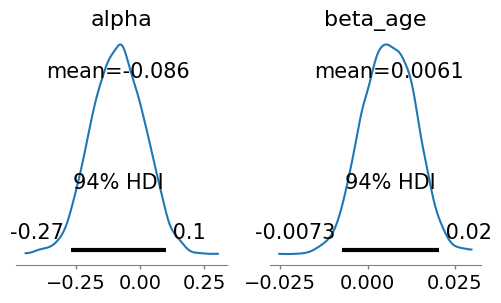

In [39]:
axes =  az.plot_posterior(poissonModel_samples, figsize=(6, 3), var_names=['alpha', 'beta_age'])

Age is almost positively consistently associated with abundance, but it does overlap 0. Need to look furhter.

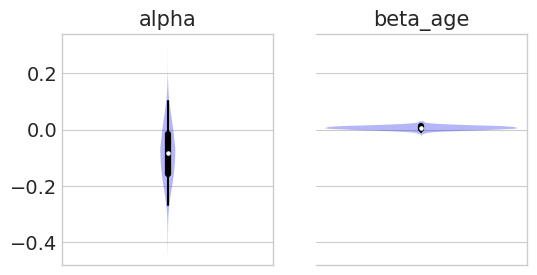

In [50]:
az.style.use("arviz-whitegrid")
# az.style.use("default")
axes =  az.plot_violin(poissonModel_samples,  figsize=(6, 3), var_names=['alpha', 'beta_age'])

In [86]:
predicted_values = Poisson_idata.posterior_predictive["M_pred"].values
len(predicted_values.flatten())

1580000

In [88]:
# # Extracting observed and predicted values from the InferenceData object
# observed_values = obs_and_covs_dict["M"]
# predicted_values = Poisson_idata.posterior_predictive["M_pred"].values


# # Correcting the extraction of predicted values
# # Averaging over all chains and samples to get a single prediction for each observation
# # mean_predicted_values = np.mean(predicted_values, axis=(0, 1))
# flat_pred_vals = predicted_values.flatten()
# # residuals = observed_values - flat_pred_vals

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Scatter Plot on ax1
# ax1.scatter(observed_values, flat_pred_vals, alpha=0.5)
# ax1.plot([min(observed_values), max(observed_values)], [min(observed_values), max(observed_values)], 'r--')
# ax1.set_xlabel('Observed Values')
# ax1.set_ylabel('Predicted Values')
# ax1.set_title('Scatter Plot of Observed vs. Predicted Values')
# ax1.grid(True)

# # Residual Plot on ax2
# # ax2.scatter(flat_pred_vals, residuals, alpha=0.5)
# # ax2.axhline(y=0, color='r', linestyle='--')
# # ax2.set_xlabel('Predicted Values')
# # ax2.set_ylabel('Residuals')
# # ax2.set_title('Residual Plot')
# # ax2.grid(True)

# plt.tight_layout()
# plt.show()


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_age'}>]], dtype=object)

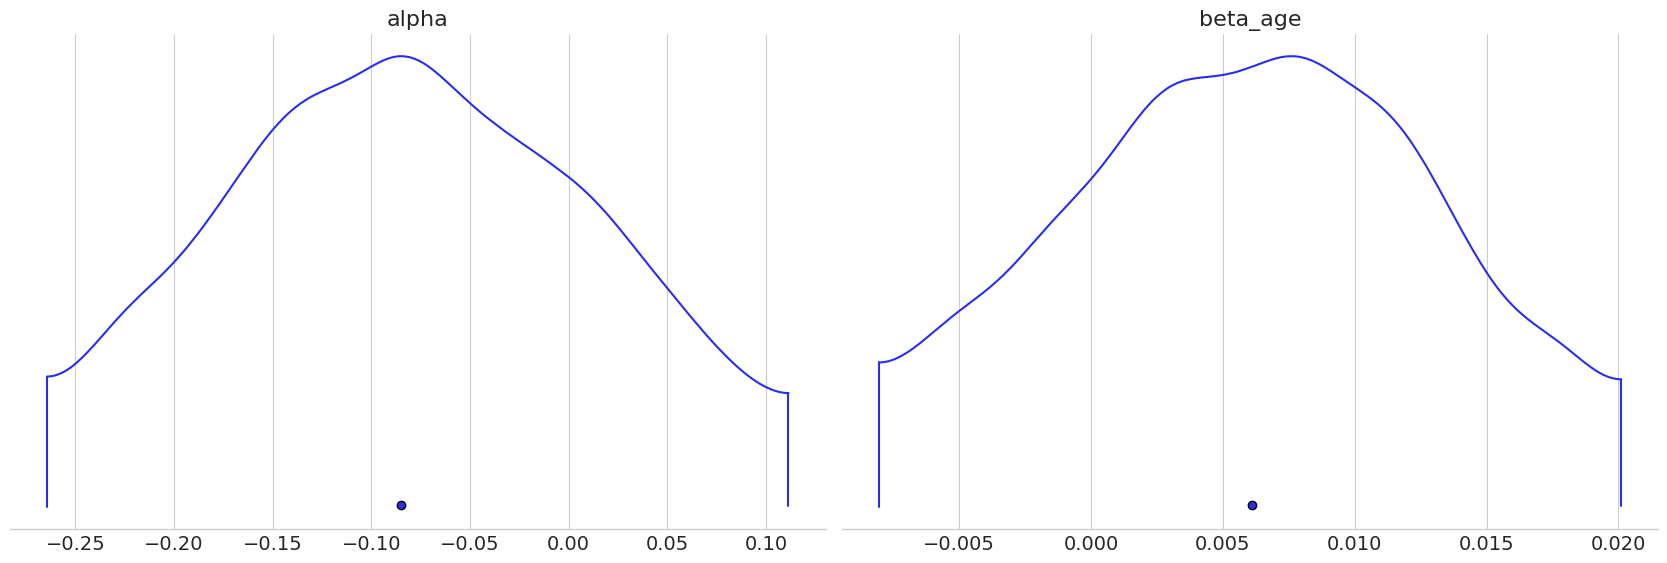

In [92]:
az.plot_density(poissonModel_samples, var_names=["alpha", "beta_age"])

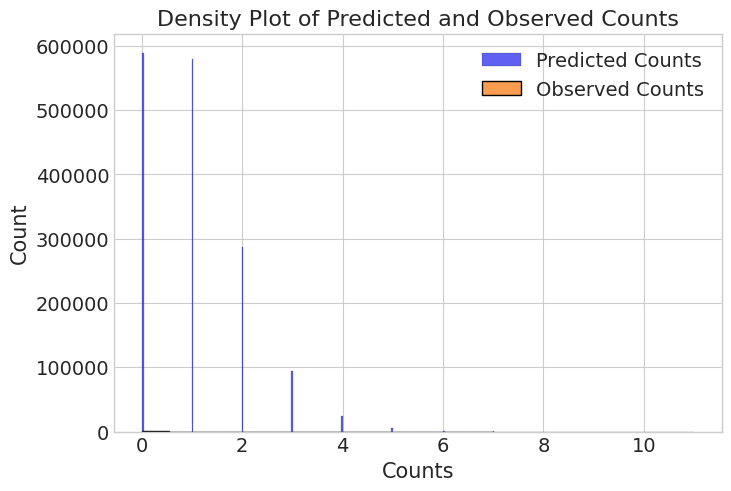

In [78]:
predicted_counts = poissonModel_samples.stan_variable('M_pred')
# Assuming obs_and_covs_dict contains 'M' as observed counts
observed_counts = obs_and_covs_dict['M']

# Plotting kernel density estimates of predicted and observed counts
sns.histplot(predicted_counts.flatten(), fill=True, label='Predicted Counts')
sns.histplot(observed_counts, fill=True, label='Observed Counts')
plt.title('Hist Plot of Predicted and Observed Counts')
plt.xlabel('Counts')
plt.legend()
plt.show()


### C.2 Poisson with age and size
Remember, size is transformed as log(size)

In [18]:
poisson_age_size_mod = CmdStanModel(stan_file=os.path.join(stan_path, "poisson.stan"))

09:22:12 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\poisson.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\poisson.exe
09:22:59 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\poisson.exe
09:22:59 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
09:22:59 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/poisson.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/poisson.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/poisson.stan', line 34, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Ins

#### C.2.b Sample

In [19]:
poisson_age_size_samples = poisson_age_size_mod.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

09:23:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


09:23:06 - cmdstanpy - INFO - CmdStan done processing.


#### C.2.c Posteriors

In [20]:

# Extract inference data
Poisson_inference_data = az.from_cmdstanpy(
    posterior=poisson_age_size_samples, 
    posterior_predictive="M_pred",
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], "size" : obs_and_covs_dict['size']},
    log_likelihood="log_lik"
)

Poisson_inference_data.to_netcdf(os.path.join(idata_path, "Poisson_age_size.nc"))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\Poisson_age_size.nc'

In [21]:
Poisson_idata = az.from_netcdf(os.path.join(idata_path, "Poisson_age_size.nc"))
Poisson_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

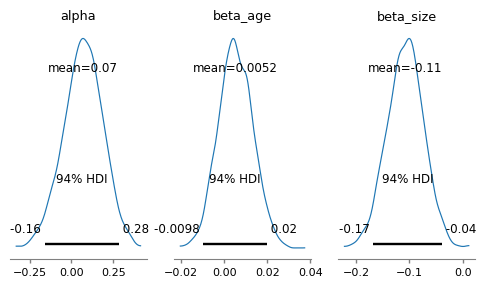

In [29]:
axes =  az.plot_posterior(Poisson_idata,
                           var_names=['alpha', 'beta_age', 'beta_size'], 
                           figsize=(6, 3),
                           textsize=8)

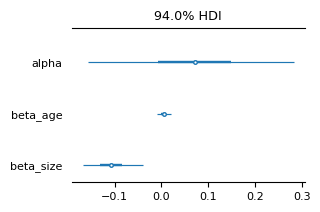

In [32]:
az.plot_forest(Poisson_idata, 
               var_names=['alpha', 'beta_age', 'beta_size'], 
               combined=True,
                 figsize=(3, 2 ), textsize=8);

### C.2.2 Poisson with age and size interaction
Remember, size is transformed as log(size)
In order to include the 

In [94]:
test_interaction_in_ZIP = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_with_interaction.stan"))

13:38:08 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_with_interaction.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_with_interaction.exe


13:38:30 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_with_interaction.exe


In [95]:
test_interaction_in_ZIP_samples =  test_interaction_in_ZIP.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

13:39:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |████████▏ | 00:03 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |██████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)























13:39:21 - cmdstanpy - INFO - CmdStan done processing.


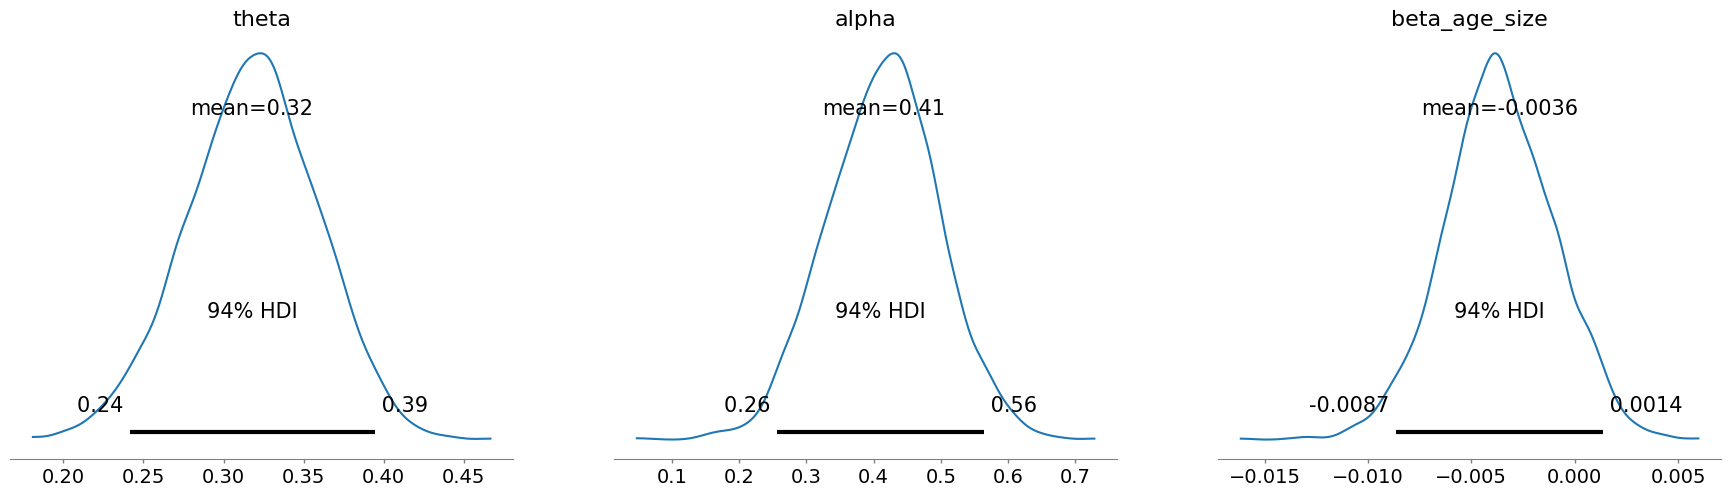

In [96]:
axes =  az.plot_posterior(test_interaction_in_ZIP_samples)

### C.2 Logistic regression: occupancy

In [25]:
Logistic_regression_Model = CmdStanModel(stan_file=os.path.join(stan_path, "logistic_occupancy.stan"))

In [41]:
output_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\Outputs\CSV\Occupancy Test"
Logistic_regression_Model_samples =  Logistic_regression_Model.sample(
                                                        data=obs_and_covs_dict,
                                                        parallel_chains=4,
                                                        show_console=False,
                                                        output_dir = output_path)

10:41:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


10:41:18 - cmdstanpy - INFO - CmdStan done processing.


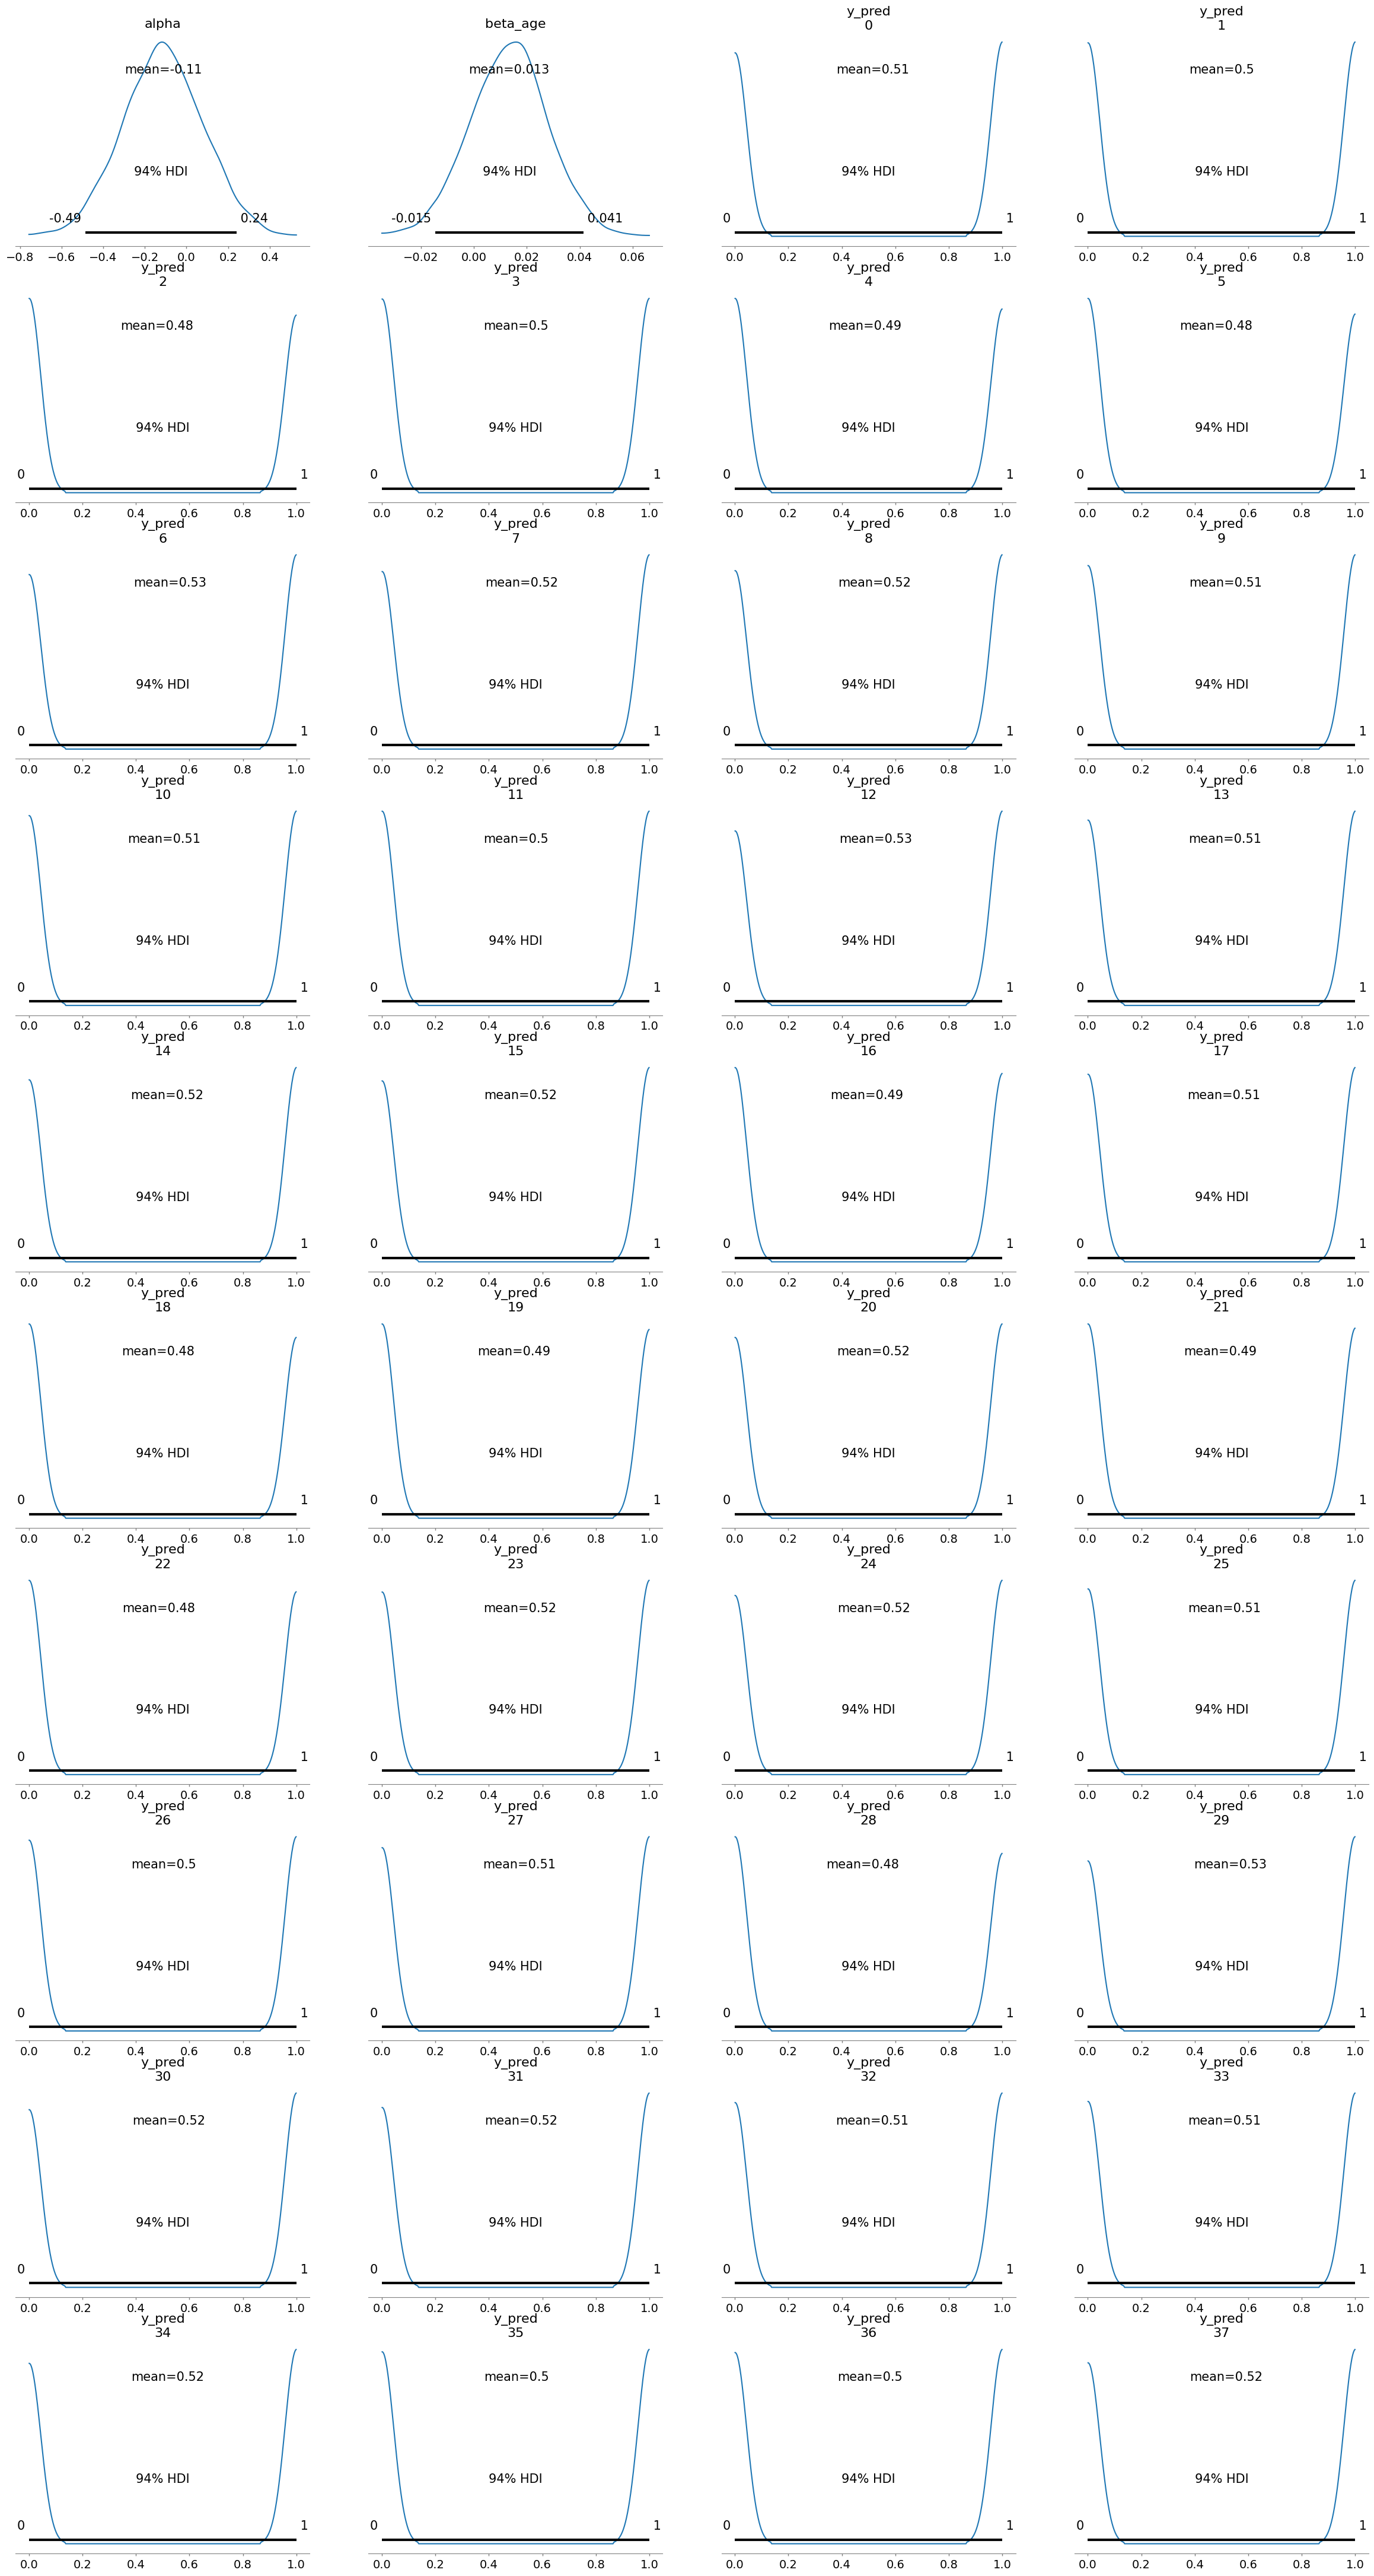

In [207]:
axes =  az.plot_posterior(Logistic_regression_Model_samples)

### C.2 Occupancy, no detection

In [211]:
occupancy_no_detectModel = CmdStanModel(stan_file=os.path.join(stan_path, "just_occupancy_no_detection.stan"))

20:46:28 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\just_occupancy_no_detection.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\just_occupancy_no_detection.exe
20:46:53 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\just_occupancy_no_detection.exe


In [215]:
occupancy_no_detect_samples = occupancy_no_detectModel.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

20:48:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00


20:48:53 - cmdstanpy - INFO - CmdStan done processing.


### C.3 Full Model: detection, occupancy, abundance

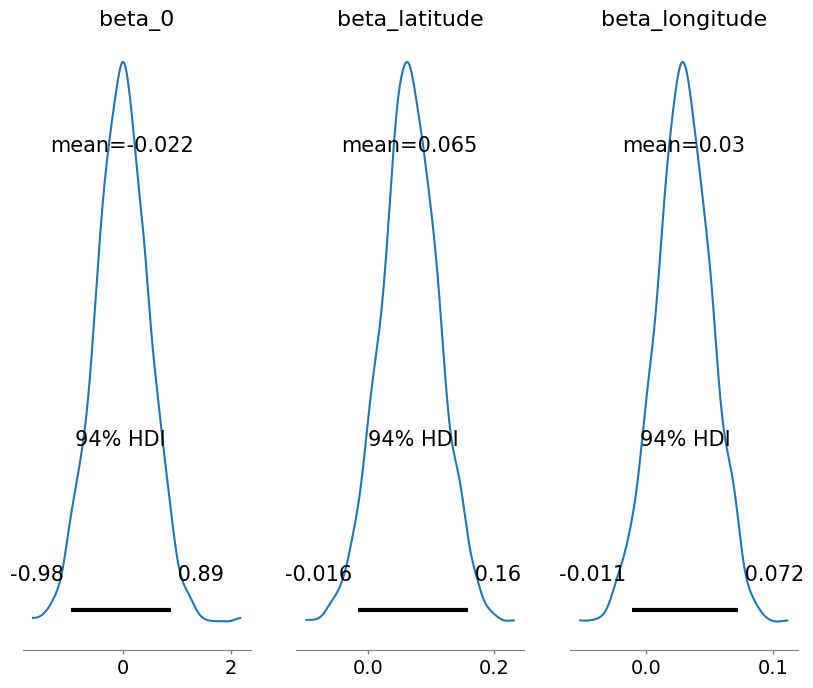

In [217]:
axes =  az.plot_posterior(occupancy_no_detect_samples, var_names = ['beta_0', 'beta_latitude', 'beta_longitude'],  figsize=(10, 8))

### C.4 Occupancy with detection

In [73]:
occupancy_with_detectModel = CmdStanModel(stan_file=os.path.join(stan_path, "occupancy_with_detection.stan"))


16:43:52 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\occupancy_with_detection.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\occupancy_with_detection.exe
16:44:15 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\occupancy_with_detection.exe
16:44:15 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
16:44:15 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/occupancy_with_detection.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/occupancy_with_detection.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/occupancy_with_detection.stan', line 6, column 2: Declaration
    of array

In [74]:
occupancy_with_detect_samples = occupancy_with_detectModel.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=True)

16:44:23 - cmdstanpy - INFO - Chain [1] start processing
16:44:23 - cmdstanpy - INFO - Chain [2] start processing
16:44:23 - cmdstanpy - INFO - Chain [3] start processing
16:44:23 - cmdstanpy - INFO - Chain [4] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\ilebe\AppData\Local\Temp\tmphwx7k5n7\rvirh062.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed 

16:44:57 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [2] 
Chain [2] Elapsed Time: 20.162 seconds (Warm-up)
Chain [2] 13.117 seconds (Sampling)
Chain [2] 33.279 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain

16:45:14 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [4] 
Chain [4] Elapsed Time: 23.478 seconds (Warm-up)
Chain [4] 26.949 seconds (Sampling)
Chain [4] 50.427 seconds (Total)
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 


16:45:15 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 23.822 seconds (Warm-up)
Chain [1] 27.472 seconds (Sampling)
Chain [1] 51.294 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain

16:55:22 - cmdstanpy - INFO - Chain [3] done processing


Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)
Chain [3] 
Chain [3] Elapsed Time: 22.194 seconds (Warm-up)
Chain [3] 636.128 seconds (Sampling)
Chain [3] 658.322 seconds (Total)
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Cha

16:55:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 999 divergent transitions (99.9%)
	Chain 2 had 999 divergent transitions (99.9%)
	Chain 3 had 976 divergent transitions (97.6%)
	Chain 3 had 24 iterations at max treedepth (2.4%)
	Chain 4 had 1000 divergent transitions (100.0%)
	Use function "diagnose()" to see further information.


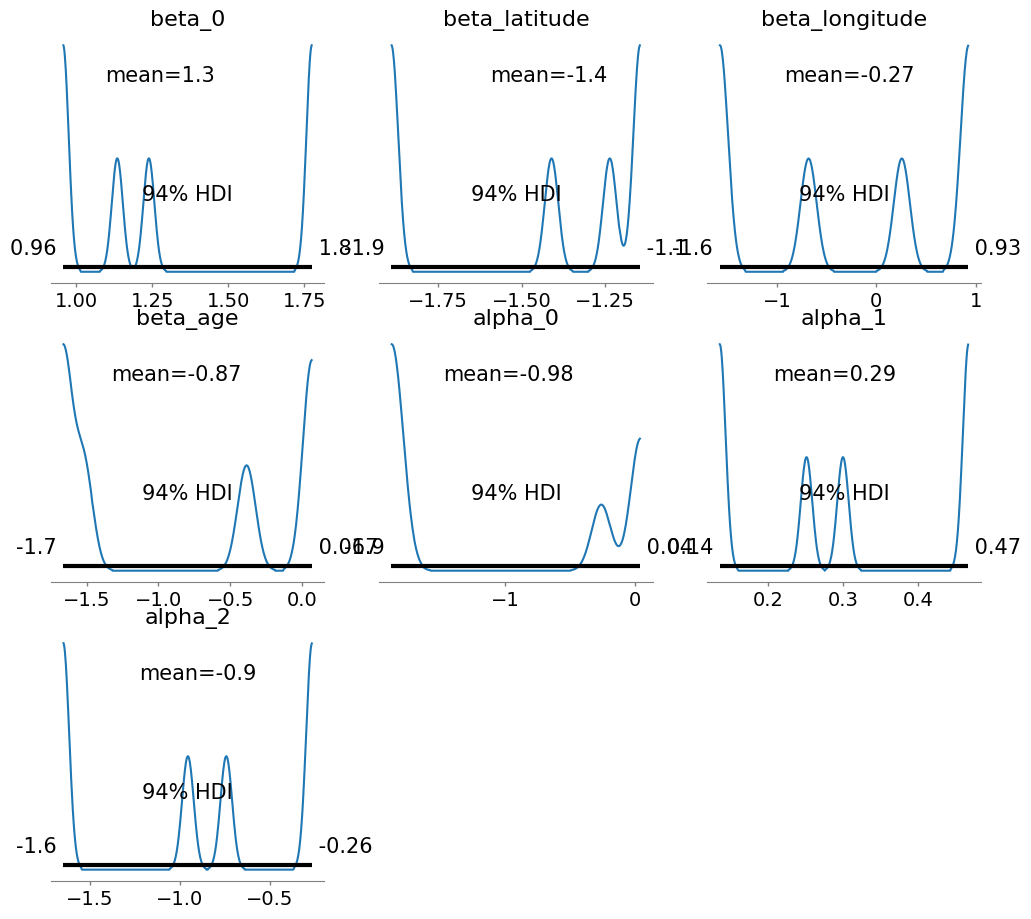

In [80]:
axes =  az.plot_posterior(occupancy_with_detect_samples, figsize=(12, 11))

### C.4 Abundance

#### C.4.1 Load Zip model
This version is not vectorized

Theta is the probability of occupancy (probability that an observation belongs to the "structural zeros" class)

In [56]:

abundance_onlyModel = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_abundance.stan"))

16:17:17 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_only.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_only.exe
16:17:41 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\abundance_only.exe
16:17:41 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
16:17:41 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_only.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_only.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/abundance_only.stan', line 70, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated a

In [54]:

abundance_only_samples = abundance_onlyModel.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)


16:13:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |▉         | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:03 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:03 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:04 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)



16:13:20 - cmdstanpy - INFO - CmdStan done processing.


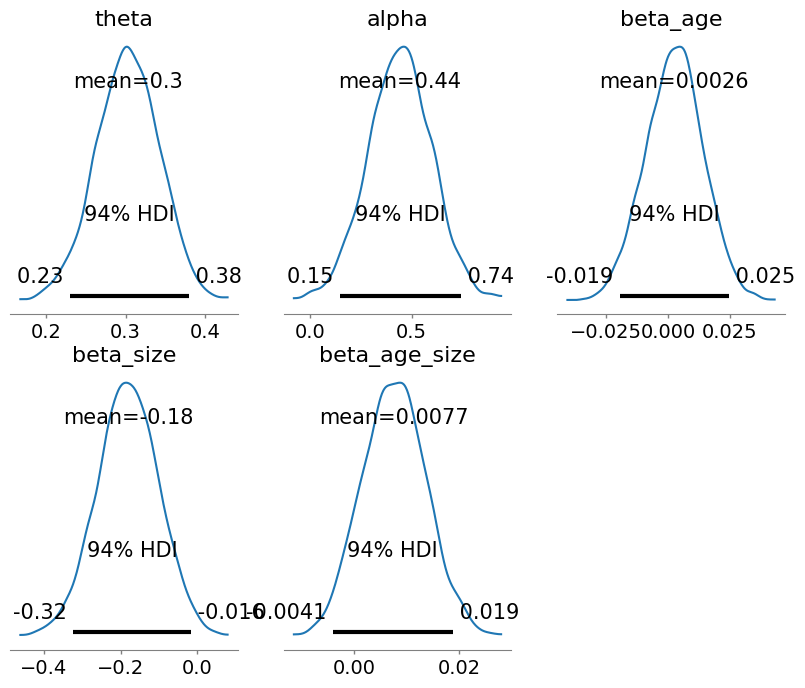

In [30]:
axes =  az.plot_posterior(abundance_only_samples, figsize=(10, 8))

In [50]:
abundance_only_samples.summary()

Mean      MCSE    StdDev          5%         50%   
lp__          -538.574000  0.044230  1.601030 -541.651000 -538.251000  \
theta            0.302698  0.000960  0.039850    0.235826    0.302762   
alpha            0.442020  0.004340  0.157578    0.179518    0.444111   
beta_age         0.002572  0.000328  0.011757   -0.017023    0.002738   
beta_size       -0.180921  0.002214  0.081450   -0.315322   -0.180666   
beta_age_size    0.007653  0.000167  0.006092   -0.002355    0.007639   

                      95%    N_Eff   N_Eff/s    R_hat  
lp__          -536.645000  1310.27   81.1060  1.00134  
theta            0.367227  1723.42  106.6800  1.00146  
alpha            0.699453  1318.25   81.6002  1.00195  
beta_age         0.021736  1283.68   79.4604  1.00164  
beta_size       -0.047701  1353.58   83.7873  0.99983  
beta_age_size    0.017824  1331.82   82.4400  1.00003

In [51]:
abundance_only_samples.draws_pd()

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__   
0    -537.238       0.975980    0.162396          4.0          23.0  \
1    -538.274       0.965023    0.162396          4.0          15.0   
2    -536.460       0.977008    0.162396          4.0          15.0   
3    -536.671       0.776341    0.162396          4.0          15.0   
4    -537.596       0.963559    0.162396          5.0          31.0   
...       ...            ...         ...          ...           ...   
3995 -539.449       0.960941    0.183958          4.0          31.0   
3996 -541.089       0.986015    0.183958          3.0           7.0   
3997 -540.433       0.999204    0.183958          4.0          15.0   
3998 -540.375       0.992002    0.183958          4.0          31.0   
3999 -538.465       0.991536    0.183958          4.0          15.0   

      divergent__  energy__     theta     alpha  beta_age  beta_size   
0             0.0   542.763  0.279134  0.408669  0.001498  -0.137332  \
1             0.0   540.432  0.302052  0.459347  0.009994  -0.277452   
2             0.0   540.335  0.288477  0.479485  0.002171  -0.207162   
3             0.0   544.240  0.326938  0.464968  0.004657  -0.122702   
4             0.0   537.936  0.302088  0.233296  0.020049  -0.127807   
...           ...       ...       ...       ...       ...        ...   
3995          0.0   542.386  0.253103  0.639480 -0.009270  -0.363250   
3996          0.0   541.870  0.241224  0.650934 -0.010582  -0.411378   
3997          0.0   542.133  0.243853  0.668911 -0.013003  -0.396668   
3998          0.0   543.148  0.213228  0.455669 -0.007613  -0.308288   
3999          0.0   541.887  0.225724  0.524309 -0.007445  -0.250144   

      beta_age_size  
0          0.007499  
1          0.011649  
2          0.009564  
3          0.002754  
4          0.004503  
...             ...  
3995       0.019055  
3996       0.021154  
3997       0.021035  
3998       0.018877  
3999       0.011511  

[4000 rows x 12 columns]

In [59]:
# Extracting the predicted counts from the samples
predicted_counts = abundance_only_samples.stan_variable('predicted_counts')
type(predicted_counts)

numpy.ndarray

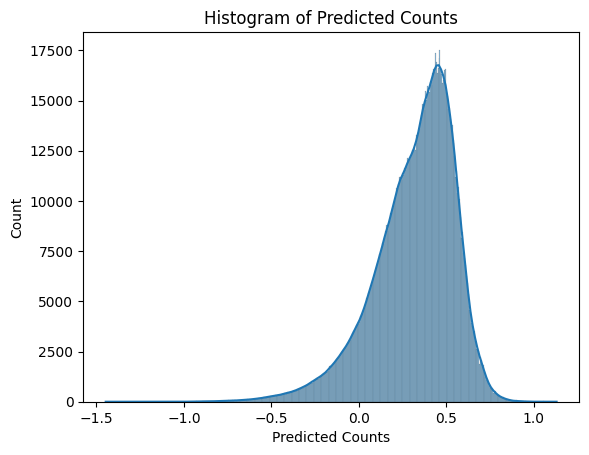

In [60]:

# Plotting histogram of predicted counts
sns.histplot(predicted_counts.flatten(), kde=True)
plt.title('Histogram of Predicted Counts')
plt.xlabel('Predicted Counts')
plt.show()

This model does a very bad job at predicting the counts, looking at the difference in the observed and predicted counts.

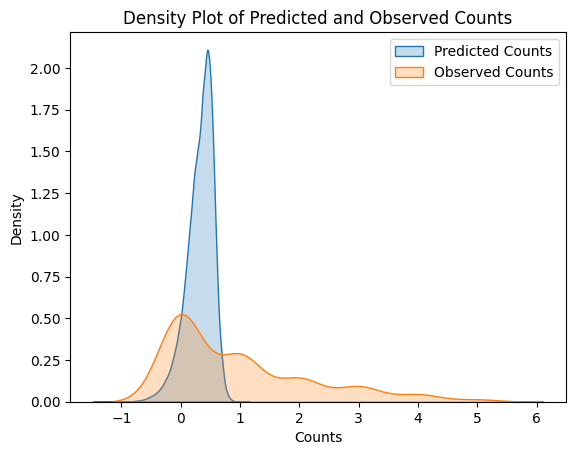

In [61]:
# Assuming obs_and_covs_dict contains 'M' as observed counts
observed_counts = obs_and_covs_dict['M']

# Plotting kernel density estimates of predicted and observed counts
sns.kdeplot(predicted_counts.flatten(), fill=True, label='Predicted Counts')
sns.kdeplot(observed_counts, fill=True, label='Observed Counts')
plt.title('Density Plot of Predicted and Observed Counts')
plt.xlabel('Counts')
plt.legend()
plt.show()


In [66]:
obs_and_covs_dict.keys()

dict_keys(['I', 'J', 'N', 'y', 'M', 'latitude', 'longitude', 'percent_conifer', 'percent_deciduous', 'percent_pine', 'size', 'age', 'time_of_day', 'Julian_date'])

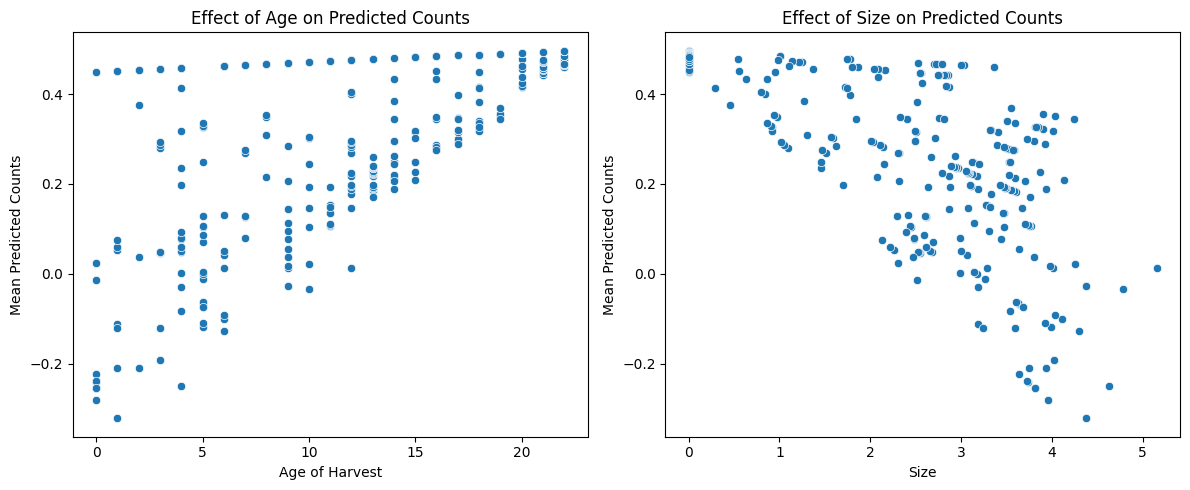

In [72]:

# Create a figure with 3 subplots: 1 row, 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
mean_predicted_counts = np.mean(predicted_counts, axis=0)
age_of_harv = obs_and_covs_dict['age']
size = obs_and_covs_dict['size']
# Plot 1: Effect of age_of_harv on mean_predicted_counts
sns.scatterplot(x=age_of_harv, y=mean_predicted_counts, ax=axes[0])
axes[0].set_title('Effect of Age on Predicted Counts')
axes[0].set_xlabel('Age of Harvest')
axes[0].set_ylabel('Mean Predicted Counts')

# Plot 2: Effect of size on mean_predicted_counts
sns.scatterplot(x=size, y=mean_predicted_counts, ax=axes[1])
axes[1].set_title('Effect of Size on Predicted Counts')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('Mean Predicted Counts')

# Display the plots
plt.tight_layout()
plt.show()


In [44]:
# Generate a range of age values
age_values = np.linspace(0, 22, 100)

# Calculate the predicted abundance for each age value and each sample from the posterior
predicted_abundance = np.exp(
    abundance_only_samples.alpha +
    abundance_only_samples.beta_age * age_values[:, None, None]
    # add other terms as necessary, using fixed values for other variables
)

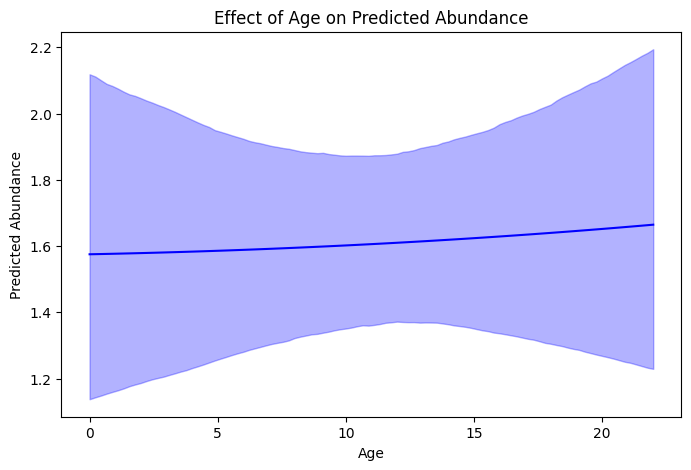

In [42]:
# Calculate summary statistics
mean_predicted_abundance = np.mean(predicted_abundance, axis=-1)
lower_bound = np.squeeze(np.percentile(predicted_abundance, 2.5, axis=-1))
upper_bound = np.squeeze(np.percentile(predicted_abundance, 97.5, axis=-1))

# Plot the predictions
plt.figure(figsize=(8, 5))
plt.plot(age_values, mean_predicted_abundance, color='blue')
plt.fill_between(age_values, lower_bound, upper_bound, color='blue', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Predicted Abundance')
plt.title('Effect of Age on Predicted Abundance')
plt.show()


### C.4.2 ZIP with generated quantities

This could be one version of the generated quantiteis block:
/*
generated quantities {
    real predicted_counts[I];

    // you don't have to give priors or declare lambda_pred or theta_pred

    have to recalcuta lambda[i]
    then simulate presence/absence, for all the 1,s simualte abundance
    

    vector[I] lambda = exp(alpha + beta_age * age + beta_size * size + beta_age_size * age * size );
for loop that simulates 0 and 1 as a vernoulli with theta 
there is the proba that bird is absent
    // this is from the user guide
    for (i in 1:I) {

        predicted_counts[i] = alpha + beta_age * age[i] + beta_size * size[i] + beta_age_size * age[i] * size[i];
    }
}
*/

In [77]:
ZIP_gen_quants_ll = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_abundance.stan"))

12:27:14 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.exe
12:27:40 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.exe
12:27:40 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
12:27:40 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.stan', line 56, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
   

In [78]:
ZIP_gen_quants_samples_ll = ZIP_gen_quants_ll.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

12:27:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status




chain 1 |▉         | 00:04 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 02:15 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 04:47 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 05:43 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 06:21 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 07:26 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 07:53 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 08:15 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 08:47 Iteration: 1000 / 2000 [ 50%]  (Warmup)




chain 1 |█████▉    | 09:13 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 09:40 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 10:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 10:34 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 10:59 Iteration: 1400 / 2000 [ 70%]  (


12:43:20 - cmdstanpy - INFO - CmdStan done processing.


In [82]:
# Extract inference data
ZIP_gen_quant_idata = az.from_cmdstanpy(
    posterior=ZIP_gen_quants_samples_ll, 
    posterior_predictive=["M_pred", "lambda_rep"],
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], "size" : obs_and_covs_dict['size']},
    log_likelihood="log_lik"
)

ZIP_gen_quant_idata.to_netcdf(os.path.join(idata_path, "ZIP_age_size.nc"))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\ZIP_age_size.nc'

In [81]:
ZIP_gen_quant_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

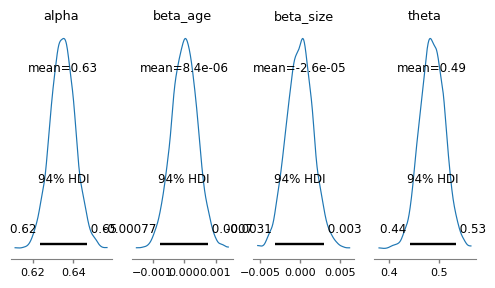

In [84]:
axes = az.plot_posterior(ZIP_gen_quant_idata,
                           var_names=['alpha', 'beta_age', 'beta_size', 'theta'], 
                           figsize=(6, 3),
                           textsize=8)

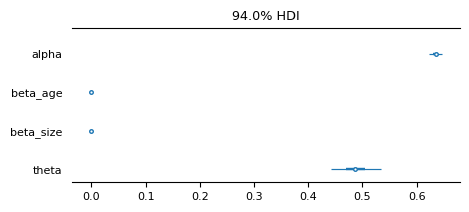

In [87]:
az.plot_forest(ZIP_gen_quant_idata, 
               var_names=['alpha', 'beta_age', 'beta_size', 'theta'], 
               combined=True,
                 figsize=(5, 2), textsize=8);

In [88]:
az.summary(ZIP_gen_quant_idata, 
               var_names=['alpha', 'beta_age', 'beta_size', 'theta'], )

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
alpha      0.635  0.006   0.624    0.647      0.000      0.0    2390.0  \
beta_age   0.000  0.000  -0.001    0.001      0.000      0.0    2999.0   
beta_size -0.000  0.002  -0.003    0.003      0.000      0.0    3253.0   
theta      0.487  0.025   0.442    0.535      0.001      0.0    2314.0   

           ess_tail  r_hat  
alpha        2318.0    1.0  
beta_age     2964.0    1.0  
beta_size    2789.0    1.0  
theta        2234.0    1.0

In [89]:
az.waic(ZIP_gen_quant_idata)

c:\Users\ilebe\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 395 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -829.72     0.71
p_waic      393.71        -

There has been a warning during the calculation. Please check the results.

In [69]:
ZIP_gen_quants = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_abundance.stan"))

11:07:58 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.exe
11:08:50 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.exe
11:08:50 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
11:08:50 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.stan', line 56, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
   

#### C.4.2.b sample model

In [ ]:
ZIP_gen_quants_samples = ZIP_gen_quants.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)


11:08:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |▉         | 01:55 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 03:39 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 05:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 05:40 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 06:28 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 07:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 07:34 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 08:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 08:33 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████▍    | 09:02 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 09:28 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 09:54 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 10:22 Iteration: 


11:23:27 - cmdstanpy - INFO - CmdStan done processing.


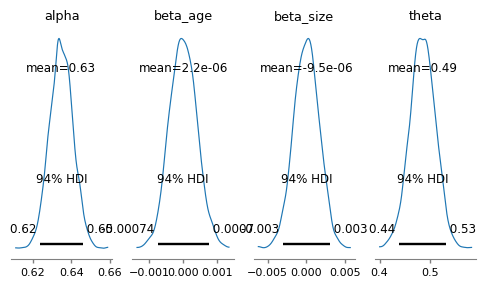

In [ ]:
axes =  az.plot_posterior(ZIP_gen_quants_samples_ll,
                           var_names=['alpha', 'beta_age', 'beta_size', 'theta'], 
                           figsize=(6, 3),
                           textsize=8)

#### C.2.4.c Posteriors and save inference data

In [ ]:
# Extract inference data
ZIP_gen_quant_idata = az.from_cmdstanpy(
    posterior=ZIP_gen_quants_samples, 
    posterior_predictive=["M_pred", "generated_lambda"],
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], "size" : obs_and_covs_dict['size']},
    log_likelihood="log_lik"
)

Poisson_inference_data.to_netcdf(os.path.join(idata_path, "Poisson_age_size.nc"))

### C.4.2 ZIP with generated quantities and interaction term

In [97]:
ZIP_gen_quants_ll_interaction = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_abundance.stan"))

13:51:21 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.exe
13:51:45 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_abundance.exe
13:51:45 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
13:51:45 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_abundance.stan', line 66, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
   

In [98]:
ZIP_gen_quants_ll_interaction_samples_ll = ZIP_gen_quants_ll_interaction.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

13:52:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)












chain 1 |█▊        | 00:04 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:05 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:06 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 00:06 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:06 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:07 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:07 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:07 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:08 Iteration: 1300 / 2000 [ 65%]  (Sampling)


13:52:30 - cmdstanpy - INFO - CmdStan done processing.


In [101]:
# Extract inference data
ZIP_interaction_idata = az.from_cmdstanpy(
    posterior=ZIP_gen_quants_ll_interaction_samples_ll, 
    posterior_predictive=["M_pred", "lambda_rep"],
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], "size" : obs_and_covs_dict['size']},
    log_likelihood="log_lik"
)
ZIP_interaction_idata.to_netcdf(os.path.join(idata_path, "ZIP_age_size_interaction.nc"))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\ZIP_age_size_interaction.nc'

In [100]:
ZIP_interaction_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

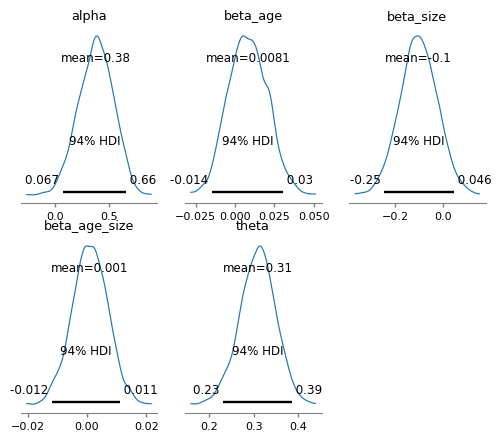

In [105]:
axes = az.plot_posterior(ZIP_interaction_idata,
                           var_names=['alpha', 'beta_age', 'beta_size', 'beta_age_size', 'theta'], 
                           figsize=(6, 5),
                           textsize=8)

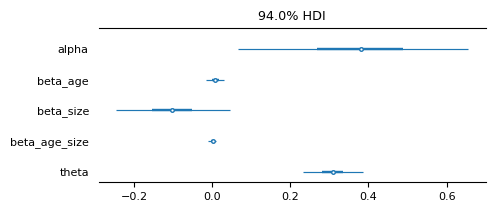

In [106]:
az.plot_forest(ZIP_interaction_idata, 
               var_names=['alpha', 'beta_age', 'beta_size', 'beta_age_size', 'theta'], 
               combined=True,
                 figsize=(5, 2), textsize=8);

In [107]:
az.summary(ZIP_interaction_idata, 
               var_names=['alpha', 'beta_age', 'beta_size', 'beta_age_size', 'theta'], )

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
alpha          0.376  0.159   0.067    0.656      0.004    0.003    1258.0  \
beta_age       0.008  0.012  -0.014    0.030      0.000    0.000    1307.0   
beta_size     -0.102  0.077  -0.245    0.046      0.002    0.002    1262.0   
beta_age_size  0.001  0.006  -0.012    0.011      0.000    0.000    1327.0   
theta          0.308  0.041   0.231    0.387      0.001    0.001    2359.0   

               ess_tail  r_hat  
alpha            1749.0    1.0  
beta_age         2023.0    1.0  
beta_size        1917.0    1.0  
beta_age_size    2093.0    1.0  
theta            1628.0    1.0

In [108]:
az.waic(ZIP_interaction_idata)

c:\Users\ilebe\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 395 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -739.80     1.73
p_waic      227.57        -

There has been a warning during the calculation. Please check the results.

#### C.4.2.b sample model

In [70]:
ZIP_gen_quants_samples = ZIP_gen_quants.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)


11:08:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status



chain 1 |▉         | 01:55 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 03:39 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 05:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 05:40 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 06:28 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 07:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 07:34 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 08:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 08:33 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████▍    | 09:02 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 09:28 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 09:54 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 10:22 Iteration: 


11:23:27 - cmdstanpy - INFO - CmdStan done processing.


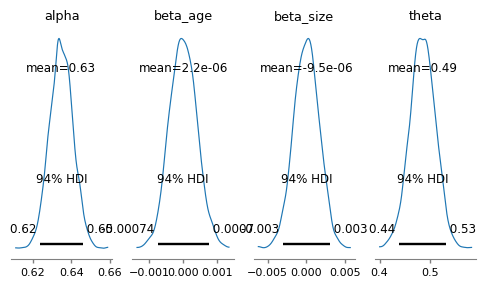

In [74]:
axes =  az.plot_posterior(ZIP_gen_quants_samples_ll,
                           var_names=['alpha', 'beta_age', 'beta_size', 'theta'], 
                           figsize=(6, 3),
                           textsize=8)

#### C.2.4.c Posteriors and save inference data

In [ ]:
# Extract inference data
ZIP_gen_quant_idata = az.from_cmdstanpy(
    posterior=ZIP_gen_quants_samples, 
    posterior_predictive=["M_pred", "generated_lambda"],
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], "size" : obs_and_covs_dict['size']},
    log_likelihood="log_lik"
)

Poisson_inference_data.to_netcdf(os.path.join(idata_path, "Poisson_age_size.nc"))

### C.6 ZIP and adding linear predictor to occupancy

In [102]:
ZIP_linear_occupancy_REVI = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_predicted_occ.stan"))

In [103]:
REVI_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\Outputs\CSV\REVI_max"
ZIP_REVI_max = ZIP_linear_occupancy_REVI.sample(
    data=obs_and_covs_dict,
    parallel_chains=4,
    show_console=False,
    output_dir=REVI_path)

12:55:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▍         | 00:00 Status
chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:11 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:44 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 04:18 Iteration:  400 / 2000 [ 20%]  (Warmup)






chain 1 |███▏      | 10:20 Iteration:  500 / 2000 [ 25%]  (Warmup)















chain 1 |███▋      | 16:41 Iteration:  600 / 2000 [ 30%]  (Warmup)













chain 1 |████      | 23:30 Iteration:  700 / 2000 [ 35%]  (Warmup)









chain 1 |████▌     | 29:27 Iteration:  800 / 2000 [ 40%]  (Warmup)





chain 1 |█████▍    | 34:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |██████████| 1:18:10 Sampling completed                       
chain 2 |██████████| 1:18:10 Sampling completed                       
chain 3 |██████████| 1:18:10 Sampling completed                     
chain 4 |██████████| 1:18:10 Sampling completed                     


14:13:59 - cmdstanpy - INFO - CmdStan done processing.


14:13:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 67 iterations at max treedepth (6.7%)
	Chain 2 had 533 iterations at max treedepth (53.3%)
	Chain 3 had 23 divergent transitions (2.3%)
	Chain 4 had 19 divergent transitions (1.9%)
	Use function "diagnose()" to see further information.


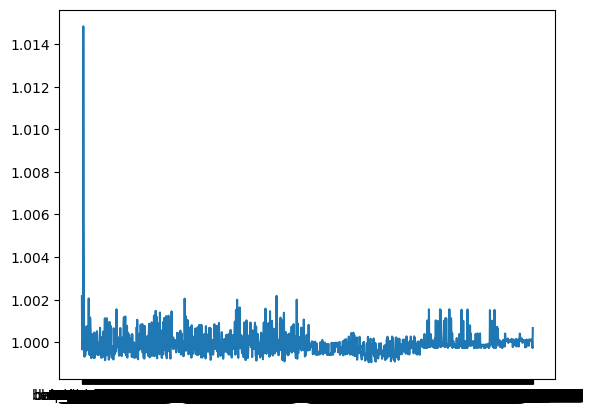

In [104]:
plt.plot(ZIP_REVI_max.summary()['R_hat'])

In [105]:
# Extract inference data
ZIP_REVI_idata = az.from_cmdstanpy(
    posterior=ZIP_REVI_max, 
    posterior_predictive=["M_pred", "lambda_rep", "theta_rep"],
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], "size" : obs_and_covs_dict['size'], "age2": obs_and_covs_dict["age2"]},
    log_likelihood="log_lik"
)

ZIP_REVI_idata.to_netcdf(os.path.join(idata_path, "ZIP_REVI_idataMax.nc"))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\ZIP_REVI_idataMax.nc'

In [4]:
Tewa_idata = az.from_netcdf(os.path.join(idata_path, "TEWA_age2_ZIP_linear_occupancy_mode.nc"))

In [13]:
TEWA_Poisson_idata = az.from_netcdf(os.path.join(idata_path, "TEWA_Poisson.nc"))

In [14]:
TEWA_Poisson_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [15]:
stacked = az.extract(TEWA_Poisson_idata)

In [16]:
stacked

<xarray.Dataset>
Dimensions:   (sample: 4000)
Coordinates:
  * sample    (sample) object MultiIndex
  * chain     (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw      (sample) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    alpha     (sample) float64 -0.1155 -0.0242 -0.1502 ... -0.06611 -0.08724
    beta_age  (sample) float64 0.005828 0.008282 0.004636 ... 0.003508 0.005316
Attributes:
    created_at:                 2023-10-10T21:32:53.251162
    arviz_version:              0.16.1
    inference_library:          cmdstanpy
    inference_library_version:  1.1.0

In [137]:
type(test['posterior_predictive'])
test['posterior_predictive'].to_netcdf(os.path.join(idata_path, 'ZIP_linear_occupancy_post_predict.nc'))

In [140]:
test['posterior'].to_netcdf(os.path.join(idata_path, 'ZIP_linear_occupancy_posterior.nc'))

In [12]:


# Load the NetCDF file
nc_data = xr.open_dataset(os.path.join(idata_path, "TEWA_Poisson.nc"))

# Display the structure and content of the NetCDF file
nc_data

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [127]:
test['posterior_predictive']

<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000, lambda_rep_dim_0: 395,
                       theta_rep_dim_0: 395, M_pred_dim_0: 395)
Coordinates:
  * chain             (chain) int32 0 1 2 3
  * draw              (draw) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * lambda_rep_dim_0  (lambda_rep_dim_0) int32 0 1 2 3 4 ... 390 391 392 393 394
  * theta_rep_dim_0   (theta_rep_dim_0) int32 0 1 2 3 4 ... 390 391 392 393 394
  * M_pred_dim_0      (M_pred_dim_0) int32 0 1 2 3 4 5 ... 390 391 392 393 394
Data variables:
    lambda_rep        (chain, draw, lambda_rep_dim_0) float64 ...
    theta_rep         (chain, draw, theta_rep_dim_0) float64 ...
    M_pred            (chain, draw, M_pred_dim_0) float64 ...
Attributes:
    created_at:                 2023-10-11T22:21:22.540292
    arviz_version:              0.16.1
    inference_library:          cmdstanpy
    inference_library_version:  1.1.0

In [33]:
az.summary(ZIP_linear_occupancy_TEWA_age2_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
alpha           0.904  0.496   0.604    1.762      0.247    0.189       7.0  \
beta_age        0.140  0.252  -0.008    0.576      0.126    0.096       7.0   
beta_age2      -0.371  0.643  -1.484    0.001      0.320    0.245       7.0   
beta_size       0.470  0.845  -0.022    1.934      0.421    0.322       7.0   
beta_age_size   0.382  0.661   0.000    1.527      0.329    0.252       7.0   
alpha_theta    -0.409  1.254  -1.913    1.715      0.489    0.362       8.0   
beta_latitude  -0.513  0.736  -2.033    0.866      0.173    0.129      18.0   
beta_longitude  0.590  0.566  -0.460    1.708      0.090    0.064      36.0   

                ess_tail  r_hat  
alpha             2096.0   1.53  
beta_age          2712.0   1.53  
beta_age2            4.0   1.53  
beta_size         1034.0   1.52  
beta_age_size     2317.0   1.53  
alpha_theta          5.0   1.46  
beta_latitude       34.0   1.68  
beta_longitude     171.0   1.64

In [34]:
az.waic(ZIP_linear_occupancy_TEWA_age2_idata)

c:\Users\ilebe\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 395 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -836.14    32.36
p_waic      442.61        -

There has been a warning during the calculation. Please check the results.

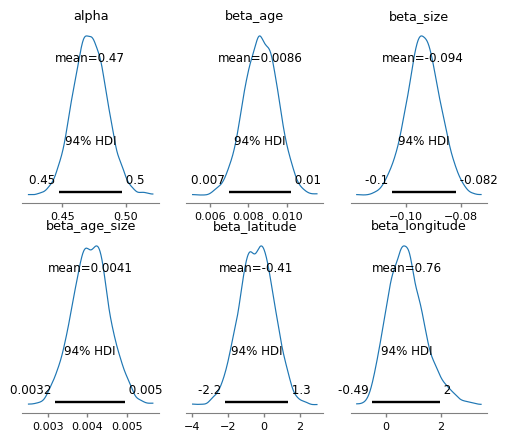

In [7]:
axes = az.plot_posterior(Tewa_idata,
                           var_names=['alpha', 'beta_age','beta_size', 'beta_age_size', 
                                      'beta_latitude',
                                      'beta_longitude'], 
                           figsize=(6, 5),
                           textsize=8)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_size'}>],
       [<Axes: title={'center': 'beta_age_size'}>,
        <Axes: title={'center': 'alpha_theta'}>,
        <Axes: title={'center': 'beta_latitude'}>],
       [<Axes: title={'center': 'beta_longitude'}>,
        <Axes: title={'center': 'beta_conifer'}>,
        <Axes: title={'center': 'beta_pine'}>]], dtype=object)

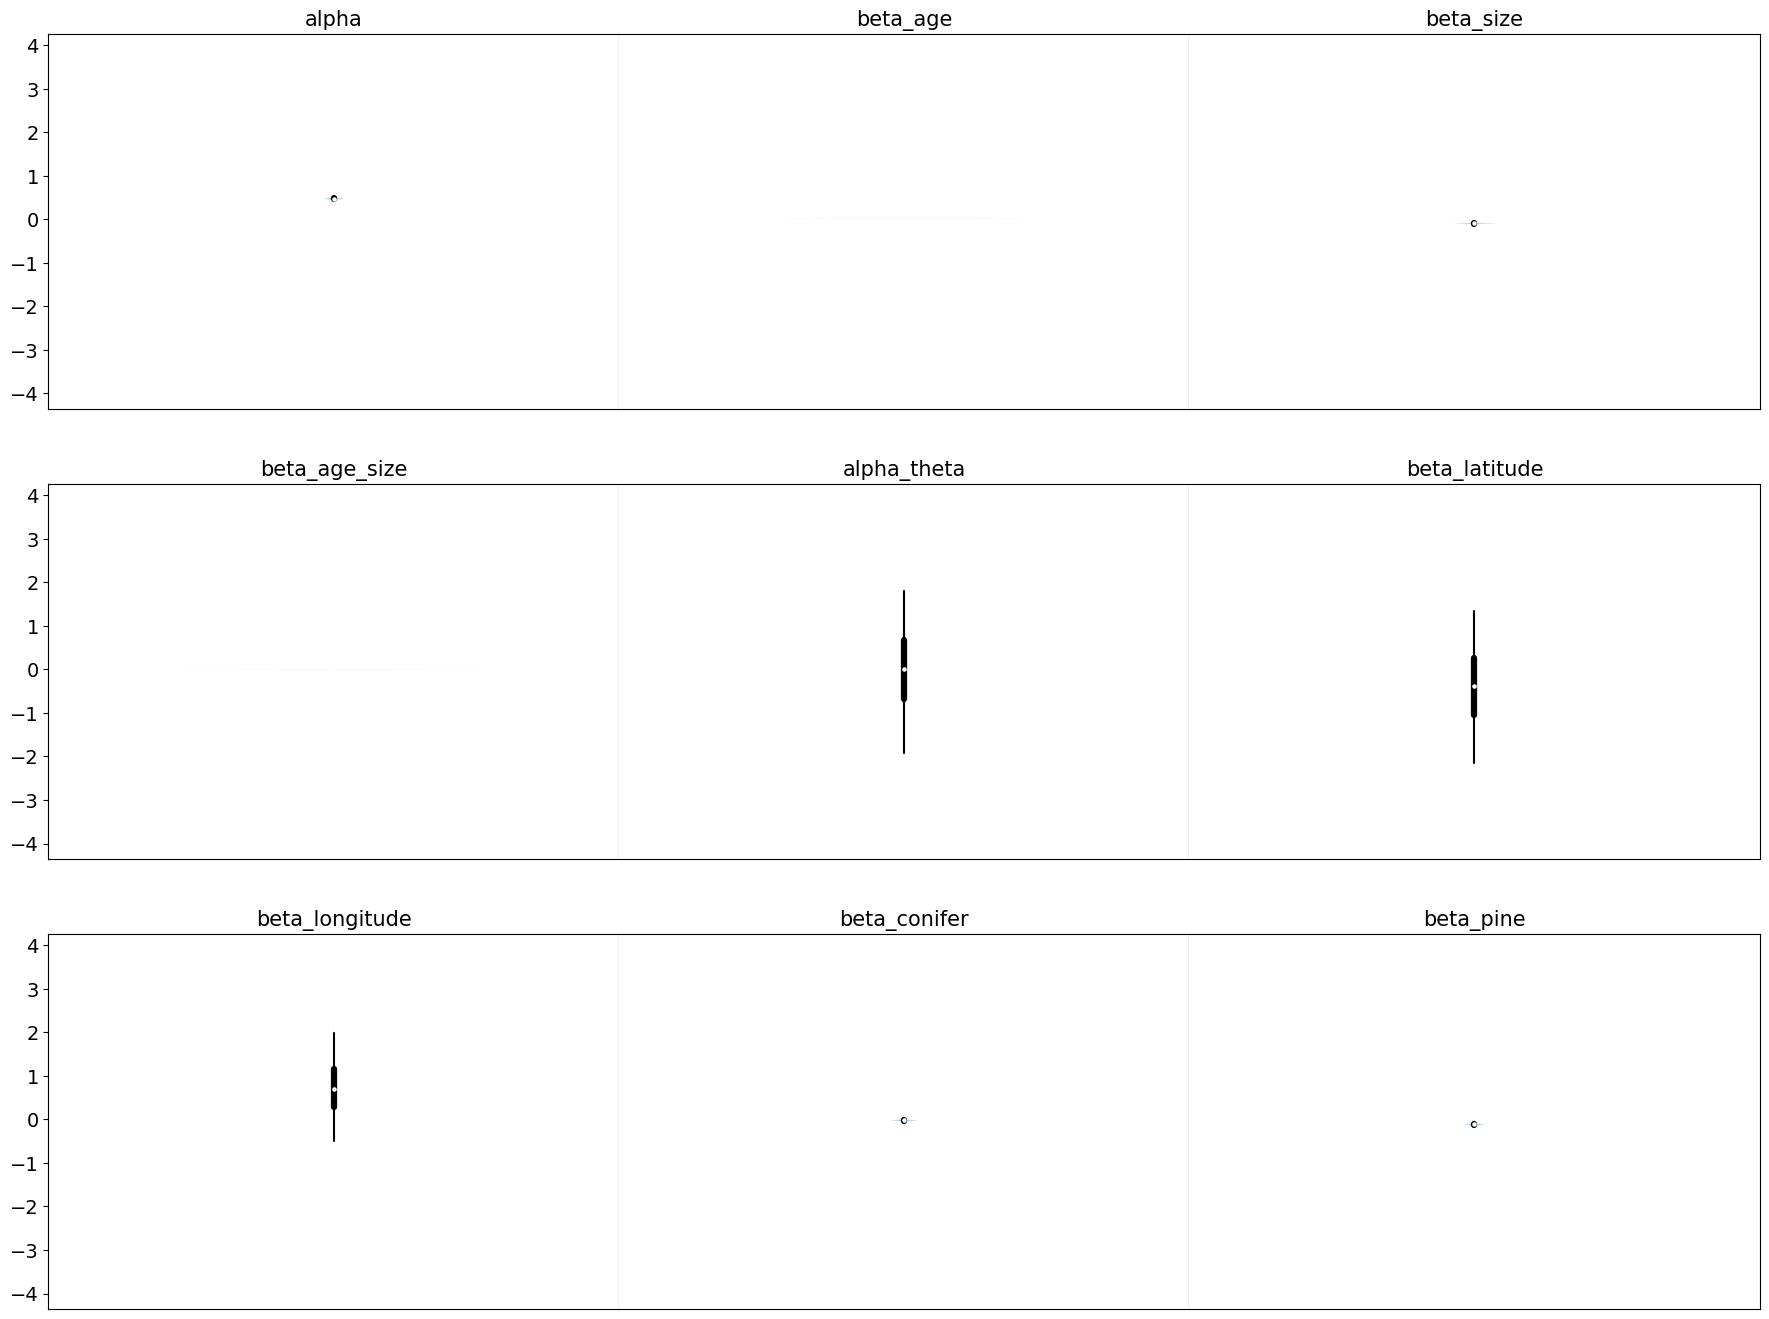

In [8]:
az.plot_violin(Tewa_idata)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

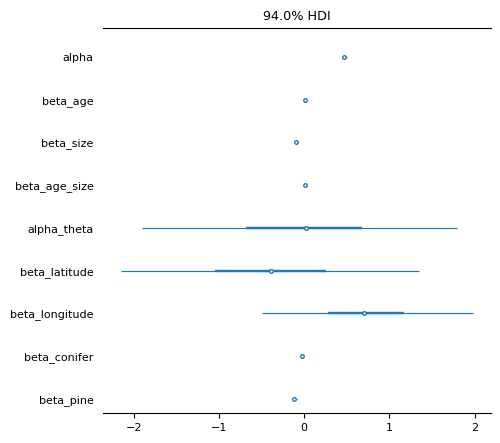

In [46]:
az.plot_forest(Tewa_idata,  figsize=(5, 5), combined=True, textsize=8)

In [62]:
Tewa_idata_max = az.from_netcdf(os.path.join(idata_path, "TEWA_age2_ZIP_linear_occupancy.nc"))

<Axes: xlabel='M / M_pred'>

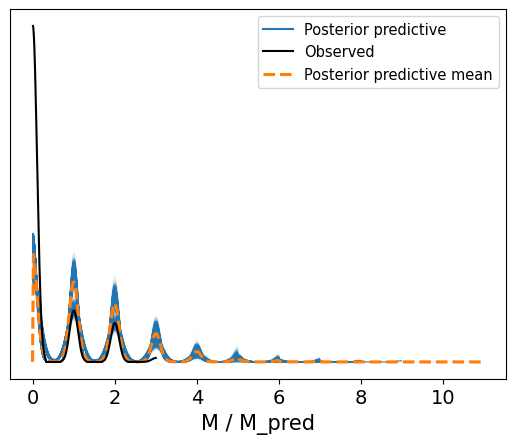

In [106]:
az.plot_ppc(ZIP_REVI_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

In [67]:
Tewa_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

<Axes: xlabel='M / M_pred'>

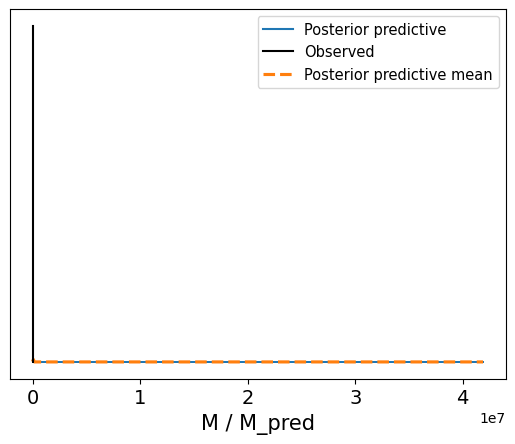

In [66]:
az.plot_ppc(Tewa_idata_max, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

In [47]:
WTSP_idata = az.from_netcdf(os.path.join(idata_path, "WTSP_ZIP_linear_occupancy.nc"))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

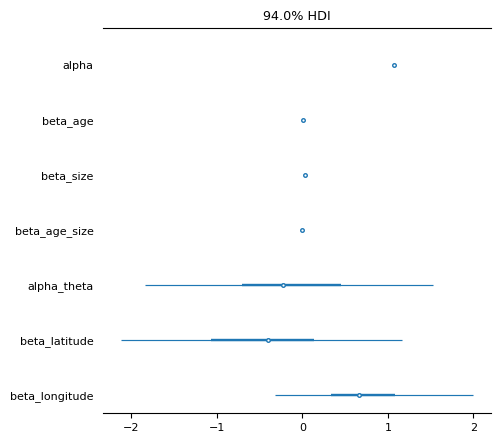

In [48]:
az.plot_forest(WTSP_idata,  figsize=(5, 5), combined=True, textsize=8)

<Axes: xlabel='M / M_pred'>

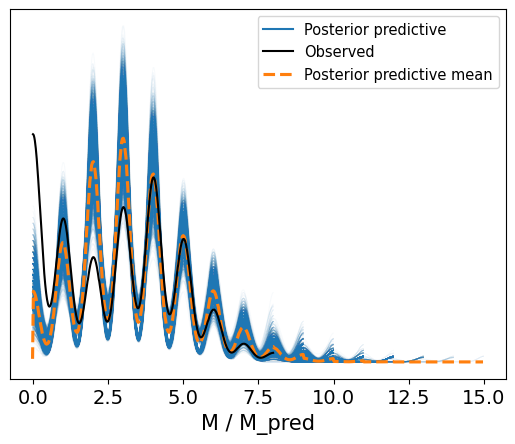

In [60]:
az.plot_ppc(WTSP_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

In [49]:
REVI_idata = az.from_netcdf(os.path.join(idata_path, "REVI_ZIP_linear_occupancy.nc"))

In [76]:
REVI_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [98]:
ZIP_REVI_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

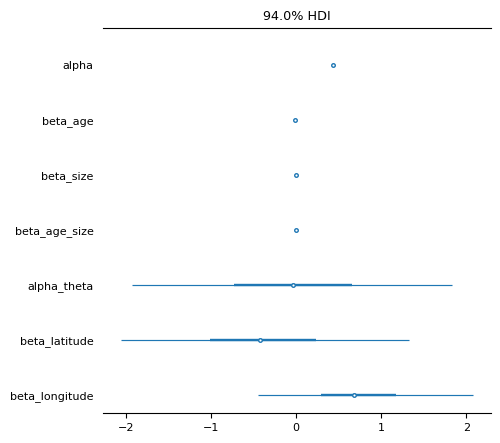

In [50]:
az.plot_forest(REVI_idata,  figsize=(5, 5), combined=True, textsize=8)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

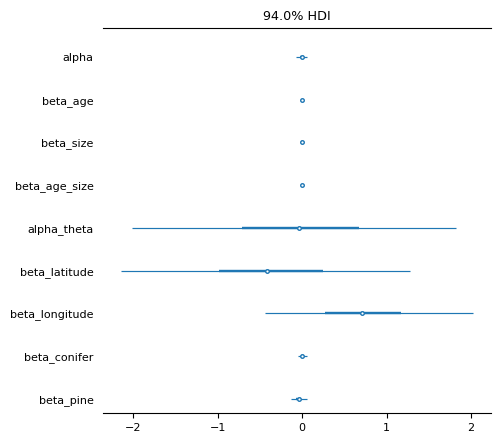

In [99]:
az.plot_forest(ZIP_REVI_idata,  figsize=(5, 5), combined=True, textsize=8)

In [55]:
obs_and_covs_dict.keys()

dict_keys(['I', 'J', 'N', 'y', 'M', 'latitude', 'longitude', 'percent_conifer', 'percent_deciduous', 'percent_pine', 'size', 'age', 'age2', 'time_of_day', 'Julian_date'])

<Axes: xlabel='M / M_pred'>

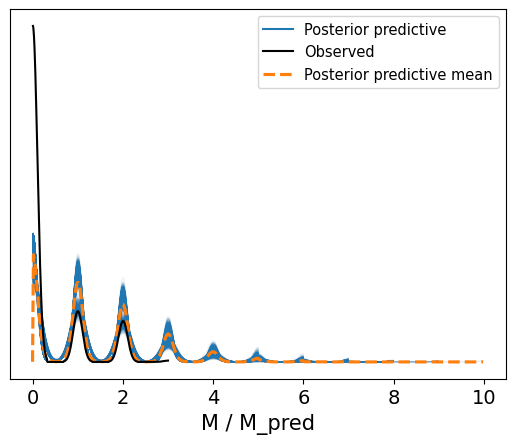

In [57]:
az.plot_ppc(REVI_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

<Axes: xlabel='M / M_pred'>

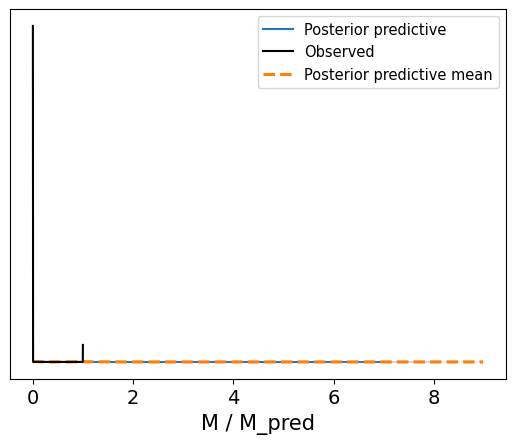

In [100]:
az.plot_ppc(ZIP_REVI_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

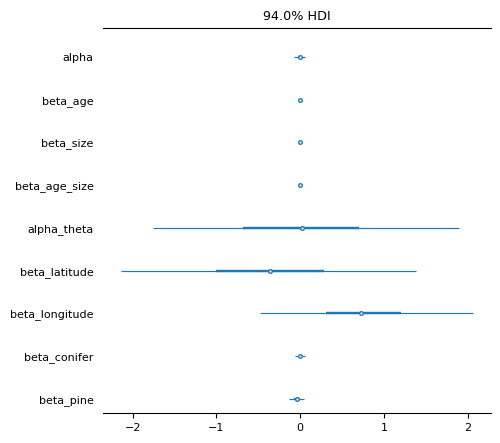

In [85]:
az.plot_forest(ZIP_YRWA_idata,  figsize=(5, 5), combined=True, textsize=8)

<Axes: xlabel='M / M_pred'>

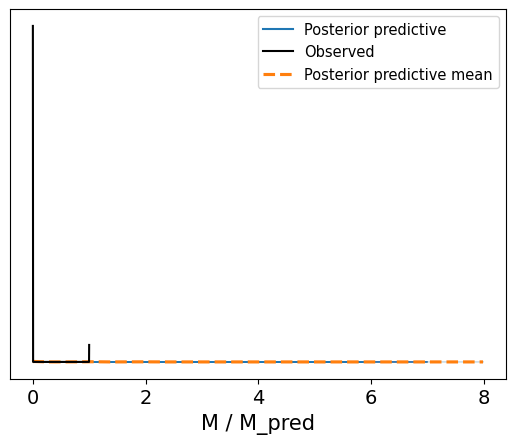

In [86]:
az.plot_ppc(ZIP_YRWA_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

In [ ]:
ZIP_YRWA_idata

#### C.6.5 Response plots

In [143]:
ZIP_linear_occupancy_idata['posterior']

<xarray.Dataset>
Dimensions:         (chain: 4, draw: 1000)
Coordinates:
  * chain           (chain) int32 0 1 2 3
  * draw            (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    alpha           (chain, draw) float64 0.56 0.5651 0.5651 ... 0.5616 0.5567
    beta_age        (chain, draw) float64 0.0108 0.009794 ... 0.01016 0.01099
    beta_size       (chain, draw) float64 -0.006516 -0.01447 ... -0.009051
    beta_age_size   (chain, draw) float64 -0.002488 -0.001616 ... -0.002202
    alpha_theta     (chain, draw) float64 0.336 -0.3968 ... 0.1993 -0.1957
    beta_latitude   (chain, draw) float64 -1.708 -1.719 ... -0.1734 -0.2747
    beta_longitude  (chain, draw) float64 -0.09002 -0.2682 ... 0.4365 0.2643
Attributes:
    created_at:                 2023-10-11T22:21:22.498172
    arviz_version:              0.16.1
    inference_library:          cmdstanpy
    inference_library_version:  1.1.0

In [144]:
# Extract the latitude and longitude values
latitude_values = obs_and_covs_dict.get('latitude', [])
longitude_values = obs_and_covs_dict.get('longitude', [])

# Determine the range for latitude and longitude
latitude_range = (min(latitude_values), max(latitude_values))
longitude_range = (min(longitude_values), max(longitude_values))

latitude_range, longitude_range

# Define a grid of latitude and longitude values within the specified range
lat_grid = np.linspace(latitude_range[0], latitude_range[1], 100)
lon_grid = np.linspace(longitude_range[0], longitude_range[1], 100)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

posterior_data = ZIP_linear_occupancy_idata['posterior']

# Extract posterior samples for the parameters
alpha_theta_samples = posterior_data['alpha_theta'].values.flatten()
beta_latitude_samples = posterior_data['beta_latitude'].values.flatten()
beta_longitude_samples = posterior_data['beta_longitude'].values.flatten()

# Compute theta for each combination of latitude and longitude values using the logistic function
theta_samples = 1 / (1 + np.exp(-(alpha_theta_samples[:, None, None] + 
                                  beta_latitude_samples[:, None, None] * lat_mesh +
                                  beta_longitude_samples[:, None, None] * lon_mesh)))

# Compute the median and credible intervals for theta
theta_median = np.median(theta_samples, axis=0)
theta_lower = np.percentile(theta_samples, 2.5, axis=0)
theta_upper = np.percentile(theta_samples, 97.5, axis=0)

theta_median, theta_lower, theta_upper


# Define a grid of latitude and longitude values within the specified range
lat_grid = np.linspace(latitude_range[0], latitude_range[1], 100)
lon_grid = np.linspace(longitude_range[0], longitude_range[1], 100)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

# Extract posterior samples for the parameters
alpha_theta_samples = posterior_data['alpha_theta'].values.flatten()
beta_latitude_samples = posterior_data['beta_latitude'].values.flatten()
beta_longitude_samples = posterior_data['beta_longitude'].values.flatten()

# Compute theta for each combination of latitude and longitude values using the logistic function
theta_samples = 1 / (1 + np.exp(-(alpha_theta_samples[:, None, None] + 
                                  beta_latitude_samples[:, None, None] * lat_mesh +
                                  beta_longitude_samples[:, None, None] * lon_mesh)))

# Compute the median and credible intervals for theta
theta_median = np.median(theta_samples, axis=0)
theta_lower = np.percentile(theta_samples, 2.5, axis=0)
theta_upper = np.percentile(theta_samples, 97.5, axis=0)

theta_samples


array([[[1.51897668e-32, 1.28166347e-32, 1.08142625e-32, ...,
         1.05967422e-39, 8.94118890e-40, 7.54428645e-40],
        [1.50638820e-32, 1.27104172e-32, 1.07246395e-32, ...,
         1.05089220e-39, 8.86708901e-40, 7.48176336e-40],
        [1.49390404e-32, 1.26050799e-32, 1.06357593e-32, ...,
         1.04218296e-39, 8.79360322e-40, 7.41975842e-40],
        ...,
        [6.77600137e-33, 5.71737114e-33, 4.82413313e-33, ...,
         4.72709956e-40, 3.98857395e-40, 3.36542989e-40],
        [6.71984542e-33, 5.66998856e-33, 4.78415324e-33, ...,
         4.68792383e-40, 3.95551874e-40, 3.33753897e-40],
        [6.66415486e-33, 5.62299866e-33, 4.74450469e-33, ...,
         4.64907277e-40, 3.92273747e-40, 3.30987920e-40]],

       [[7.82167825e-24, 6.59218679e-24, 5.55595938e-24, ...,
         4.88727787e-31, 4.11904550e-31, 3.47157176e-31],
        [7.63009448e-24, 6.43071811e-24, 5.41987201e-24, ...,
         4.76756914e-31, 4.01815382e-31, 3.38653926e-31],
        [7.44320335e-24, 

In [9]:
Tewa_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [10]:
# Extract M_pred values
M_pred = Tewa_idata['posterior_predictive']['M_pred'].values

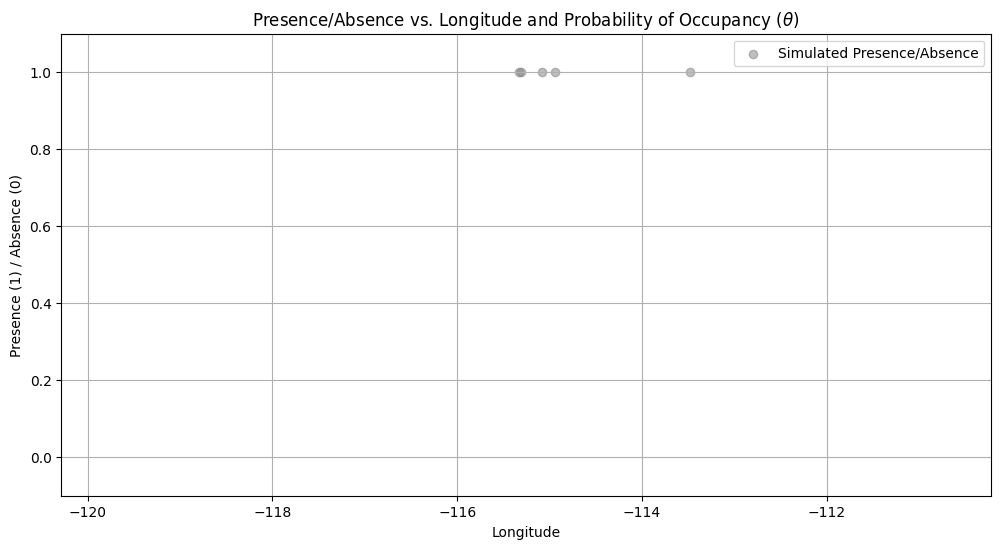

In [153]:
# Compute the median of M_pred for presence/absence plot
M_pred_median = np.median(M_pred, axis=(0, 1))

# Compute theta for each longitude value using the logistic function and median of the posteriors
theta_lon = 1 / (1 + np.exp(-(np.median(alpha_theta_samples) + 
                              np.median(beta_longitude_samples) * lon_grid)))

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(longitude_values, M_pred_median, color='gray', alpha=0.5, label='Simulated Presence/Absence')
# plt.plot(lon_grid, theta_lon, color='blue', label='Probability of Occupancy ($\\theta$)')
plt.xlabel("Longitude")
plt.ylabel("Presence (1) / Absence (0)")
plt.title("Presence/Absence vs. Longitude and Probability of Occupancy ($\\theta$)")
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)  # To better visualize the data
plt.show()


### C.7 ZIP - Matching Covariates Occupancy & Abundance

In [18]:
ZIP_all_covs = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_all_covs.stan"))

In [17]:
ZIP_WTSP_covs = ZIP_all_covs.sample(
    data=MinMax_obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

13:33:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:05 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:09 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:10 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:11 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:12 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:13 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:14 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:15 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:16 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain


13:33:29 - cmdstanpy - INFO - CmdStan done processing.


In [212]:
ZIP_WTSP_covs.summary()

Mean      MCSE    StdDev          5%         50%   
lp__           -206.290000  0.074908  2.866260 -211.697000 -205.948000  \
beta_0           -0.621463  0.008930  0.492182   -1.415840   -0.625128   
beta_age         -0.228226  0.008816  0.501621   -1.041910   -0.237539   
beta_size        -0.482302  0.013449  0.943772   -2.028420   -0.494621   
beta_age_size    -0.222900  0.013706  1.014340   -1.896130   -0.208111   
...                    ...       ...       ...         ...         ...   
theta_rep[391]    0.352421  0.002607  0.168606    0.096441    0.341691   
theta_rep[392]    0.365852  0.002077  0.137221    0.144585    0.364783   
theta_rep[393]    0.482708  0.003306  0.188549    0.144286    0.496511   
theta_rep[394]    0.552379  0.003288  0.177254    0.208554    0.579121   
theta_rep[395]    0.408219  0.002883  0.189844    0.104197    0.402370   

                       95%    N_Eff   N_Eff/s     R_hat  
lp__           -202.201000  1464.13   32.1575  1.001450  
beta_0            0.175352  3037.42   66.7125  1.000520  
beta_age          0.623378  3237.20   71.1004  1.000810  
beta_size         1.123920  4924.33  108.1560  0.999983  
beta_age_size     1.444890  5477.02  120.2950  0.999768  
...                    ...      ...       ...       ...  
theta_rep[391]    0.647362  4183.22   91.8783  0.999601  
theta_rep[392]    0.593026  4365.66   95.8854  0.999778  
theta_rep[393]    0.767335  3253.35   71.4550  1.000040  
theta_rep[394]    0.793497  2906.12   63.8286  0.999865  
theta_rep[395]    0.728494  4335.67   95.2266  0.999290  

[1597 rows x 9 columns]

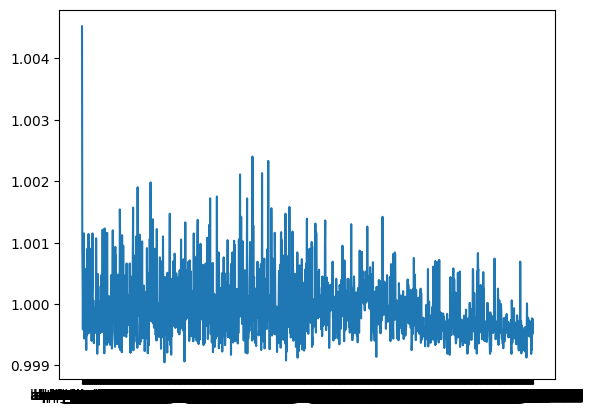

In [18]:
plt.plot(ZIP_WTSP_covs.summary()['R_hat'])

In [19]:
# Extract inference data
WTSP_covs_idata = az.from_cmdstanpy(
    posterior=ZIP_WTSP_covs, 
    posterior_predictive=["M_pred", "lambda_rep", "theta_rep"],
    observed_data={"M": obs_and_covs_dict["M"]},
    constant_data={"age": obs_and_covs_dict["age"], 
                   "size" : obs_and_covs_dict['size'],
                   "latitude": obs_and_covs_dict['latitude'],
                   "longitude": obs_and_covs_dict['longitude'],
                    "percent_conifer": obs_and_covs_dict['percent_conifer'], 
                    "percent_pine": obs_and_covs_dict['percent_pine']},
    log_likelihood="log_lik"
)

# OSFL_covs_idata.to_netcdf(os.path.join(idata_path, "OSFL_allCovs.nc"))

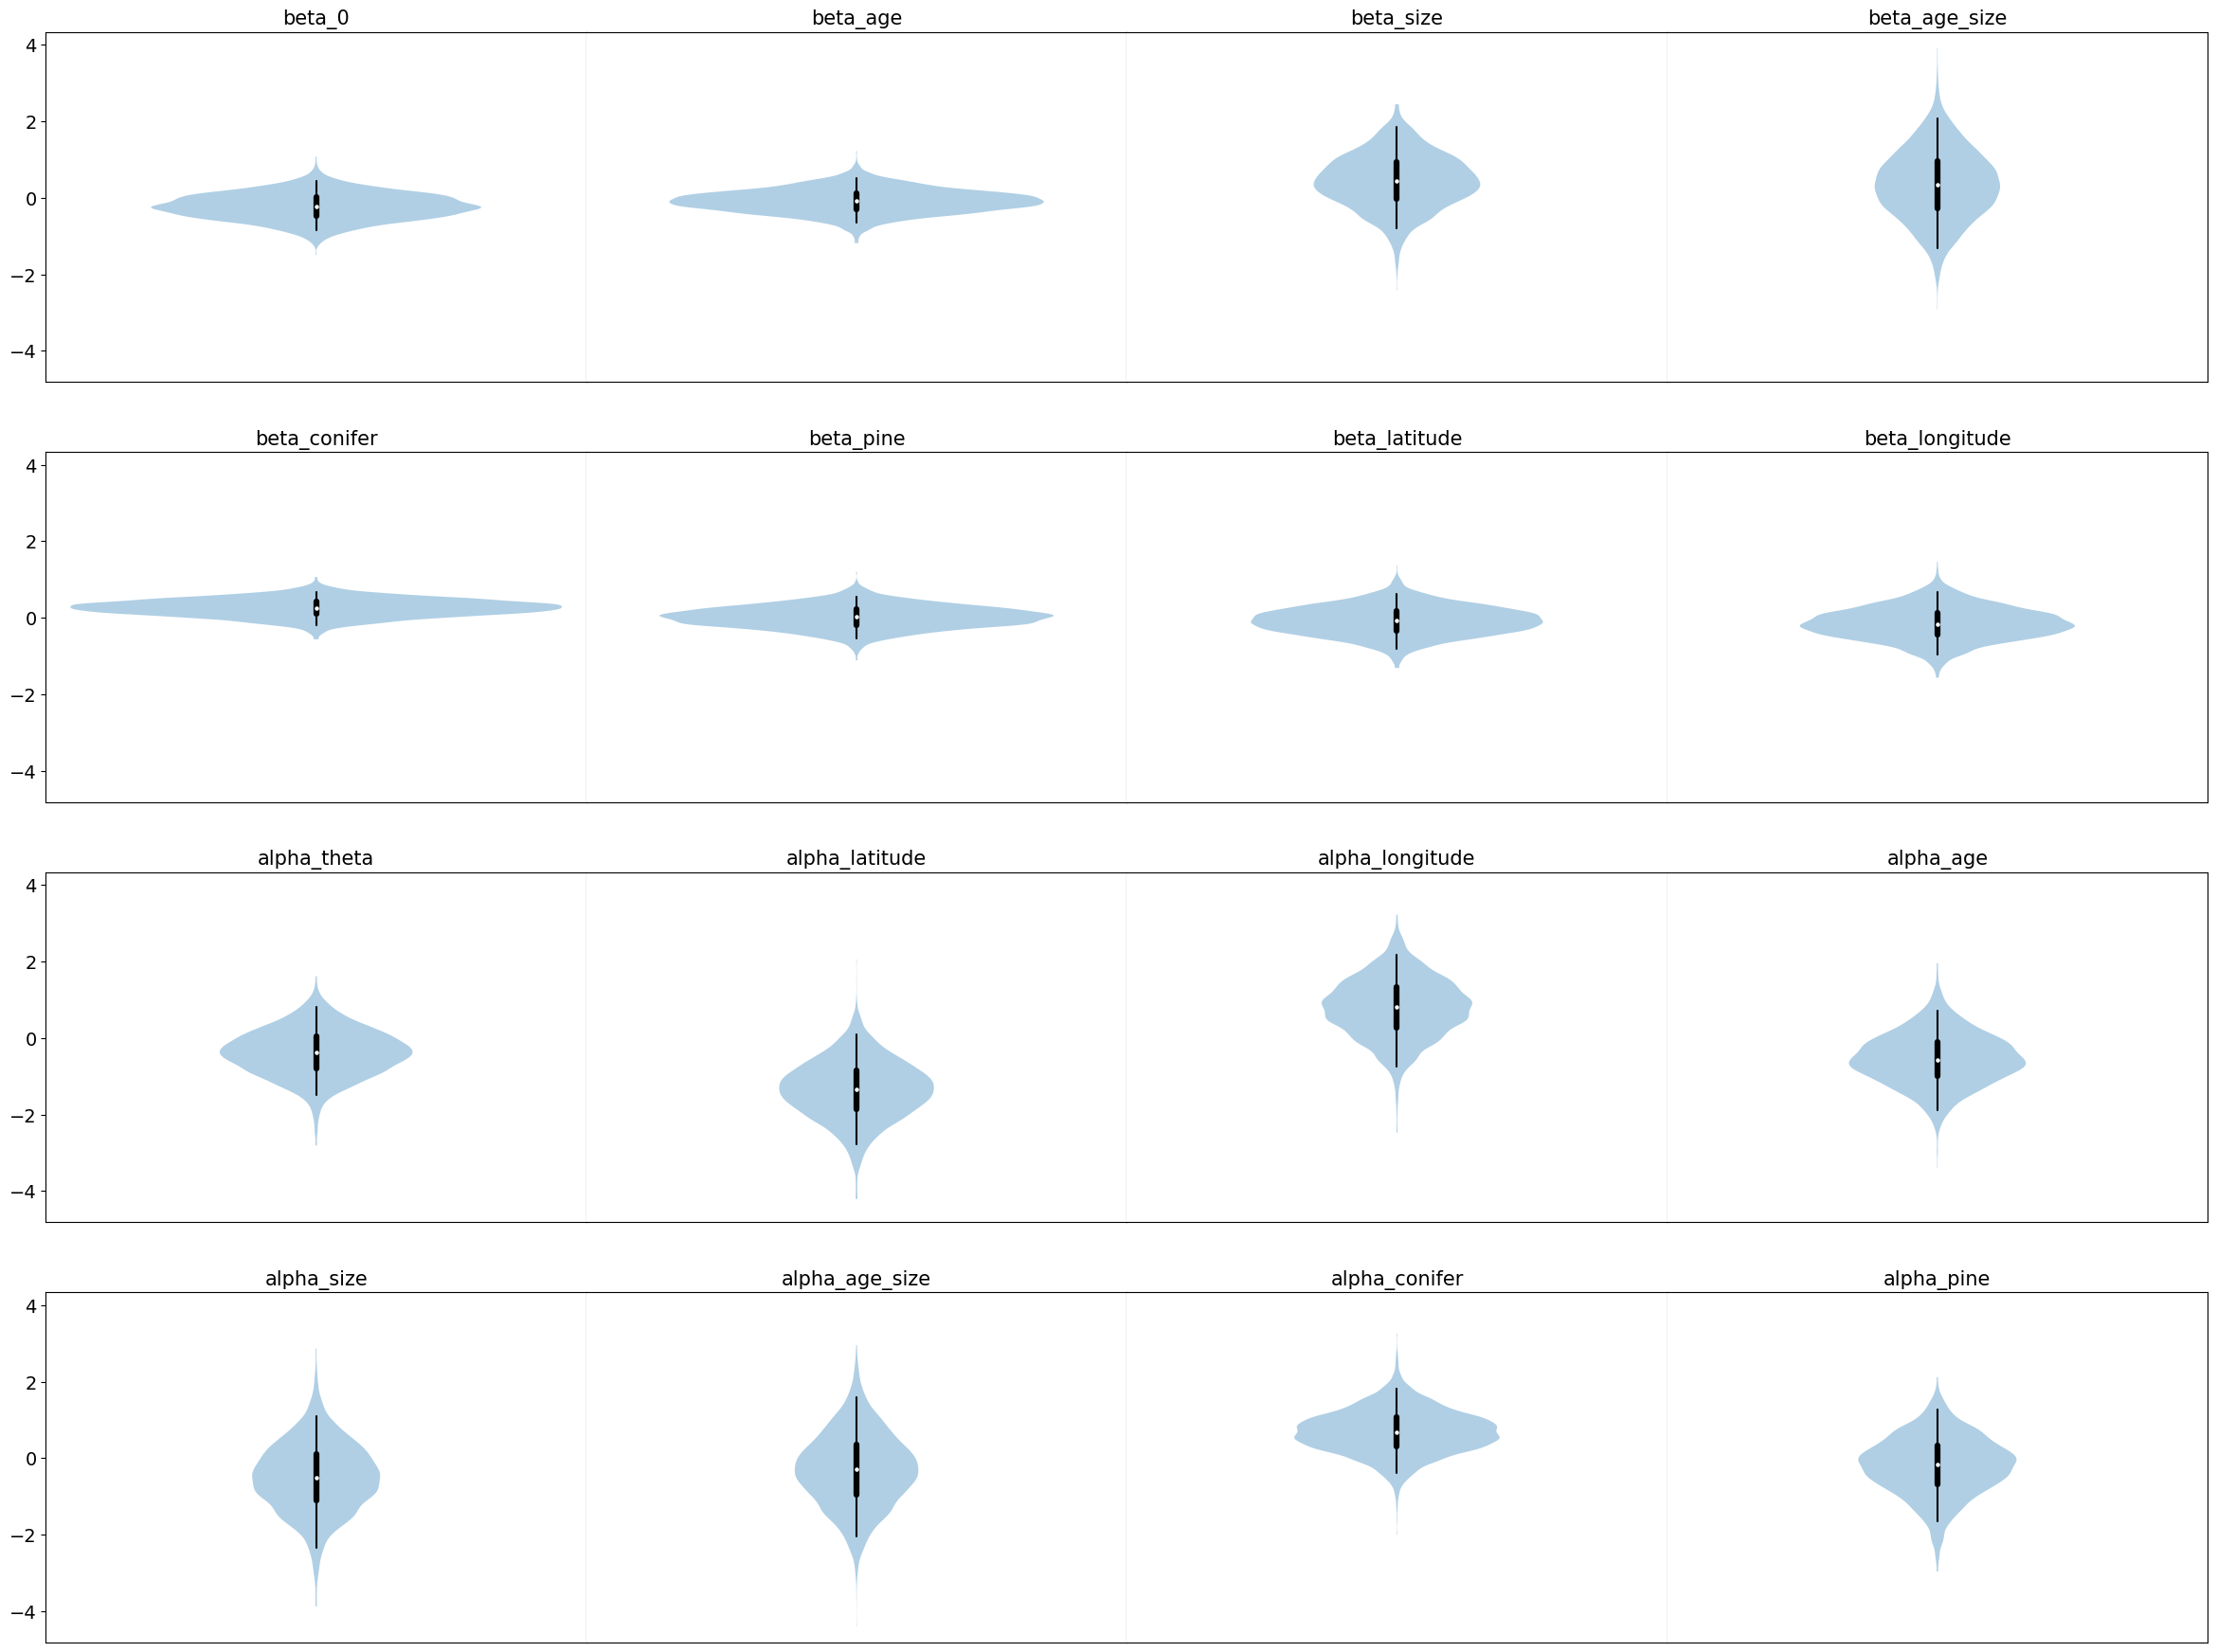

In [150]:
ax = az.plot_violin(REVI_covs_idata)


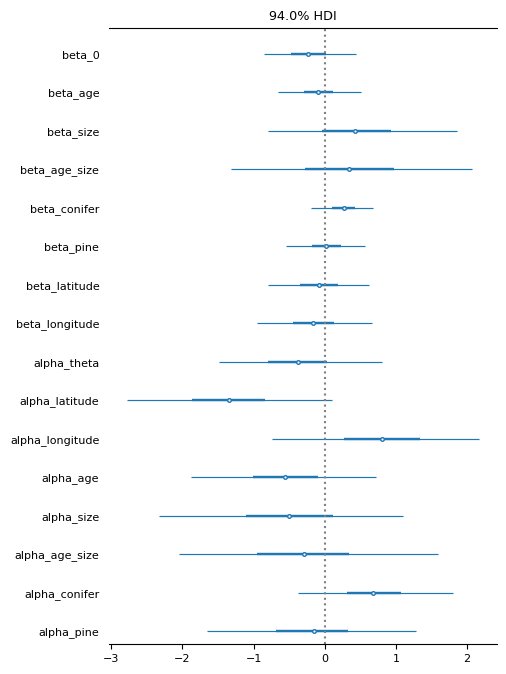

In [152]:
ax = az.plot_forest(REVI_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

<Axes: xlabel='M / M_pred'>

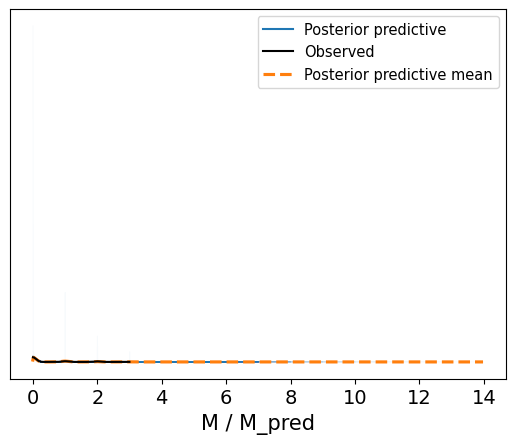

In [223]:
az.plot_ppc(REVI_covs_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

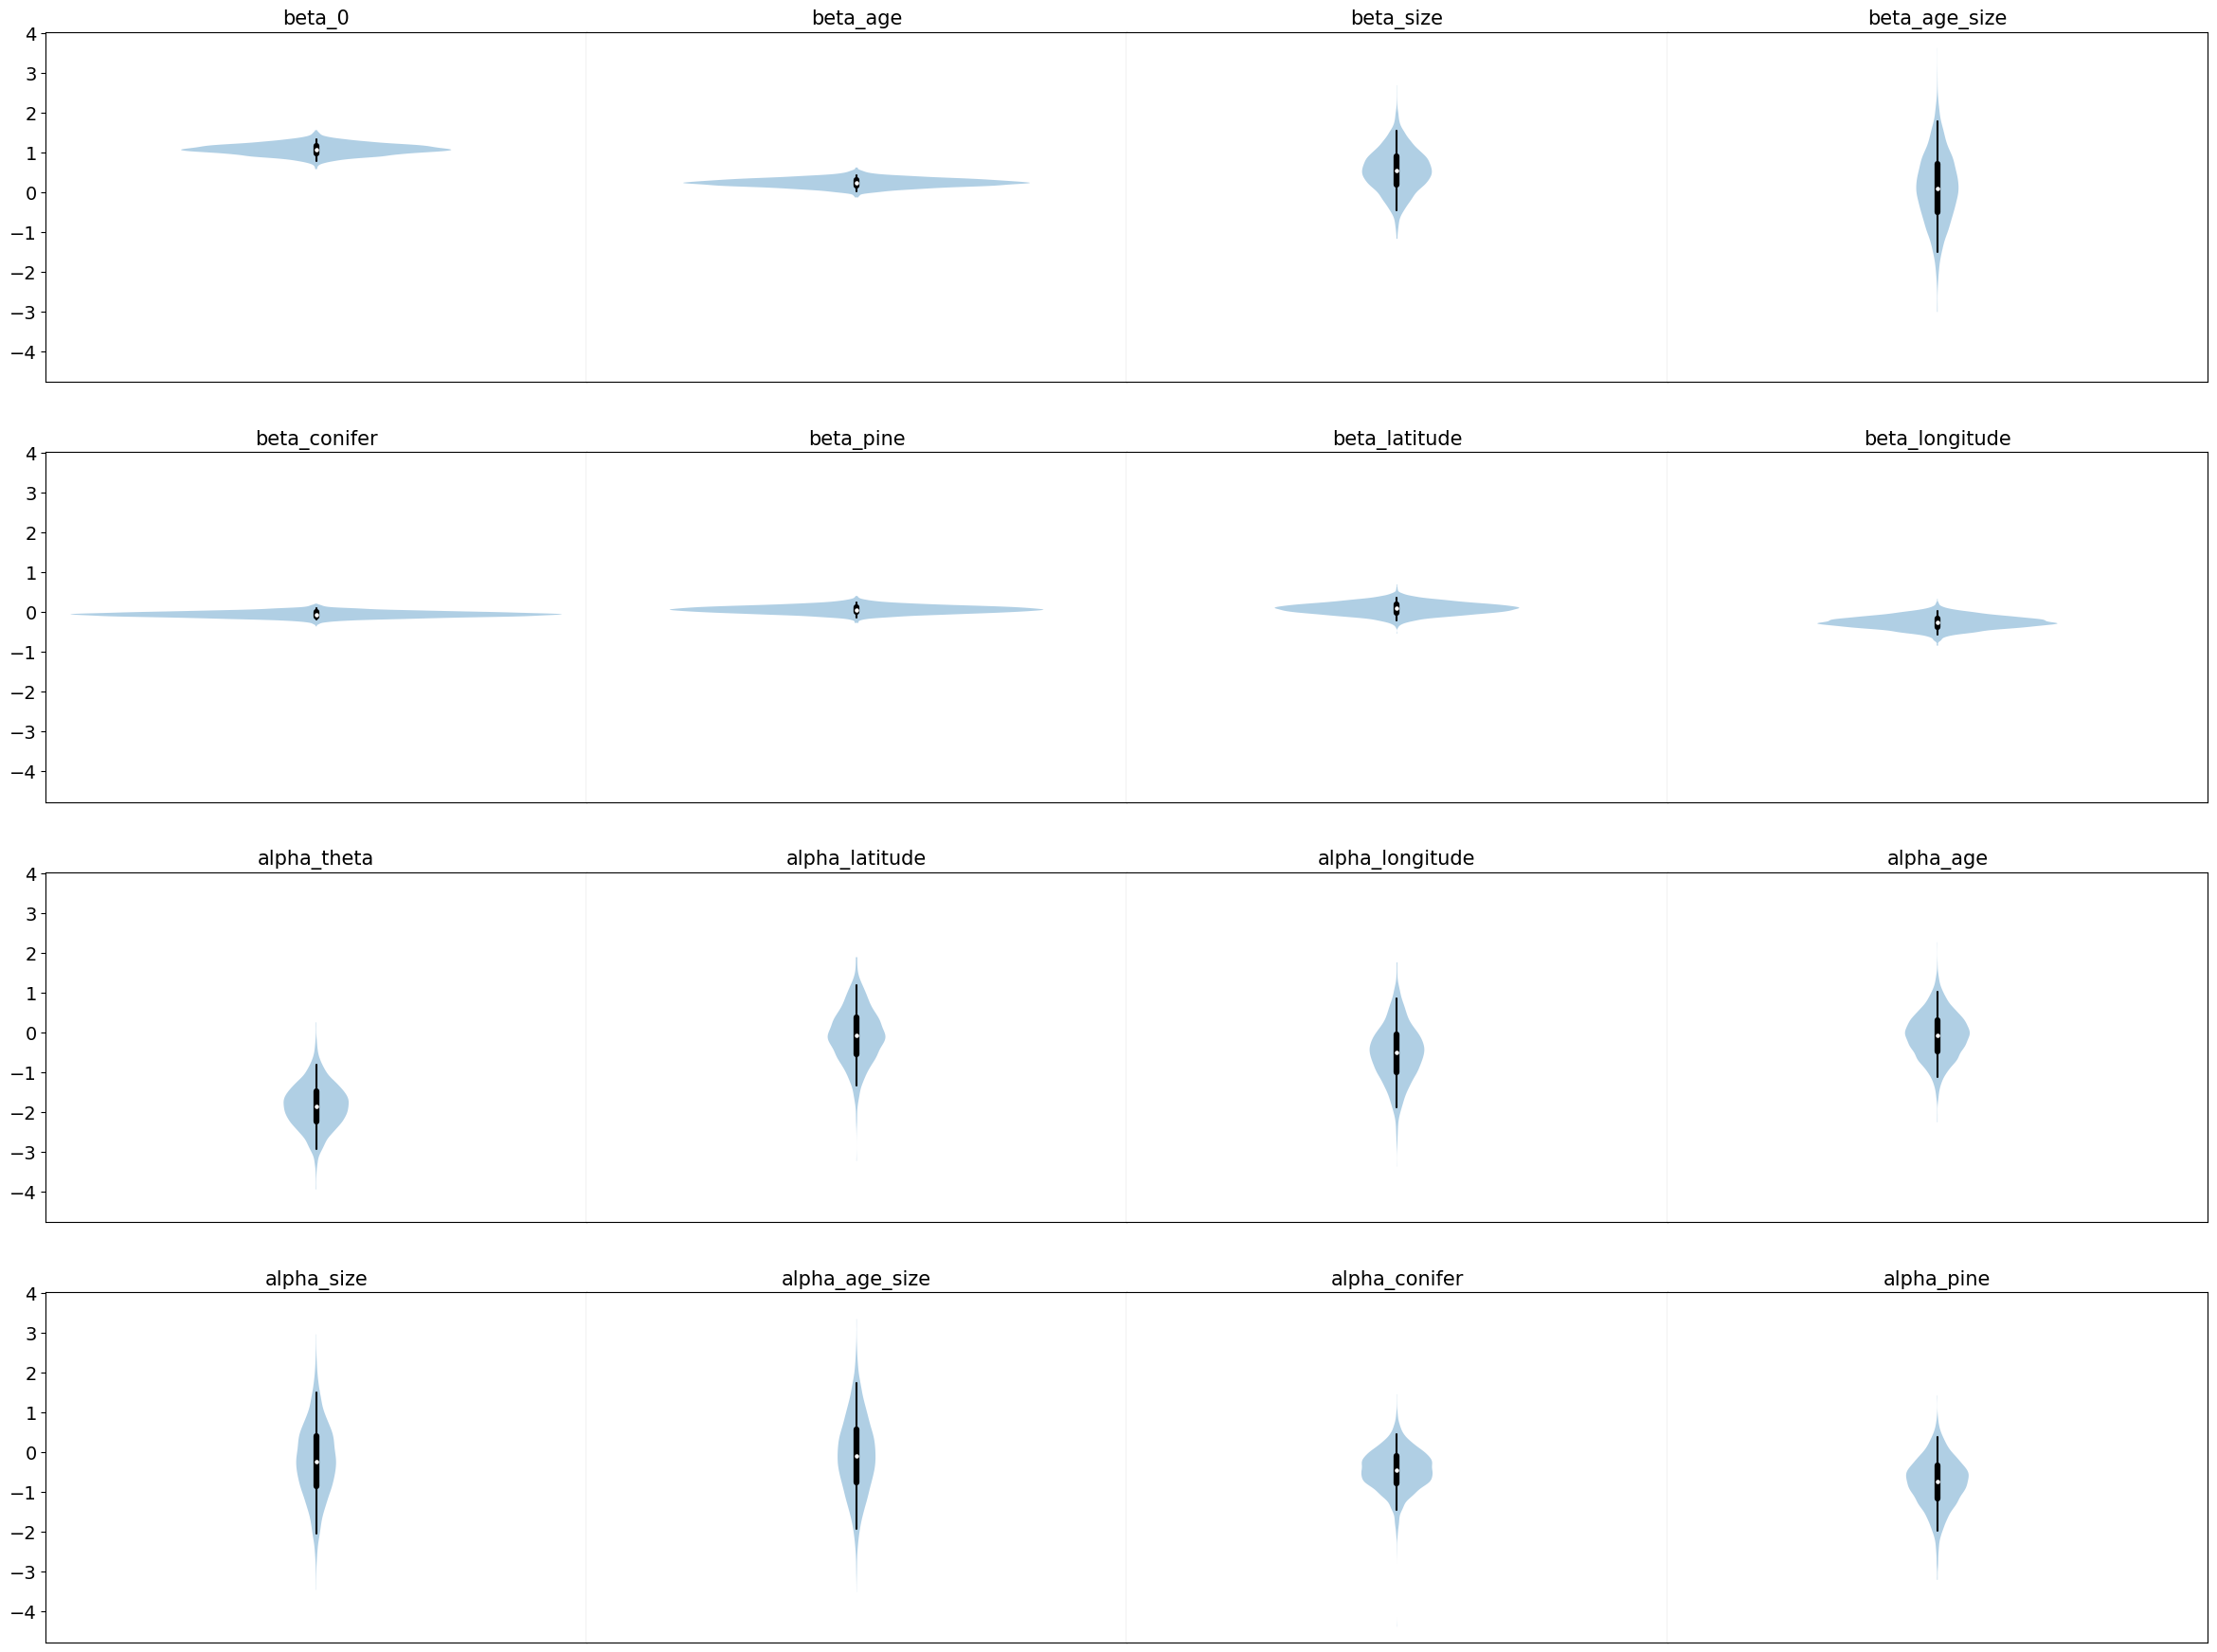

In [164]:
ax =az.plot_violin(WTSP_covs_idata)

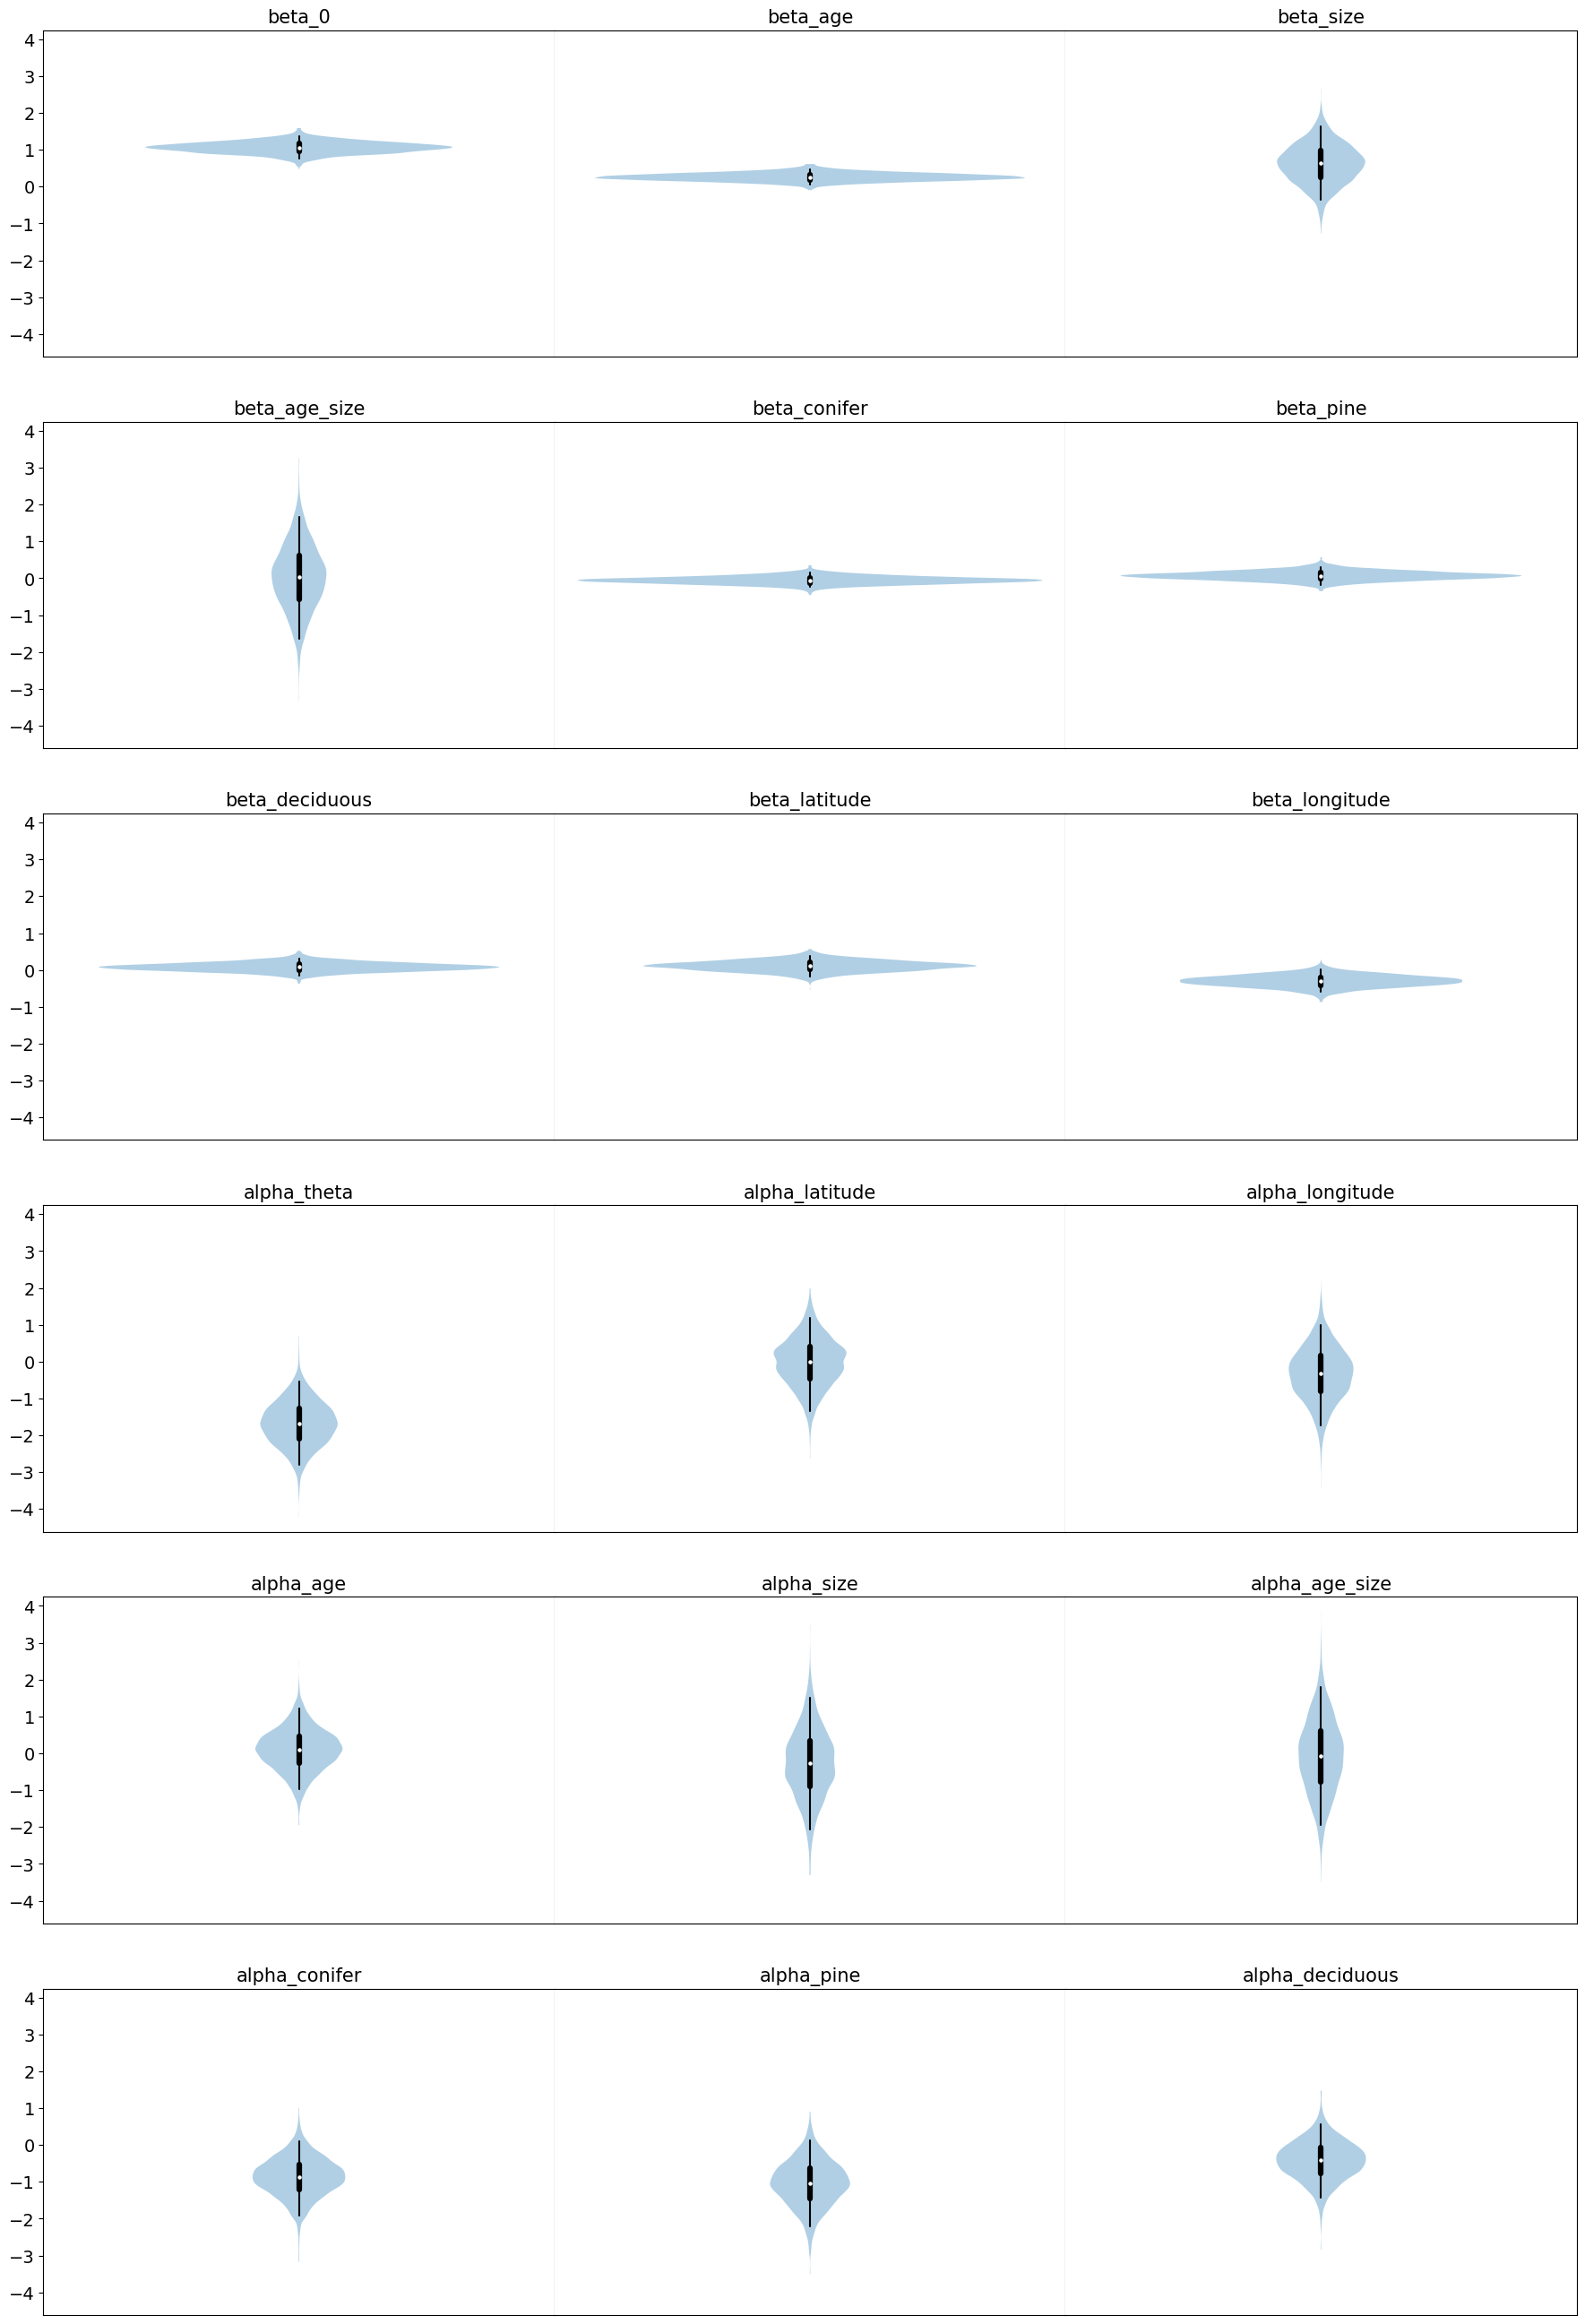

In [20]:
ax =az.plot_violin(WTSP_covs_idata)

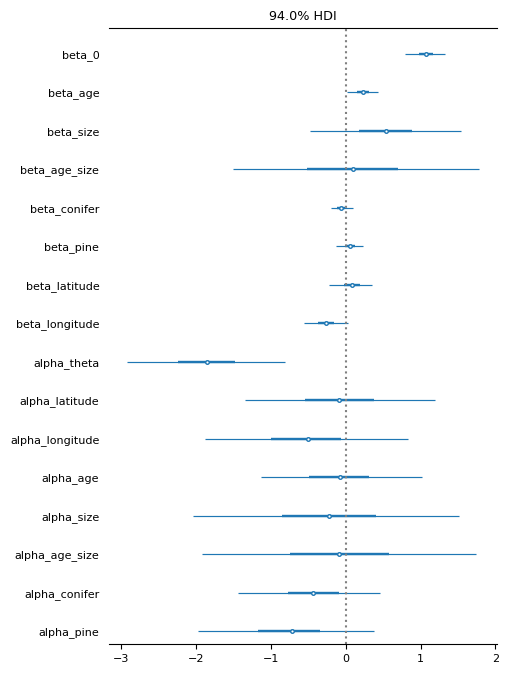

In [165]:
ax = az.plot_forest(WTSP_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

In [22]:
WTSP_covs_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

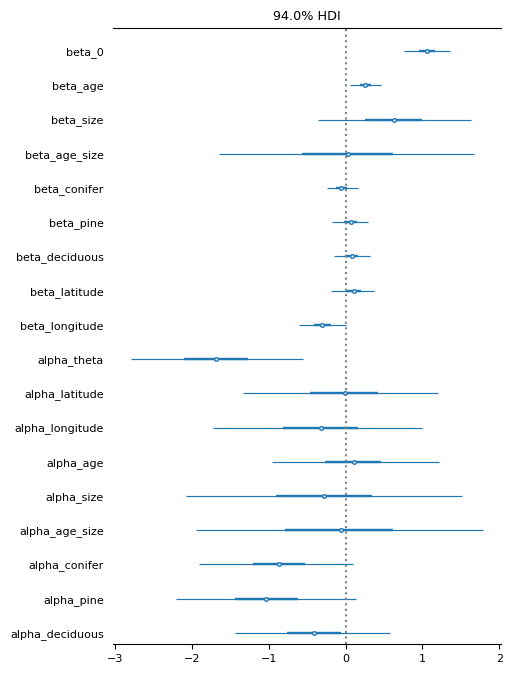

In [21]:
ax = az.plot_forest(WTSP_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

<Axes: xlabel='M / M_pred'>

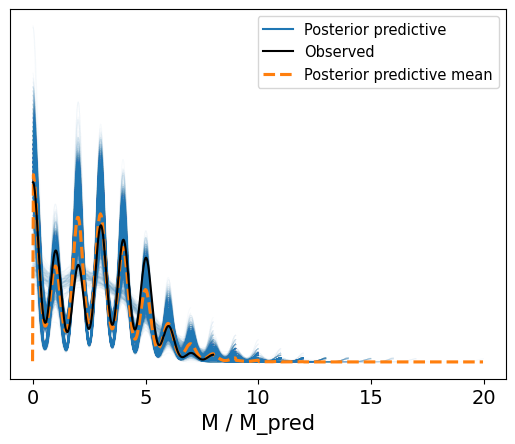

In [218]:
az.plot_ppc(WTSP_covs_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

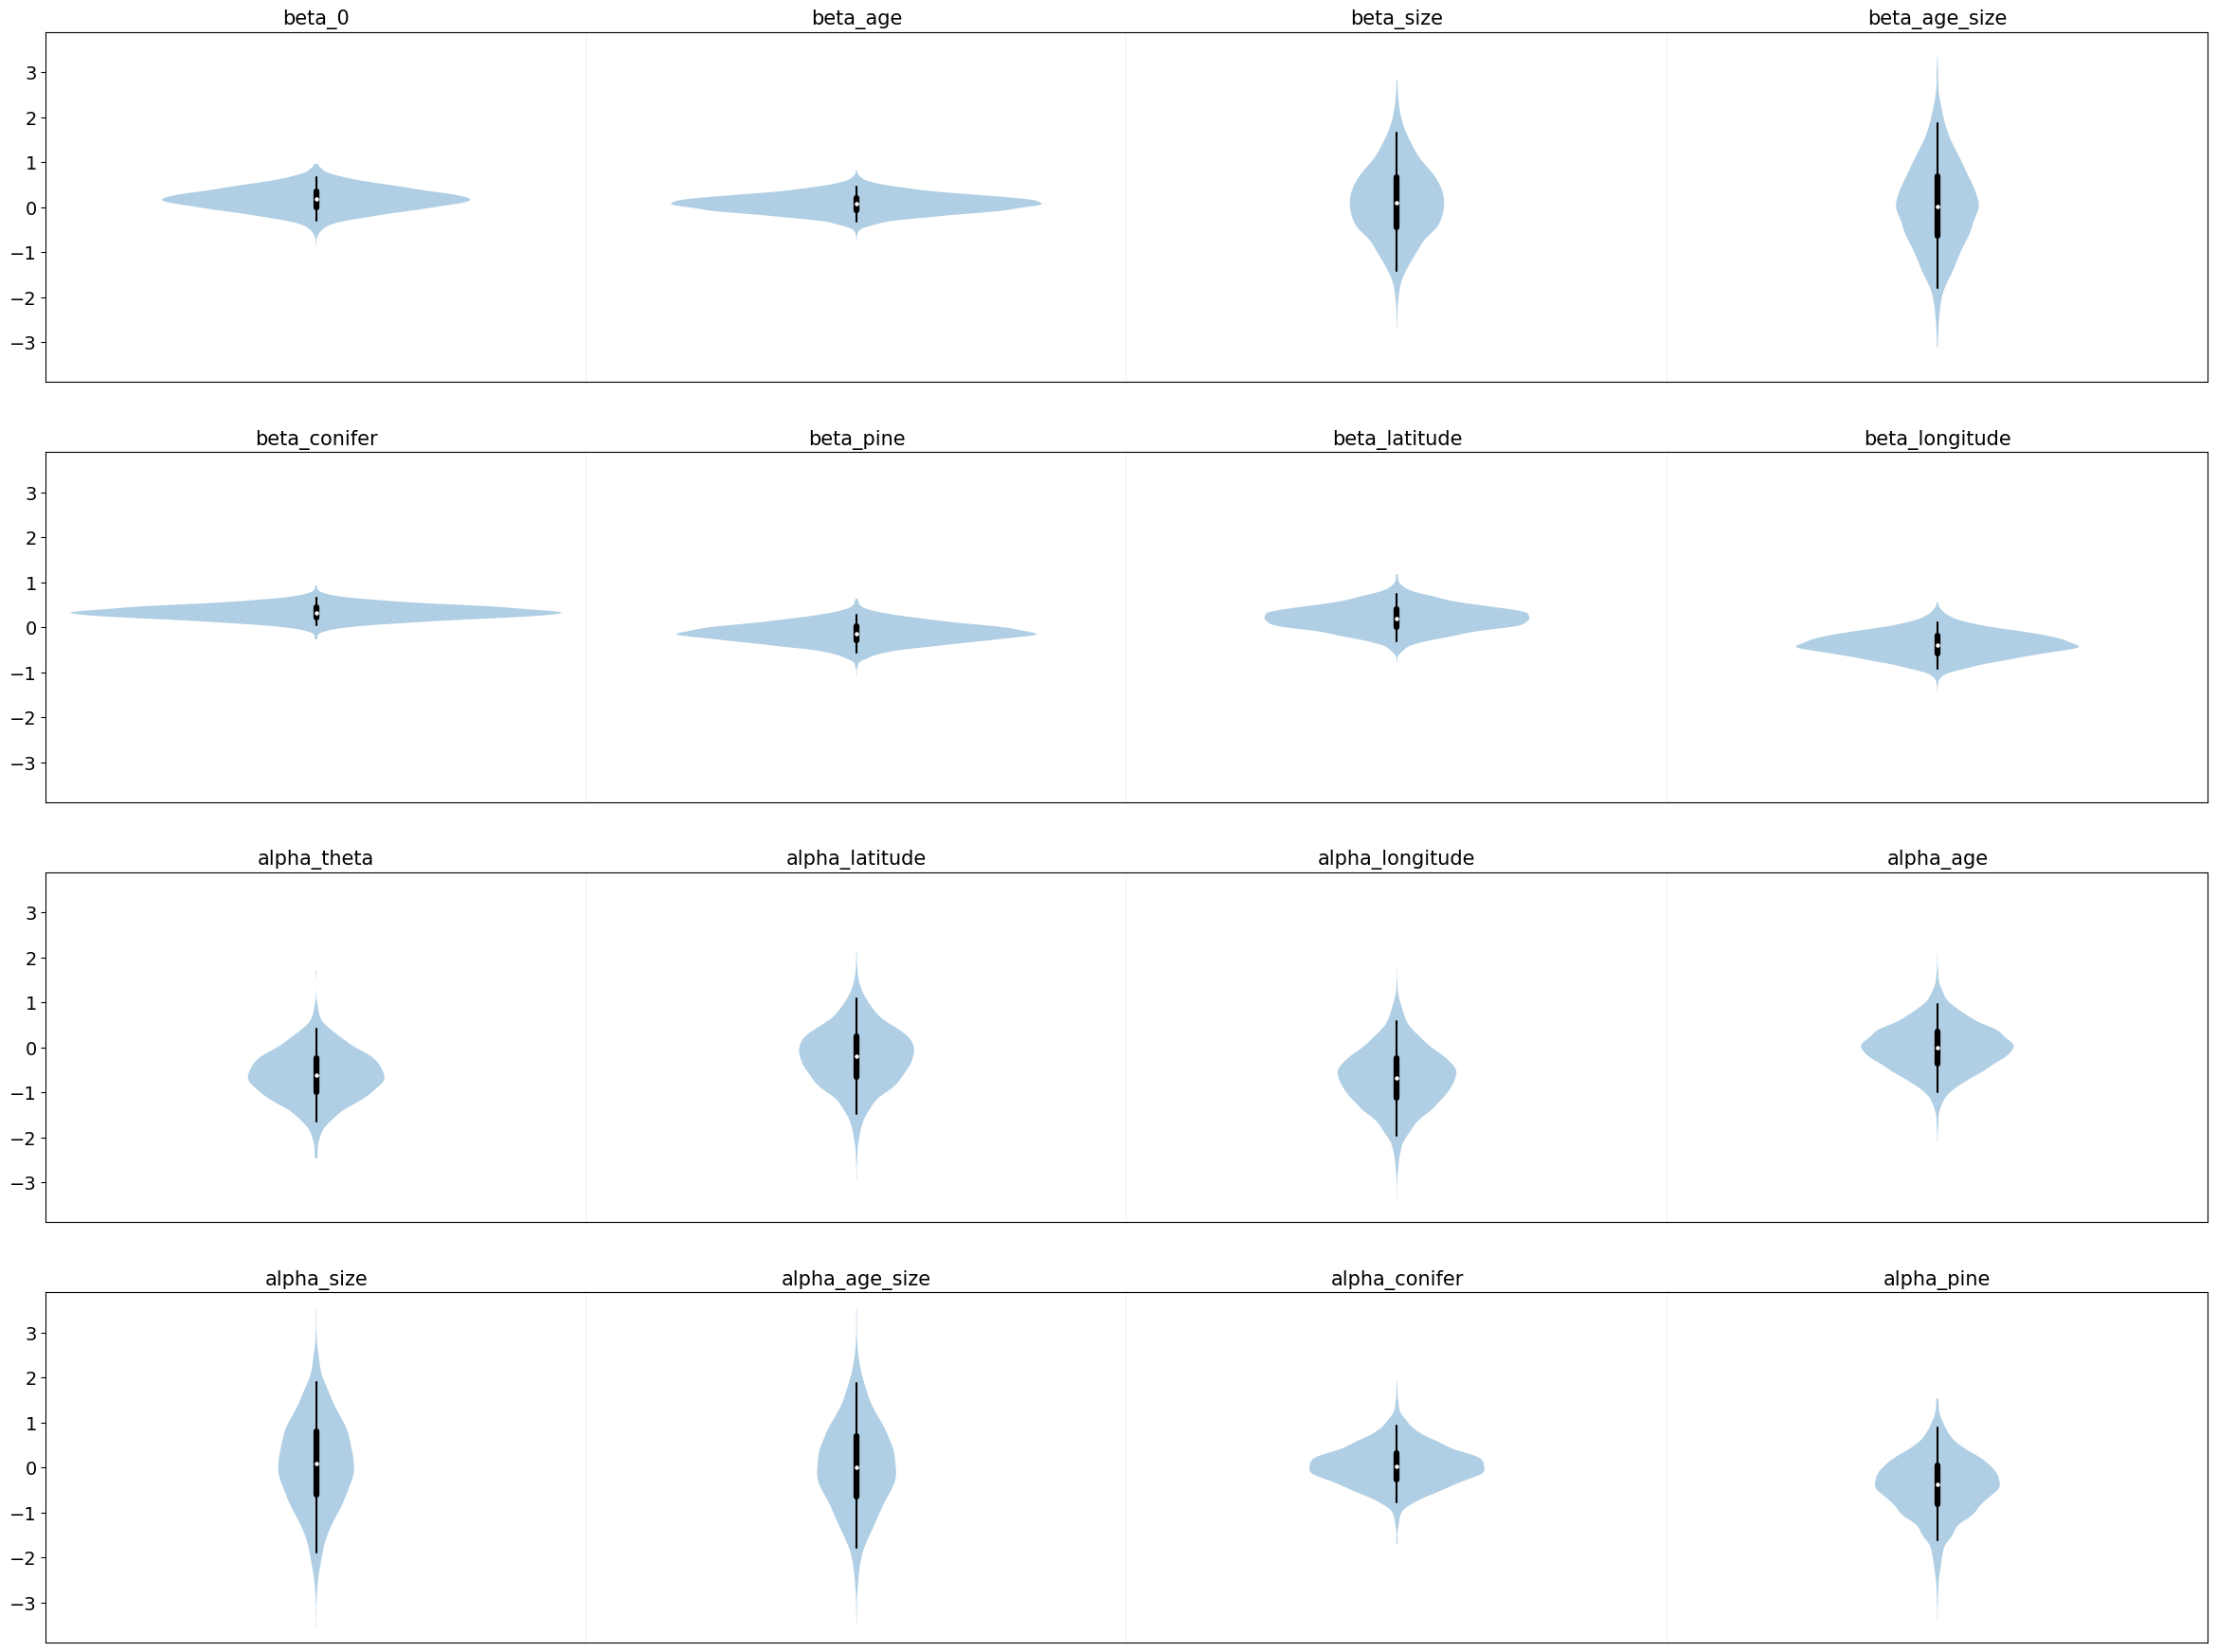

In [177]:
ax = az.plot_violin(TEWA_covs_idata)

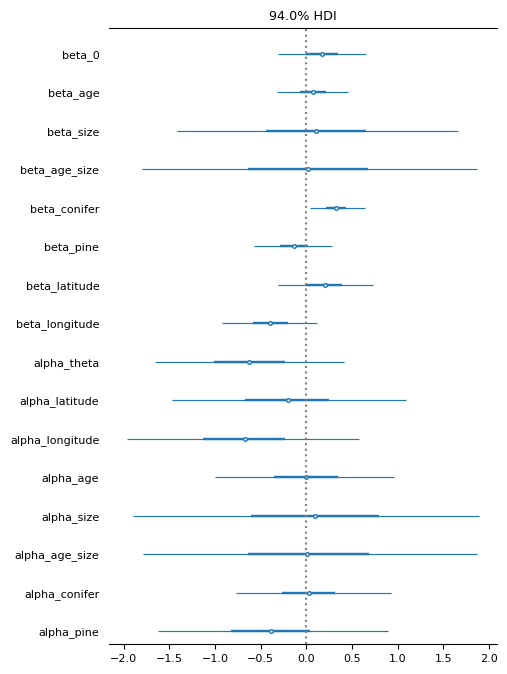

In [178]:
ax = az.plot_forest(TEWA_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

<Axes: xlabel='M / M_pred'>

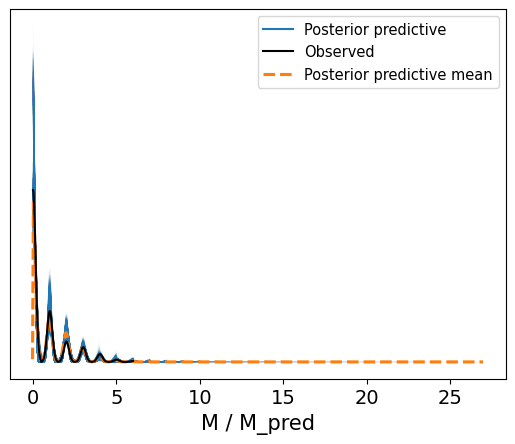

In [219]:
az.plot_ppc(TEWA_covs_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

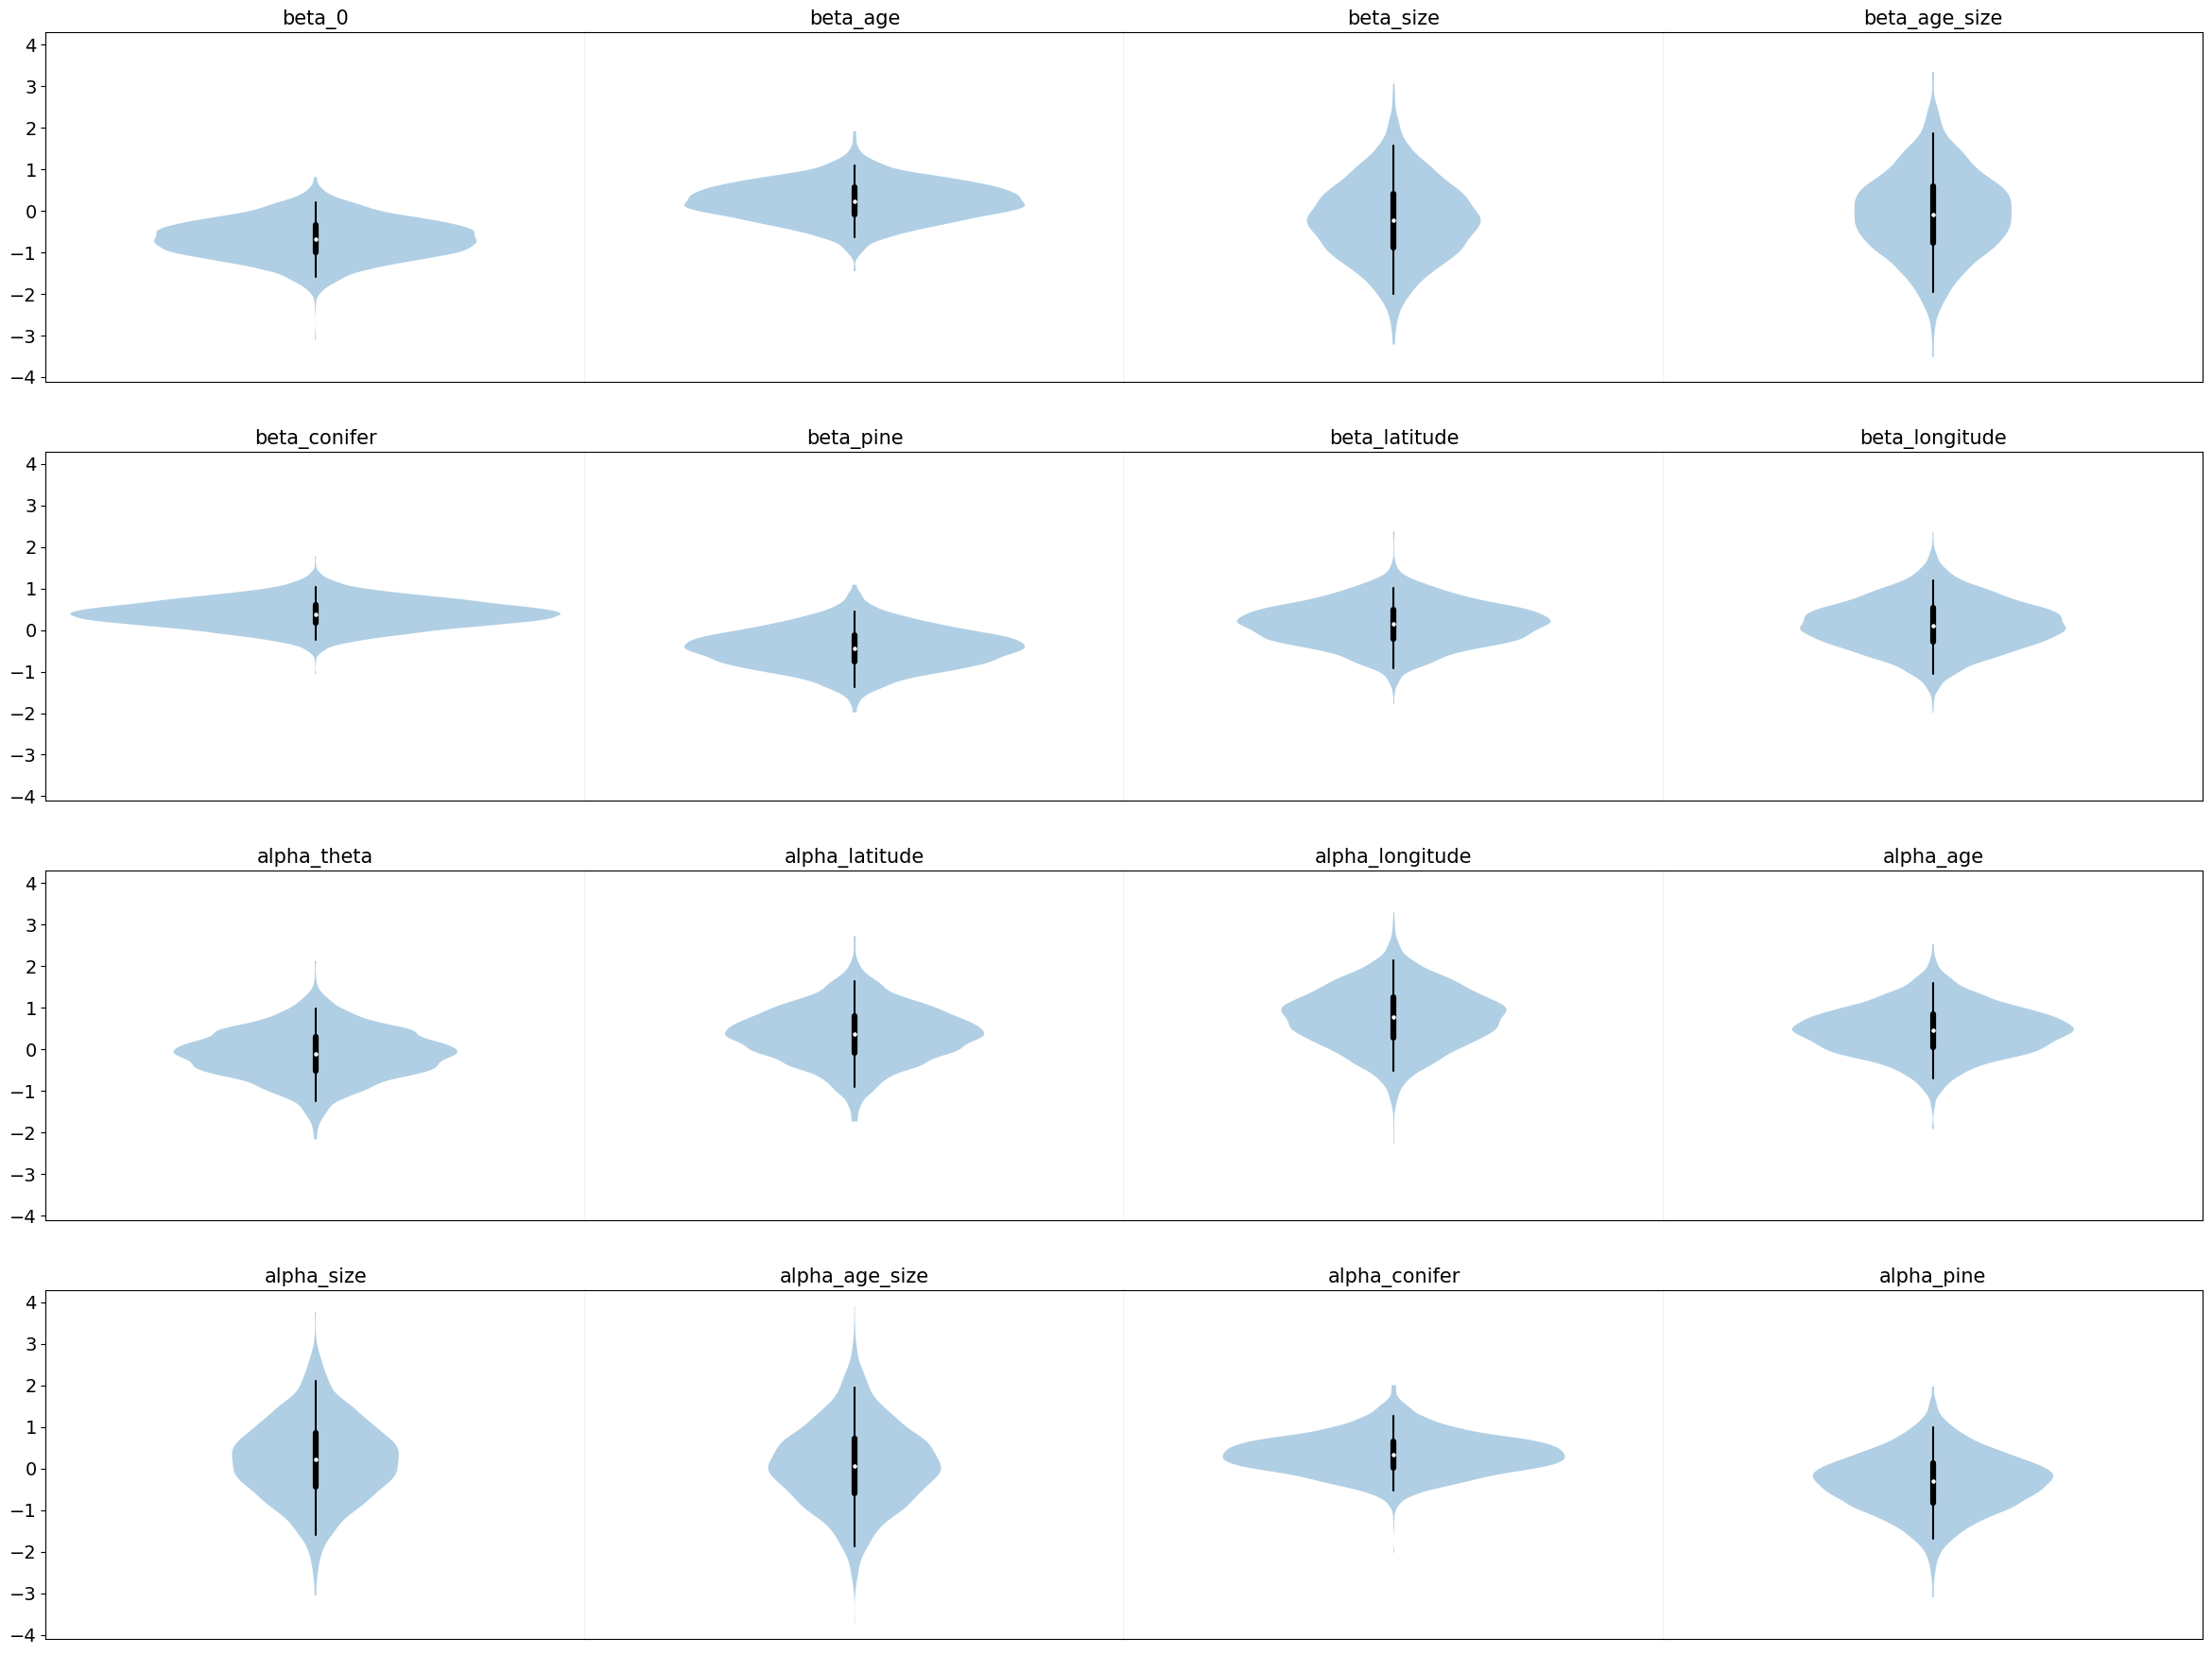

In [190]:
ax = az.plot_violin(RCKI_covs_idata)

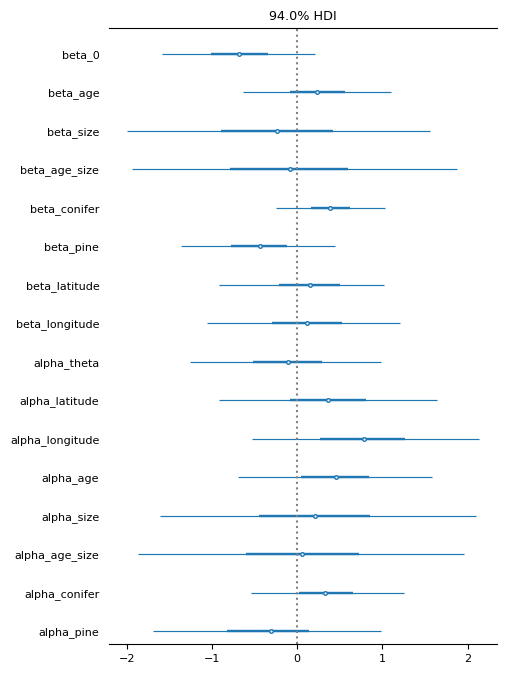

In [191]:
ax = az.plot_forest(RCKI_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

<Axes: xlabel='M / M_pred'>

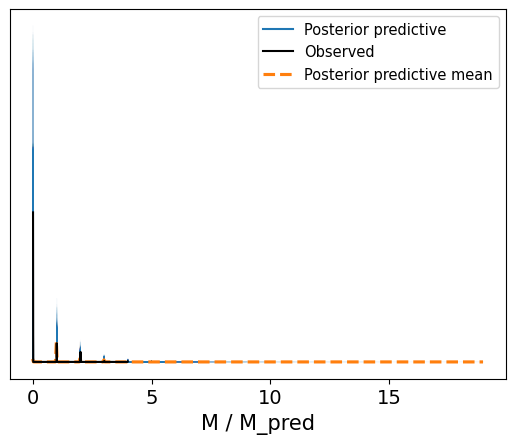

In [220]:
az.plot_ppc(RCKI_covs_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

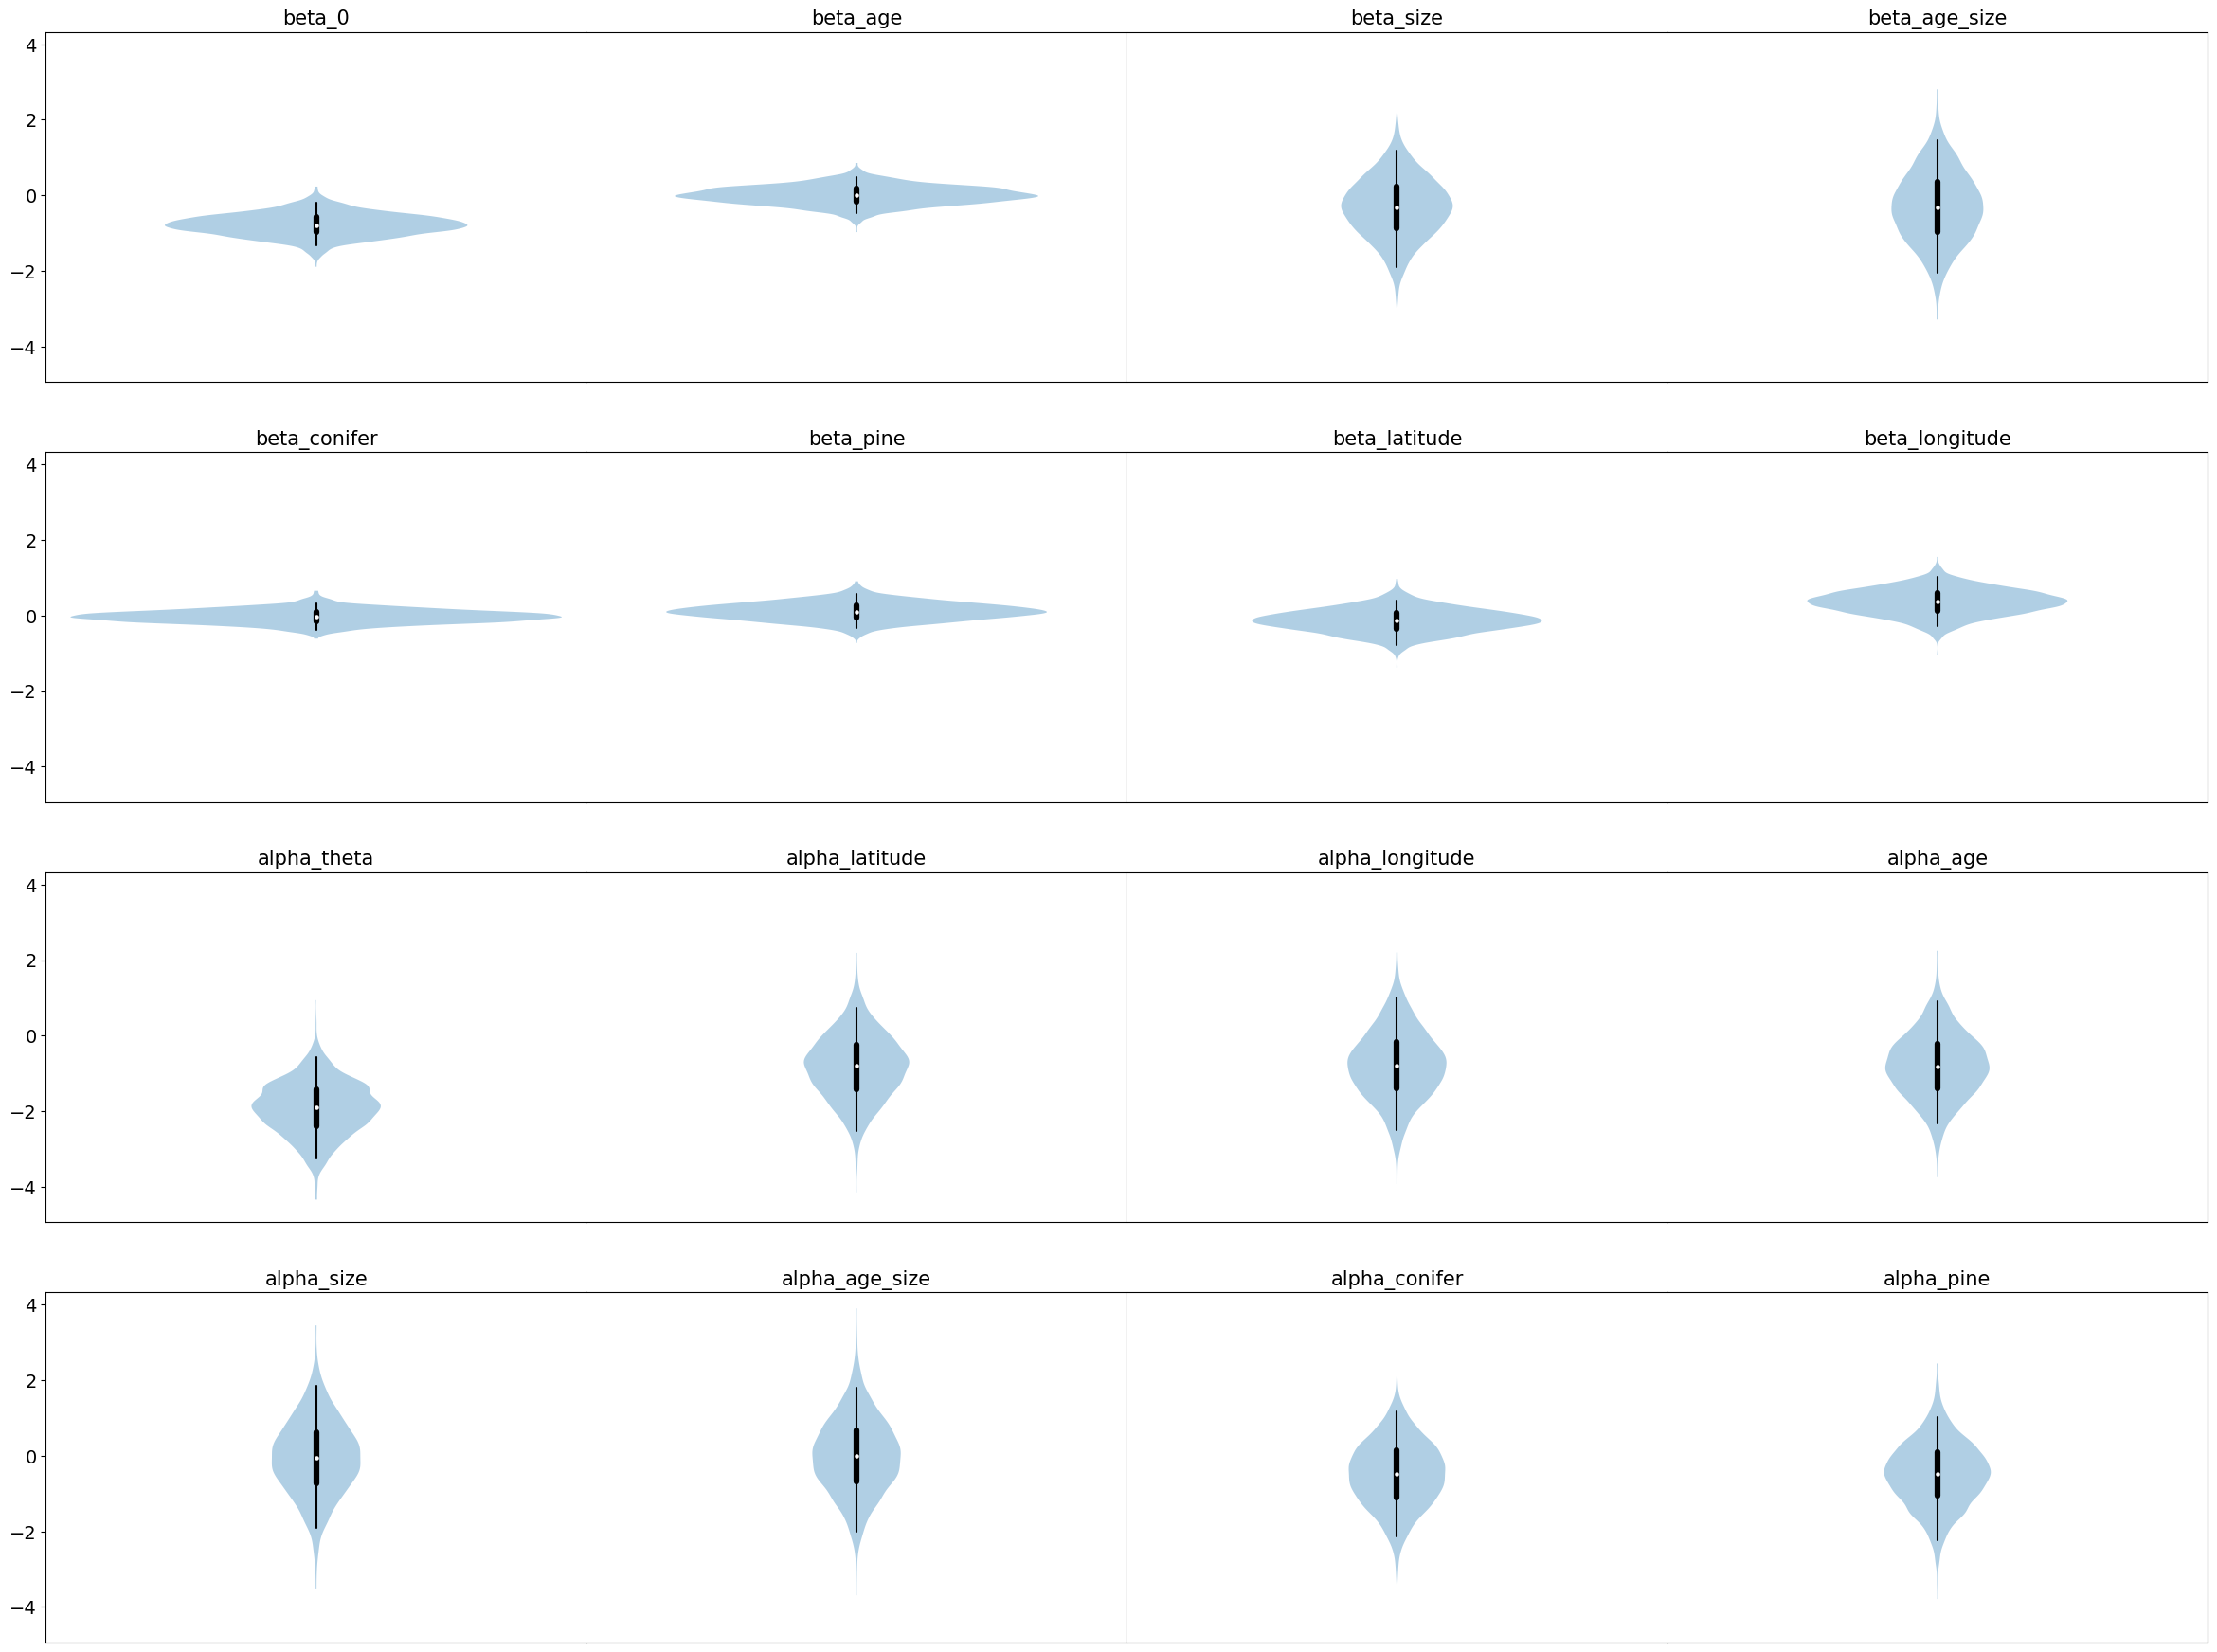

In [203]:
ax = az.plot_violin(YRWA_covs_idata)

<Axes: xlabel='M / M_pred'>

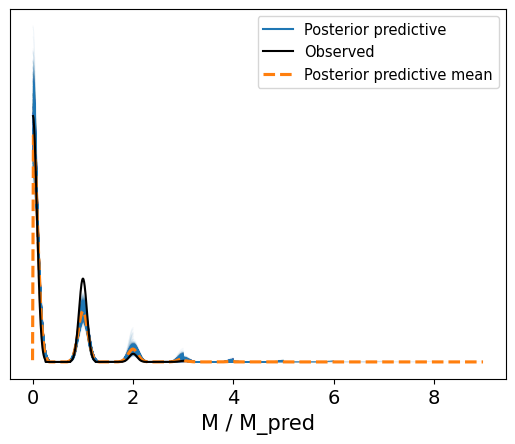

In [221]:
az.plot_ppc(YRWA_covs_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

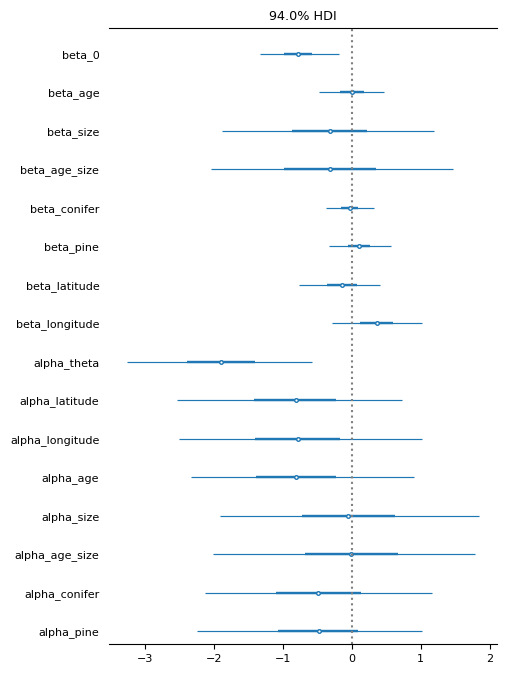

In [204]:
ax = az.plot_forest(YRWA_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

<Axes: xlabel='M / M_pred'>

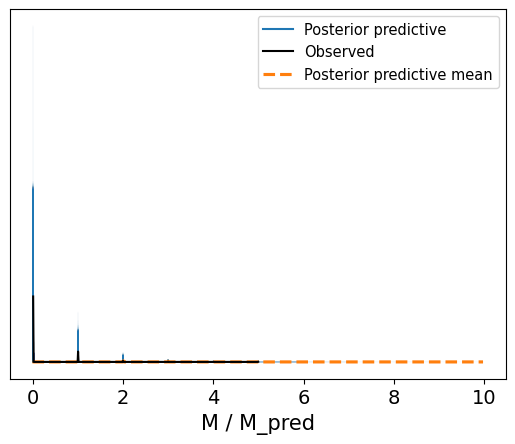

In [222]:
az.plot_ppc(OSFL_covs_idata, data_pairs={"M": "M_pred"}, alpha=0.03, textsize=14)

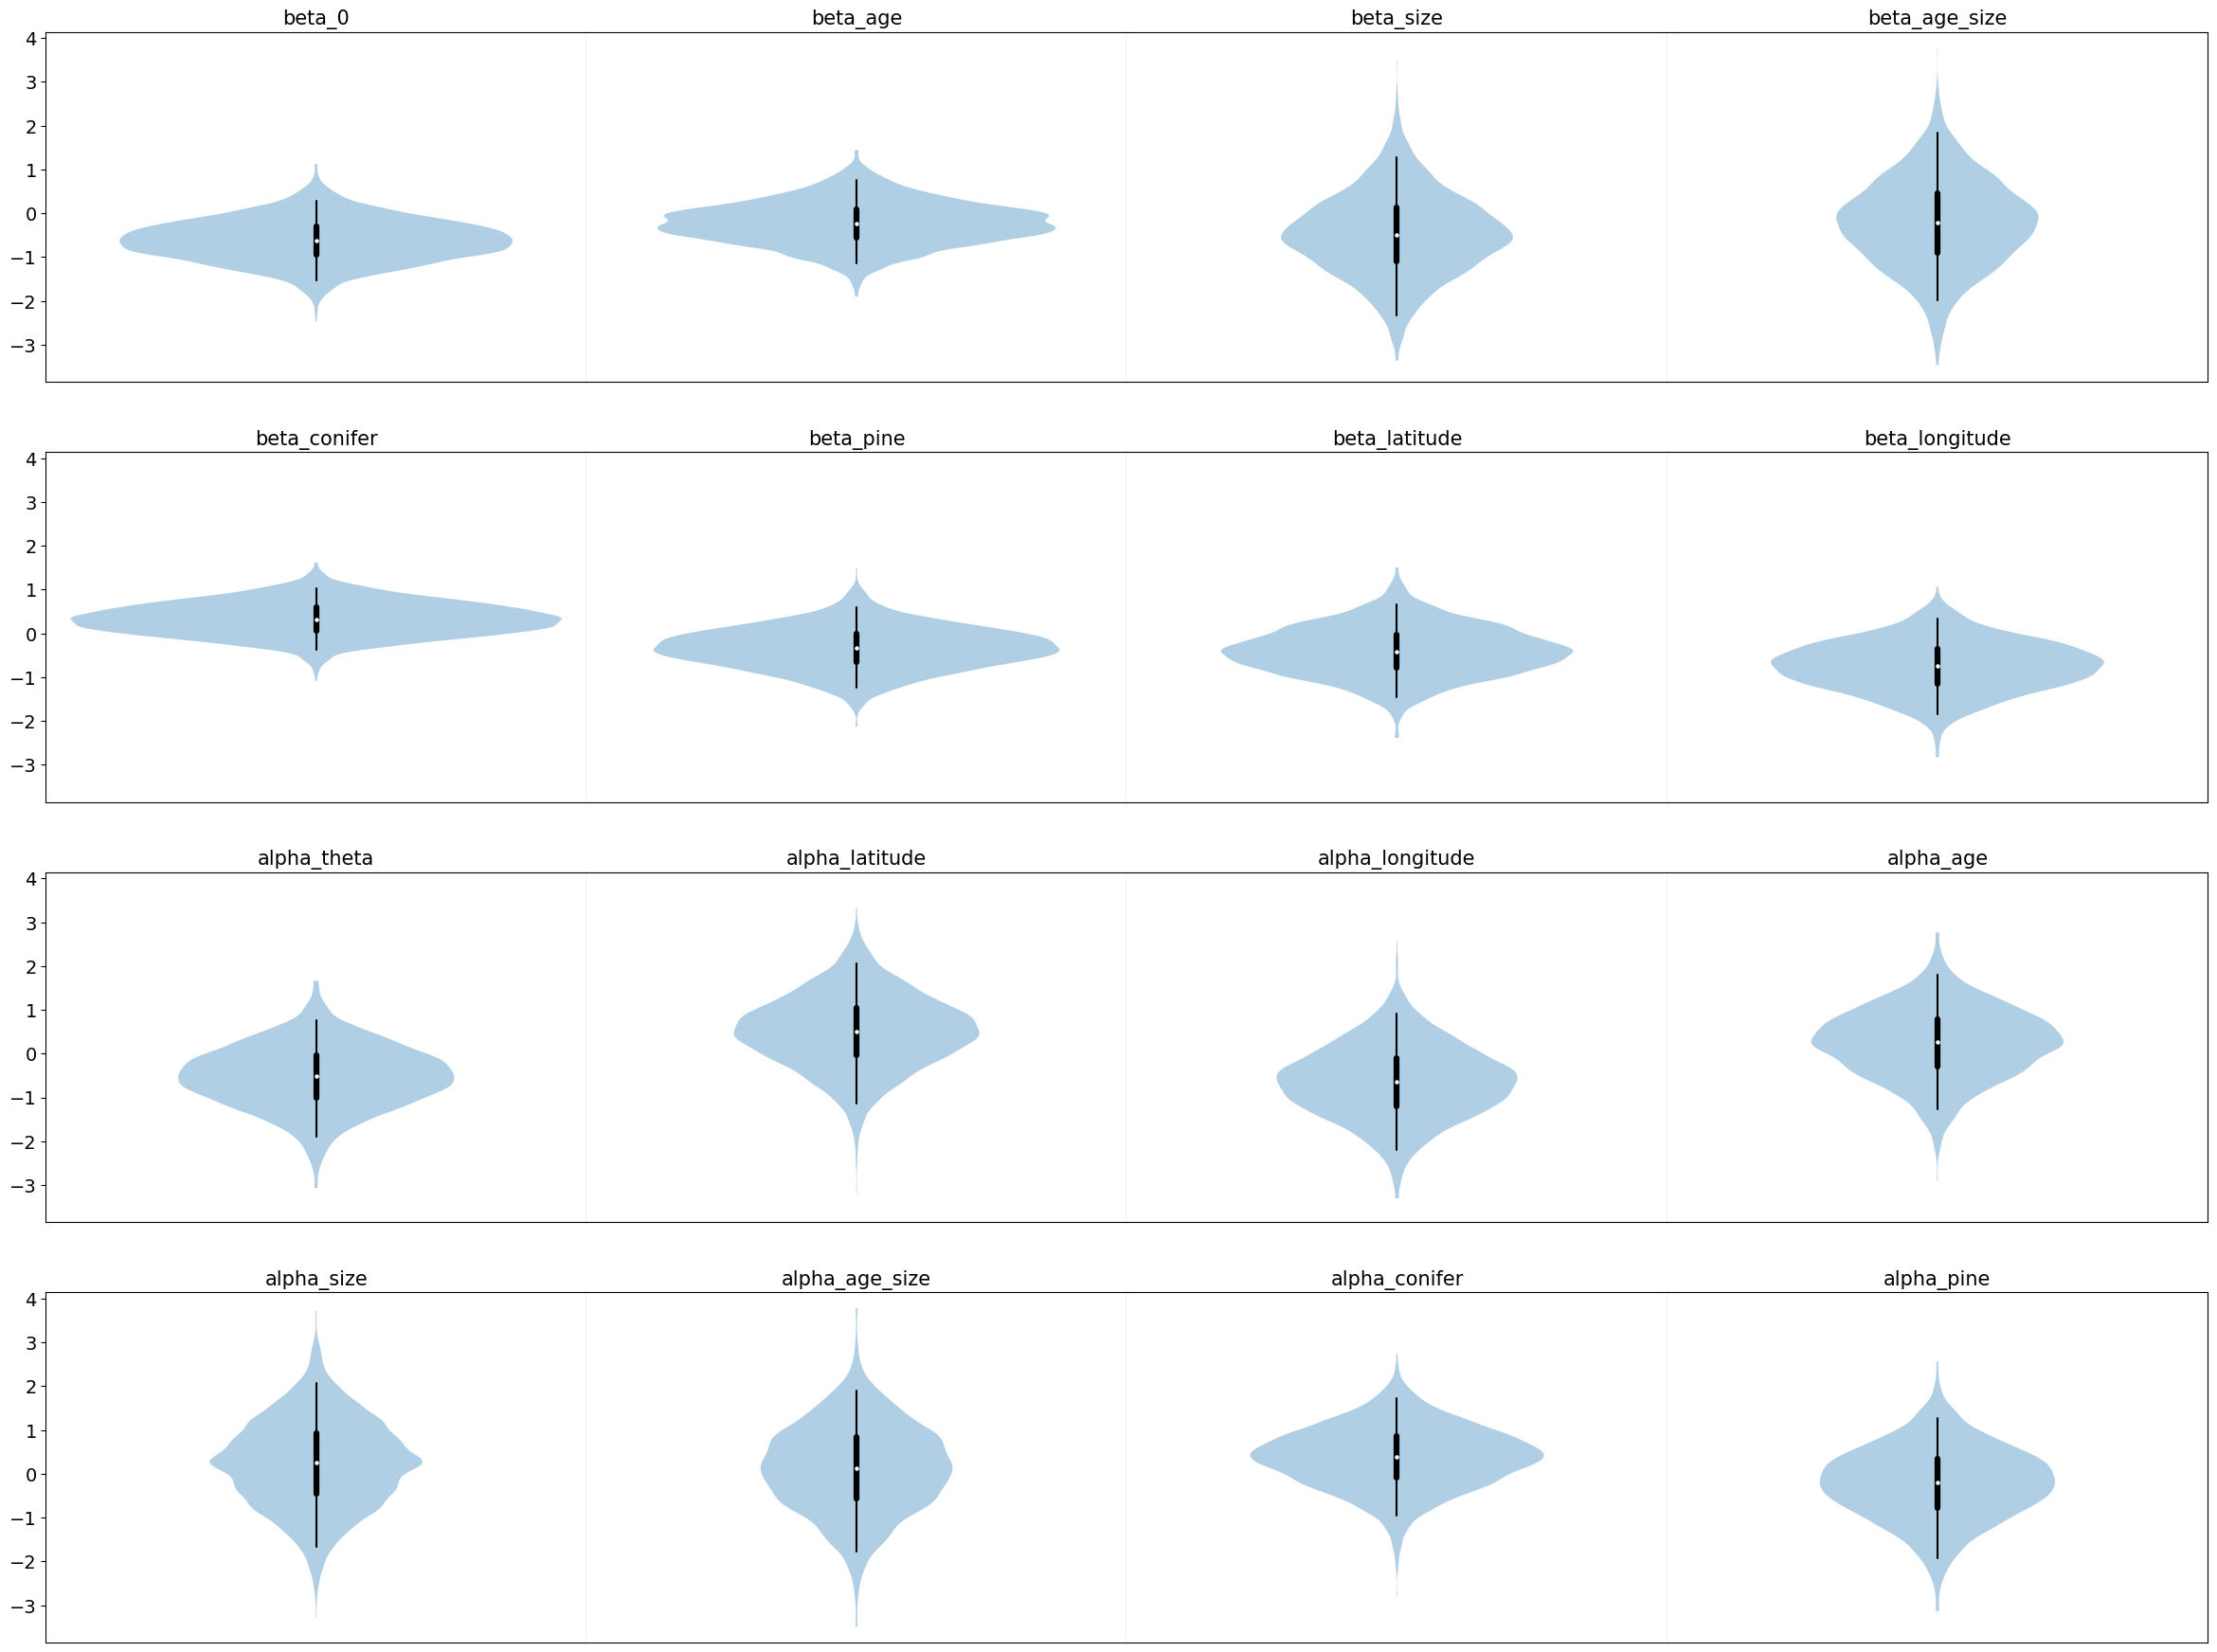

In [215]:
ax = az.plot_violin(OSFL_covs_idata)

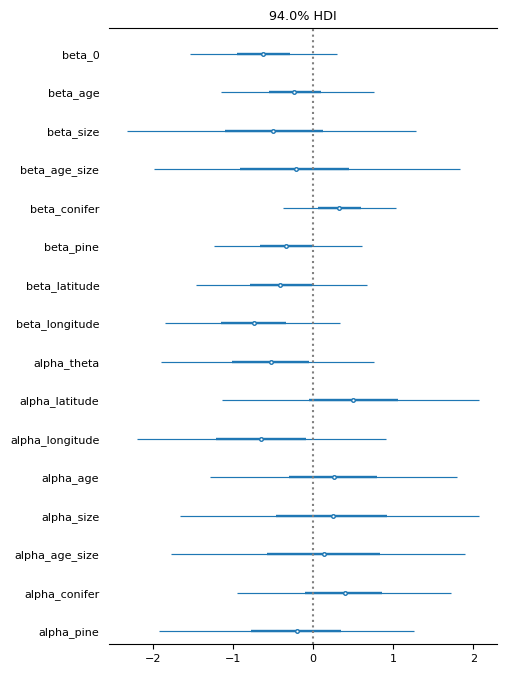

In [216]:
ax = az.plot_forest(OSFL_covs_idata, combined=True,
               figsize=(5, 8), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")

Visualisation of some key draws

### Model C.7.B- Targeted covariates

In [15]:
ZIP_target = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_less_covs.stan"))

In [276]:
ZIP_OSFL_target_100m = ZIP_target.sample(
    data=MinMax_obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

15:47:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:04 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:04 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:07 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:


15:48:09 - cmdstanpy - INFO - CmdStan done processing.


In [277]:
OSFL_100m_idata = az.from_cmdstanpy(
    posterior=ZIP_OSFL_target_100m, 
    posterior_predictive=["M_pred", "lambda_rep"],
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                    "percent_conifer": MinMax_obs_and_covs_dict['percent_conifer'], 
                    "percent_pine": MinMax_obs_and_covs_dict['percent_pine'],
                    "percent_deciduous": MinMax_obs_and_covs_dict['percent_deciduous']},
    log_likelihood="log_lik"
)

In [279]:
OSFL_100m_idata.to_netcdf(os.path.join(idata_path, 'OSFL', 'ZIP_100m.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\OSFL\\ZIP_100m.nc'

In [26]:
WTSP_100m_idata['posterior'].to_netcdf(os.path.join(idata_path, 'WTSP', 'ZIP_posteriors_100m.nc'))

Text(0.5, 1.0, 'OSFL: 100m truncated')

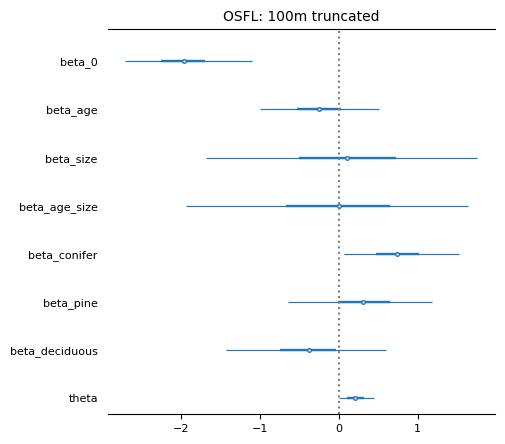

In [280]:
ax = az.plot_forest(OSFL_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('OSFL: 100m truncated', fontsize=10)

Text(0.5, 1.0, 'RCKI: Unlimited distance')

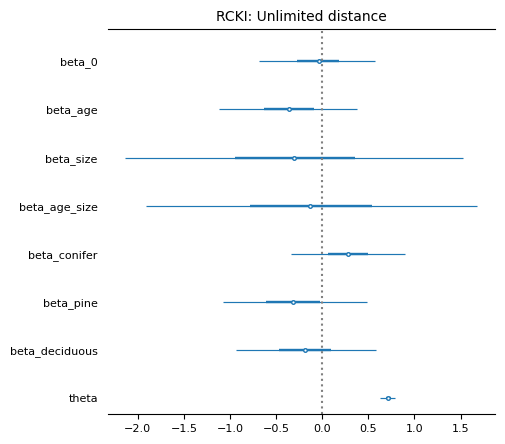

In [136]:
ax = az.plot_forest(RCKI_UNLIMITED_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('RCKI: Unlimited distance', fontsize=10)

Text(0.5, 1.0, 'RCKI: 100m truncated')

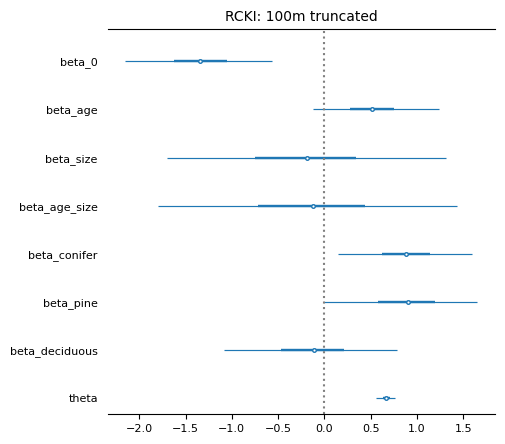

In [262]:

ax = az.plot_forest(RCKI_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('RCKI: 100m truncated', fontsize=10)

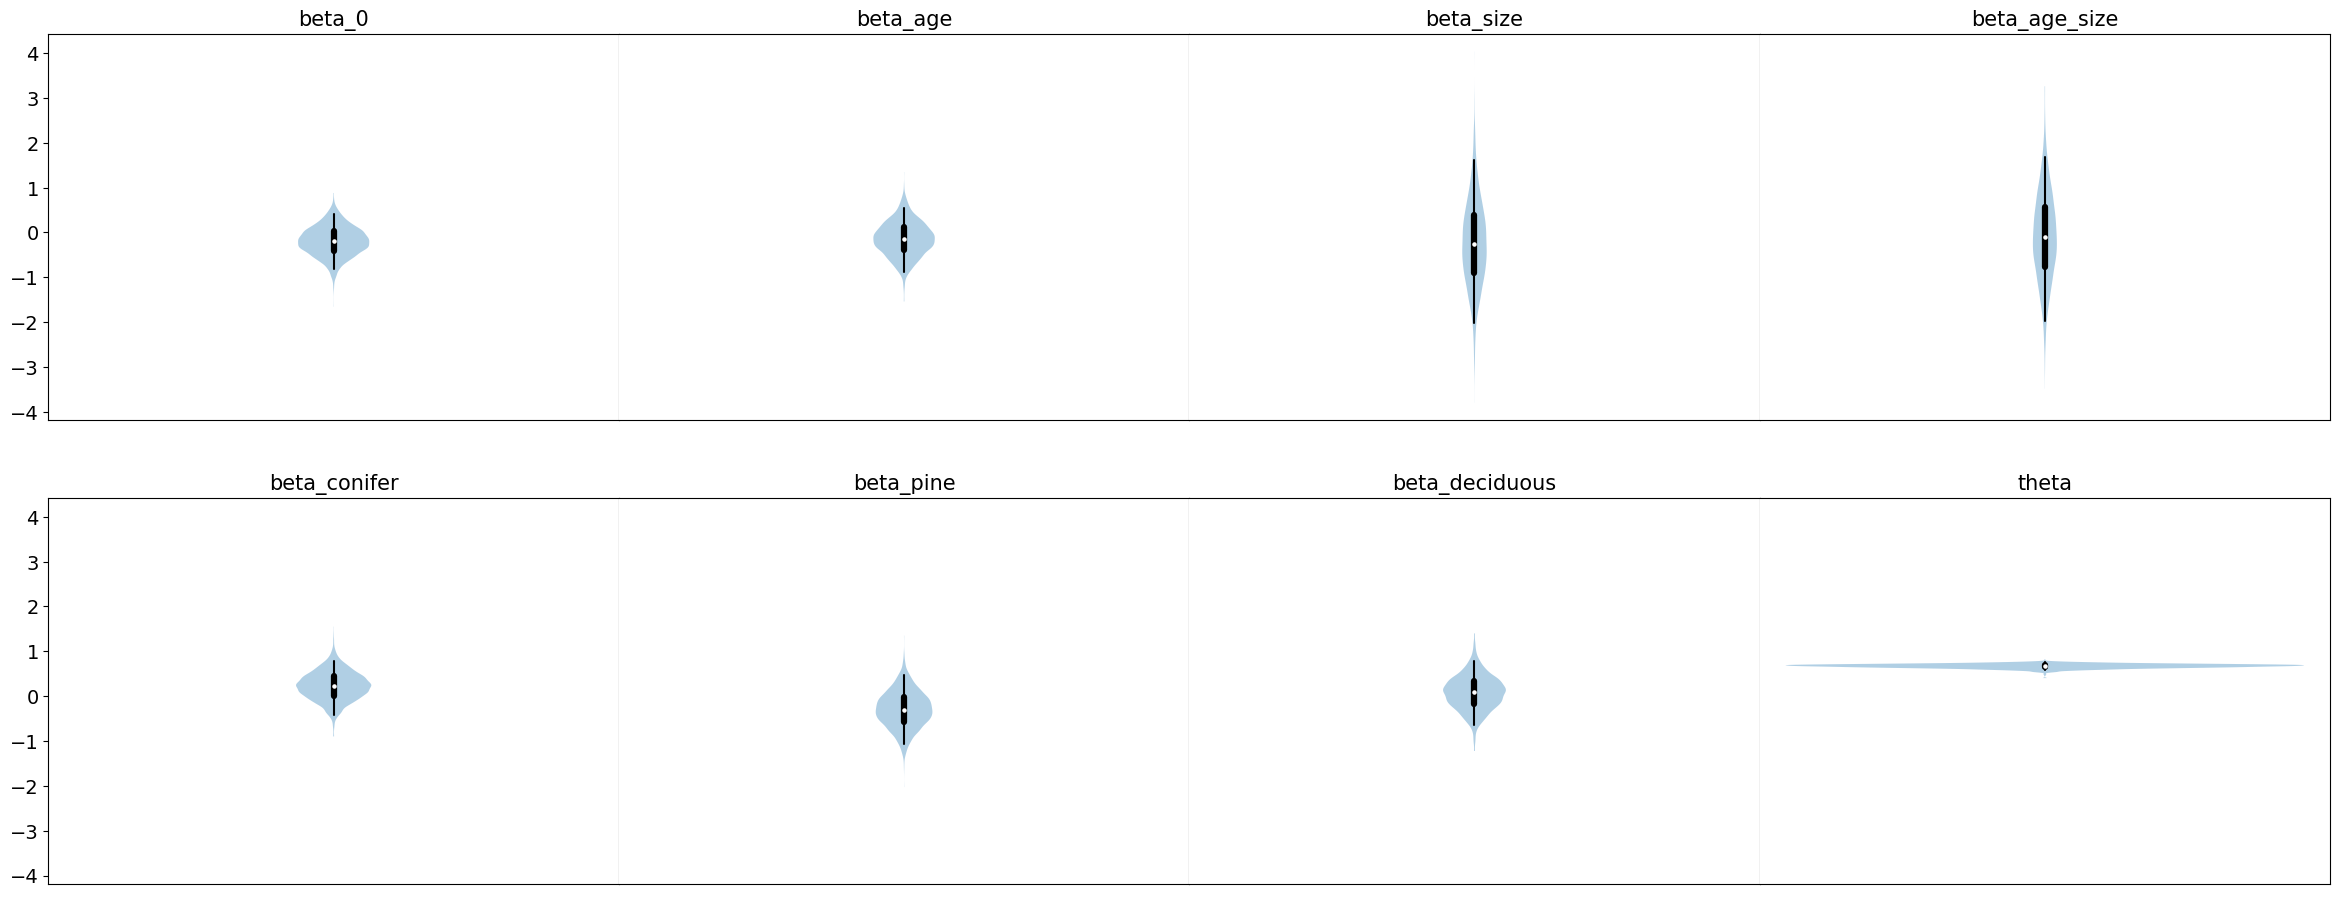

In [64]:
ax = az.plot_violin(RCKI_tar_idata)

Text(0.5, 1.0, 'WTSP: Unlimited distance')

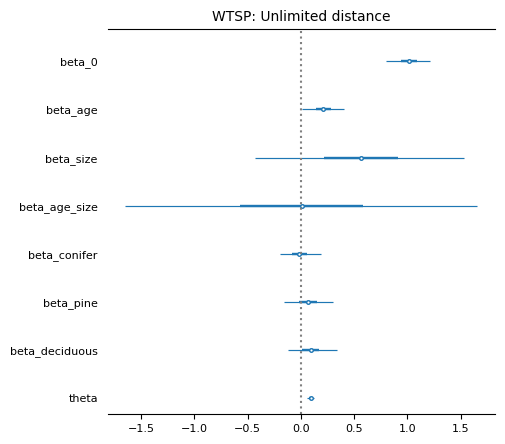

In [56]:
ax = az.plot_forest(WTSP_unlimited_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('WTSP: Unlimited distance', fontsize=10)

Text(0.5, 1.0, 'WTSP: 100m truncated')

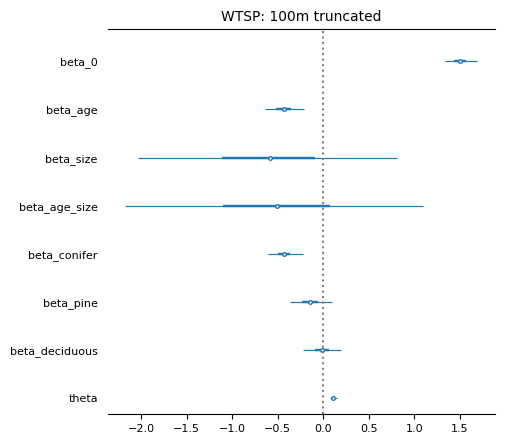

In [241]:

ax = az.plot_forest(WTSP_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('WTSP: 100m truncated', fontsize=10)

Text(0.5, 1.0, 'TEWA: Unlimited distance')

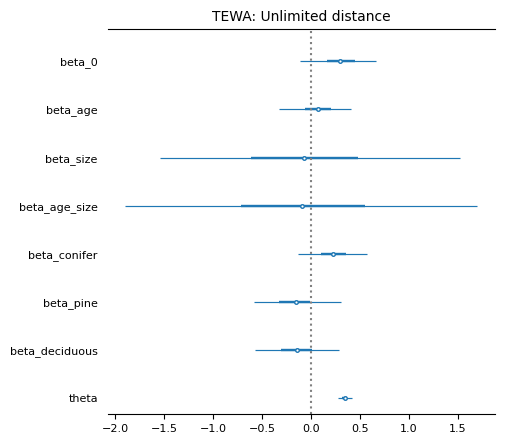

In [78]:
ax = az.plot_forest(TEWA_unlimited_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('TEWA: Unlimited distance', fontsize=10)

Text(0.5, 1.0, 'TEWA: 100m truncated')

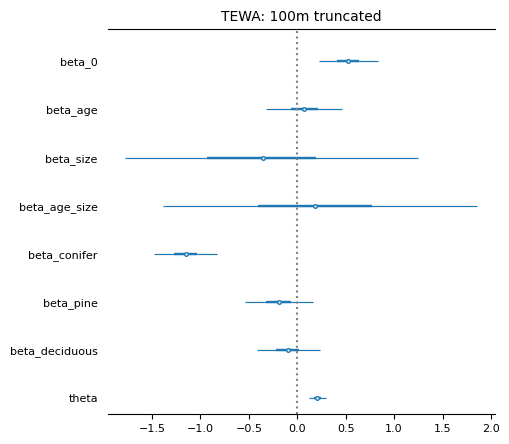

In [208]:
ax = az.plot_forest(TEWA_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('TEWA: 100m truncated', fontsize=10)

Text(0.5, 1.0, 'REVI: Unlimited distance')

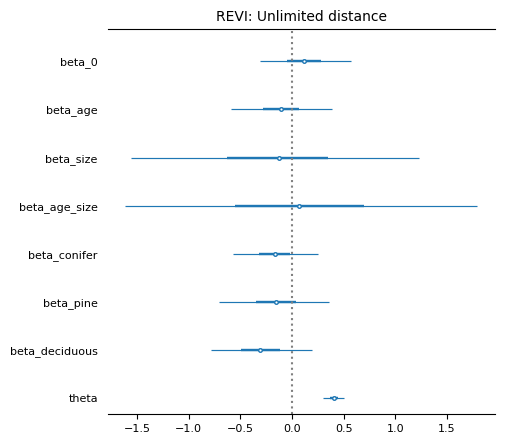

In [48]:
ax = az.plot_forest(REVI_unlimited_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('REVI: Unlimited distance', fontsize=10)

Text(0.5, 1.0, 'REVI: 100m truncated')

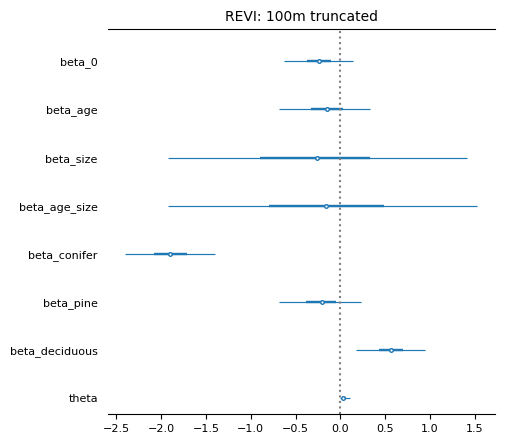

In [221]:

ax = az.plot_forest(REVI_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('REVI: 100m truncated', fontsize=10)

Text(0.5, 1.0, 'YRWA: Unlimited distance')

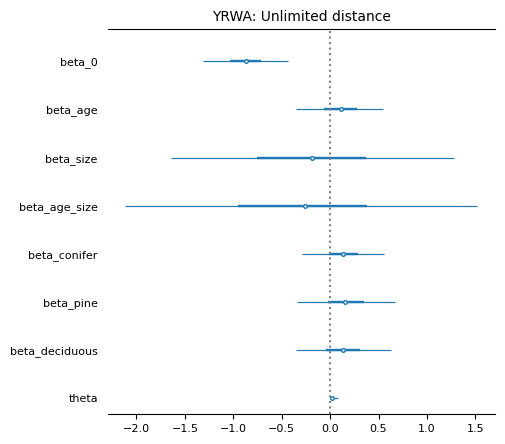

In [63]:
ax = az.plot_forest(YRWA_unlimited_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('YRWA: Unlimited distance', fontsize=10)

Text(0.5, 1.0, 'YRWA: 100m truncated')

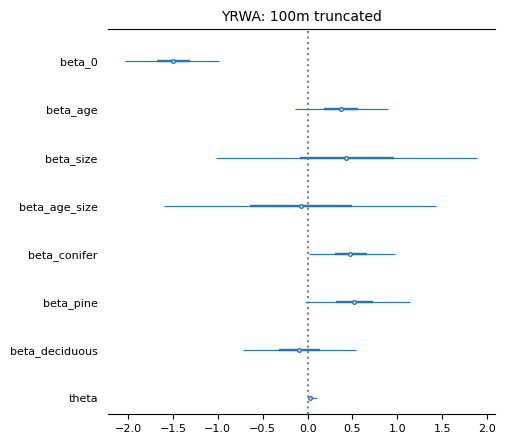

In [189]:

ax = az.plot_forest(YRWA_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('YRWA: 100m truncated', fontsize=10)

### C.8 - ZIP with neighbour effect

In [70]:
ZIP_neighbour = CmdStanModel(stan_file=os.path.join(stan_path, "ZIP_neighbour.stan"))

16:49:10 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_neighbour.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_neighbour.exe
16:49:34 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Model\ZIP_neighbour.exe
16:49:34 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
16:49:34 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_neighbour.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_neighbour.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Model/ZIP_neighbour.stan', line 80, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
   

In [71]:
ZIP_WTSP_neigh_100m = ZIP_neighbour.sample(
    data=MinMax_obs_and_covs_dict,
    parallel_chains=4,
    show_console=False)

16:49:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:09 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:14 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:19 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:24 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:28 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:32 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:35 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:39 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████▍    | 00:44 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████▉    | 00:50 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:56 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 01:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 01:08 Iteration: 1300 / 2000 [ 65%]  (Sampling)





chain 1 |███████▋ 


16:51:31 - cmdstanpy - INFO - CmdStan done processing.


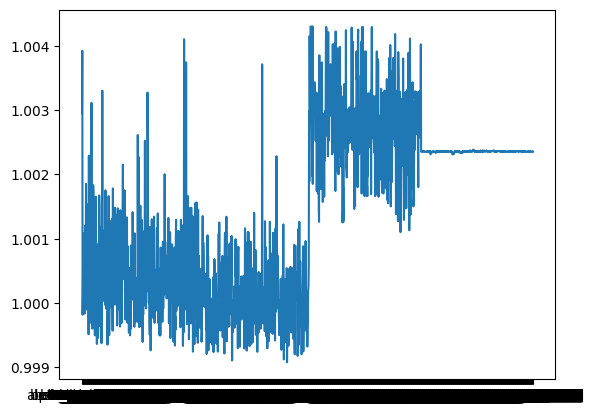

In [45]:
plt.plot(ZIP_WTSP_neigh_100m.summary()['R_hat'])

In [72]:
WTSP_neigh_100m_idata = az.from_cmdstanpy(
    posterior=ZIP_WTSP_neigh_100m, 
    posterior_predictive=["M_pred", "lambda_rep", "theta_rep"],
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                    "percent_conifer": MinMax_obs_and_covs_dict['percent_conifer'], 
                    "percent_pine": MinMax_obs_and_covs_dict['percent_pine'],
                    "percent_deciduous": MinMax_obs_and_covs_dict['percent_deciduous'],
                    "neighbour": MinMax_obs_and_covs_dict['neighbour']},
    log_likelihood="log_lik"
)

In [93]:
WTSP_neigh_100m_idata.to_netcdf(os.path.join(idata_path, 'WTSP', 'neighbour_ZIP_100m.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Model\\Inference Data\\WTSP\\neighbour_ZIP_100m.nc'

In [73]:
WTSP_neigh_100m_idata


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [94]:
az.waic(WTSP_neigh_100m_idata)

Computed from 4000 posterior samples and 392 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -874.19     3.02
p_waic      155.55        -

There has been a warning during the calculation. Please check the results.

In [47]:
az.waic(WTSP_neigh_100m_idata)

Computed from 4000 posterior samples and 392 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1265.85     2.00
p_waic      222.19        -

There has been a warning during the calculation. Please check the results.

In [74]:
az.waic(WTSP_neigh_100m_idata)

Computed from 4000 posterior samples and 392 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -887.09     2.46
p_waic      156.27        -

There has been a warning during the calculation. Please check the results.

Text(0.5, 1.0, 'WTSP: 100m truncated')

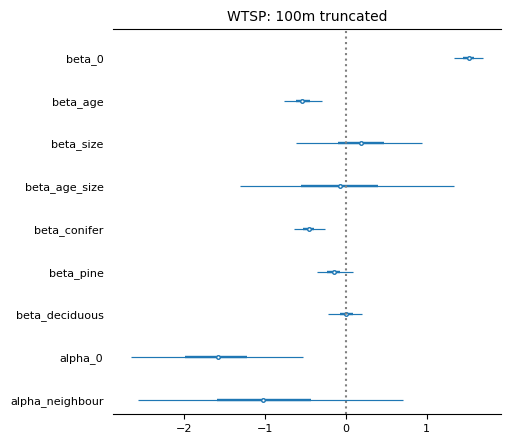

In [95]:
ax = az.plot_forest(WTSP_neigh_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('WTSP: 100m truncated', fontsize=10)

Text(0.5, 1.0, 'WTSP: 100m truncated')

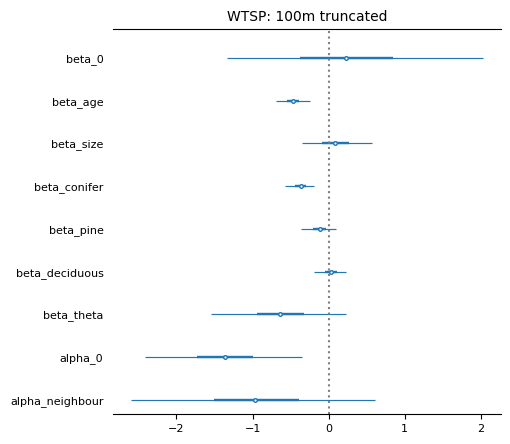

In [75]:
ax = az.plot_forest(WTSP_neigh_100m_idata, combined=True,
               figsize=(5, 5), textsize=8)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title('WTSP: 100m truncated', fontsize=10)

### D. Visualising target posteriors

In [27]:
WTSP_100m_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [32]:
WTSP_100m_idata['posterior']["beta_0"]

<xarray.DataArray 'beta_0' (chain: 4, draw: 1000)>
array([[0.771092, 0.983501, 0.797566, ..., 0.748411, 0.758408, 1.04778 ],
       [1.13155 , 1.09093 , 0.920434, ..., 0.884565, 0.882696, 0.81239 ],
       [0.946123, 0.968796, 0.884622, ..., 1.15671 , 1.14544 , 1.06687 ],
       [1.00291 , 0.960355, 0.825918, ..., 1.1033  , 0.995226, 1.14359 ]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [30]:


# Load the arviz inference data object from the NetCDF file
inference_data = WTSP_100m_idata

# Extract posterior samples for the relevant coefficients
# posterior_samples = inference_data.posterior
beta_0_samples = WTSP_100m_idata['posterior']["beta_0"].values.flatten()
beta_age_samples = WTSP_100m_idata['posterior']["beta_age"].values.flatten()
beta_size_samples = WTSP_100m_idata['posterior']["beta_size"].values.flatten()
beta_age_size_samples = WTSP_100m_idata['posterior']["beta_age_size"].values.flatten()

# Set size to 0 as specified
size_value = 0

# Evaluate the rate of change in lambda against a range of age values

age_values = np.linspace(min(WTSP_100m_idata.constant_data["age"].values), 
                         max(WTSP_100m_idata.constant_data["age"].values), 
                         100)

# Compute lambda's rate of change for each posterior sample and for each age value
lambda_rate_of_change = np.array([
    (beta_age + beta_age_size * size_value) * np.exp(beta_age * age_values + beta_age_size * age_values * size_value + b0 + beta_size * size_value)
    for beta_age, beta_age_size, b0, beta_size in zip(beta_age_samples, beta_age_size_samples, beta_0_samples, beta_size_samples)
])

# Compute the mean and the 95% credible interval for lambda's rate of change
mean_rate_of_change = np.mean(lambda_rate_of_change, axis=0)
lower_bound = np.percentile(lambda_rate_of_change, 2.5, axis=0)
upper_bound = np.percentile(lambda_rate_of_change, 97.5, axis=0)

mean_rate_of_change, lower_bound, upper_bound


(array([0.4969753 , 0.49828835, 0.49960532, 0.50092622, 0.50225107,
        0.50357989, 0.50491268, 0.50624945, 0.50759023, 0.50893503,
        0.51028385, 0.51163671, 0.51299363, 0.51435462, 0.5157197 ,
        0.51708887, 0.51846215, 0.51983956, 0.5212211 , 0.5226068 ,
        0.52399666, 0.52539071, 0.52678895, 0.5281914 , 0.52959807,
        0.53100898, 0.53242415, 0.53384358, 0.53526729, 0.53669529,
        0.53812761, 0.53956425, 0.54100522, 0.54245056, 0.54390026,
        0.54535434, 0.54681283, 0.54827572, 0.54974305, 0.55121482,
        0.55269104, 0.55417175, 0.55565693, 0.55714663, 0.55864084,
        0.56013959, 0.56164289, 0.56315075, 0.5646632 , 0.56618024,
        0.56770189, 0.56922818, 0.5707591 , 0.57229469, 0.57383495,
        0.57537991, 0.57692957, 0.57848396, 0.58004309, 0.58160697,
        0.58317563, 0.58474907, 0.58632732, 0.58791039, 0.5894983 ,
        0.59109107, 0.5926887 , 0.59429123, 0.59589866, 0.59751101,
        0.5991283 , 0.60075054, 0.60237776, 0.60

(array([  1318.,   2604.,   5448.,   6307.,  18940.,  35130.,  40809.,
         63348.,  89456., 107626., 117289., 141942., 147187., 143459.,
        127120., 116973., 107110.,  88635.,  65960.,  45946.,  39394.,
         18358.,  18594.,   7010.,   5315.,   4352.,   1582.,    396.,
             0.,    392.]),
 array([0.0556321 , 0.06090783, 0.06618356, 0.07145929, 0.07673502,
        0.08201075, 0.08728648, 0.09256221, 0.09783794, 0.10311367,
        0.1083894 , 0.11366513, 0.11894086, 0.12421659, 0.12949232,
        0.13476805, 0.14004378, 0.14531951, 0.15059524, 0.15587097,
        0.1611467 , 0.16642243, 0.17169816, 0.17697389, 0.18224962,
        0.18752535, 0.19280108, 0.19807681, 0.20335254, 0.20862827,
        0.213904  ]),
 <BarContainer object of 30 artists>)

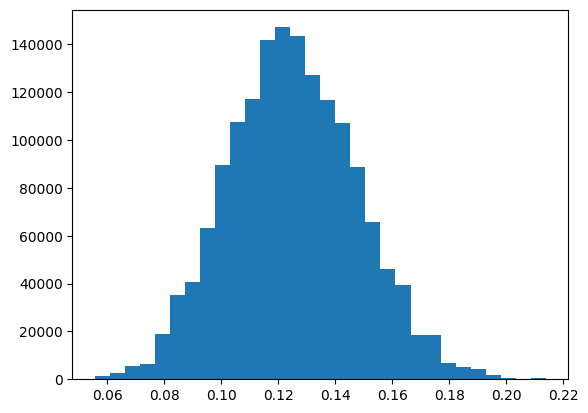

In [83]:
# az.plot_density(WTSP_neigh_100m_idata, var_names='theta_rep', group='posterior_predictive')
theta = WTSP_neigh_100m_idata['posterior_predictive']["theta_rep"].values.flatten()
ax = plt.hist(theta, bins = 30)
ax

In [77]:
WTSP_neigh_100m_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

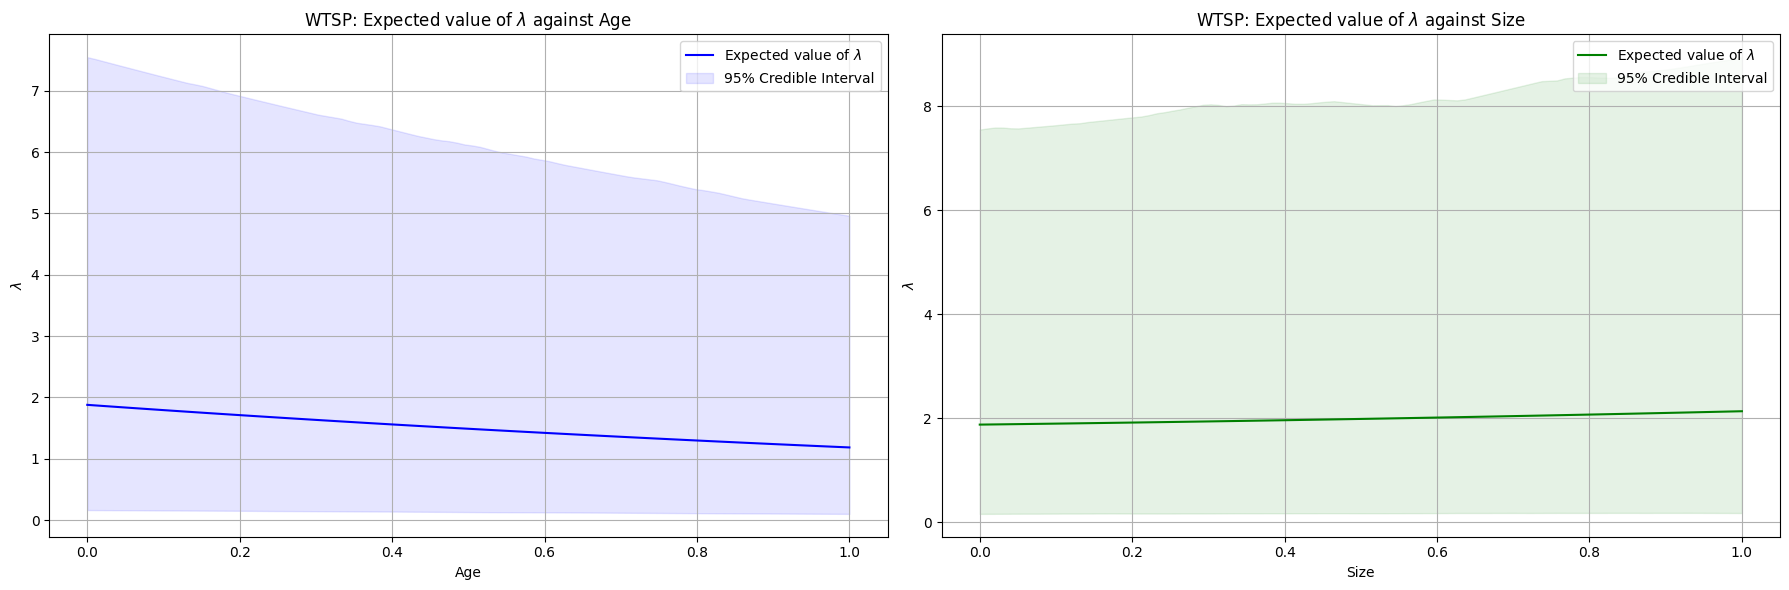

In [88]:

# Extract posterior samples for the relevant coefficients
BIRD_idata = WTSP_neigh_100m_idata
beta_0_samples = BIRD_idata['posterior']["beta_0"].values.flatten()
beta_age_samples = BIRD_idata['posterior']["beta_age"].values.flatten()
beta_size_samples = BIRD_idata['posterior']["beta_size"].values.flatten()
beta_theta_samples = BIRD_idata['posterior']["beta_theta"].values.flatten()


# Evaluate the rate of change in lambda against a range of age values

age_values = np.linspace(min(BIRD_idata.constant_data["age"].values), 
                         max(BIRD_idata.constant_data["age"].values), 
                         100)

size_values = np.linspace(min(BIRD_idata.constant_data["size"].values), 
                         max(BIRD_idata.constant_data["size"].values), 
                         100)

theta = WTSP_neigh_100m_idata['posterior_predictive']["theta_rep"].values.flatten()
mean_theta = np.mean(theta, axis=0)

# Compute lambda for each posterior sample and for each age value
# Set size to 0 as specified
size_constant_value = 0
lambda_values_age = np.array([
    np.exp(beta_age * age_values + beta_theta * mean_theta + b0 + beta_size * size_constant_value)
    for beta_age, beta_theta, b0, beta_size in zip(beta_age_samples, beta_theta_samples, beta_0_samples, beta_size_samples)
])

# Compute the mean and the 95% credible interval for lambda
mean_lambda_age = np.mean(lambda_values_age, axis=0)
lower_bound_lambda = np.percentile(lambda_values_age, 2.5, axis=0)
upper_bound_lambda = np.percentile(lambda_values_age, 97.5, axis=0)


# Correctly compute lambda for each posterior sample and for a range of size values, keeping age constant
age_constant_value = 0
lambda_values_size = np.array([
    np.exp(beta_age * age_constant_value
            + b0 
            + beta_size * size_values
            + beta_theta * mean_theta)
    for beta_age, beta_theta, b0, beta_size in zip(beta_age_samples, beta_theta_samples, beta_0_samples, beta_size_samples)  
])

# Compute the mean and the 95% credible interval for lambda as size increases
mean_lambda_size = np.mean(lambda_values_size, axis=0)
lower_bound_lambda_size = np.percentile(lambda_values_size, 2.5, axis=0)
upper_bound_lambda_size = np.percentile(lambda_values_size, 97.5, axis=0)


# Plotting the expected value of lambda against age and size with credible intervals
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))


# Plot for age
axes[0].plot(age_values, mean_lambda_age, color="blue", label="Expected value of $\lambda$")
axes[0].fill_between(age_values, lower_bound_lambda, upper_bound_lambda, color="blue", alpha=0.1, label="95% Credible Interval")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("$\lambda$")
axes[0].set_title("WTSP: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)

# Plot for size
axes[1].plot(size_values, mean_lambda_size, color="green", label="Expected value of $\lambda$")
axes[1].fill_between(size_values, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1, label="95% Credible Interval")
axes[1].set_xlabel("Size")
axes[1].set_ylabel("$\lambda$")
axes[1].set_title("WTSP: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


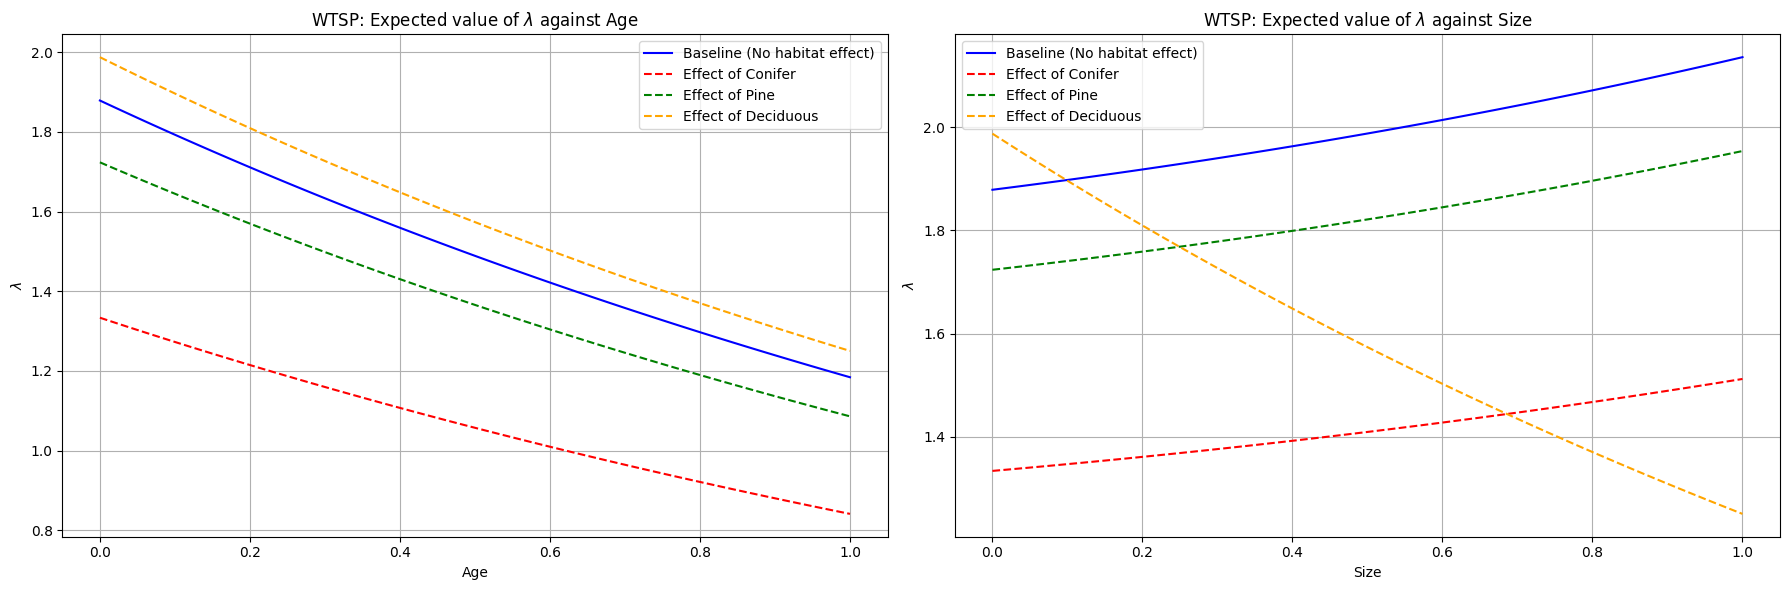

In [90]:
# Extract posterior samples for habitat covariates
BIRD_idata = WTSP_neigh_100m_idata
beta_conifer_samples = BIRD_idata['posterior']["beta_conifer"].values.flatten()
beta_pine_samples = BIRD_idata['posterior']["beta_pine"].values.flatten()
beta_deciduous_samples = BIRD_idata['posterior']["beta_deciduous"].values.flatten()

# Compute lambda for age with each forest type set to its maximum, size is constant
lambda_age_conifer = np.array([
    np.exp(beta_age * age_values 
            + b0 + beta_size * size_constant_value
             + beta_conifer)
    for beta_age, b0, beta_size, beta_conifer in zip(beta_age_samples,                                                                    
                                                                    beta_0_samples, 
                                                                    beta_size_samples, 
                                                                    beta_conifer_samples)
]).mean(axis=0)

lambda_age_pine = np.array([
    np.exp(beta_age * age_values 
            + b0 + beta_size * size_constant_value 
            + beta_pine)
    for beta_age, b0, beta_size, beta_pine in zip(beta_age_samples, 
                                                                beta_0_samples,
                                                                 beta_size_samples,
                                                                  beta_pine_samples)
]).mean(axis=0)

lambda_age_deciduous = np.array([
    np.exp(beta_age * age_values 
            + b0 
            + beta_size * size_constant_value 
            + beta_deciduous)
    for beta_age, b0, beta_size, beta_deciduous in zip(beta_age_samples,
                                                                    beta_0_samples,
                                                                    beta_size_samples,
                                                                    beta_deciduous_samples)
]).mean(axis=0)

# Compute lambda for size with each forest type set to its maximum, age constant
lambda_size_conifer = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_conifer)
    for beta_age, b0, beta_size, beta_conifer in zip(beta_age_samples,
                                                                    beta_0_samples, 
                                                                    beta_size_samples, 
                                                                    beta_conifer_samples)
]).mean(axis=0)

lambda_size_pine = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_pine)
    for beta_age, b0, beta_size, beta_pine in zip(beta_age_samples,
                                                                    beta_0_samples,                                                                    
                                                                    beta_size_samples, 
                                                                    beta_pine_samples)
]).mean(axis=0)

lambda_size_deciduous = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_deciduous)
    for beta_age, b0, beta_size, beta_deciduous in zip(beta_age_samples, 
                                                                        beta_0_samples, 
                                                                        beta_size_samples, 
                                                                        beta_deciduous_samples)
]).mean(axis=0)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for age
axes[0].plot(age_values, mean_lambda_age, color="blue", label="Baseline (No habitat effect)")
axes[0].plot(age_values, lambda_age_conifer, color="red", linestyle="--", label="Effect of Conifer")
axes[0].plot(age_values, lambda_age_pine, color="green", linestyle="--", label="Effect of Pine")
axes[0].plot(age_values, lambda_age_deciduous, color="orange", linestyle="--", label="Effect of Deciduous")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("$\lambda$")
axes[0].set_title("WTSP: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)

# Plot for size
axes[1].plot(size_values, mean_lambda_size, color="blue", label="Baseline (No habitat effect)")
axes[1].plot(size_values, lambda_size_conifer, color="red", linestyle="--", label="Effect of Conifer")
axes[1].plot(size_values, lambda_size_pine, color="green", linestyle="--", label="Effect of Pine")
axes[1].plot(size_values, lambda_age_deciduous, color="orange", linestyle="--", label="Effect of Deciduous")
axes[1].set_xlabel("Size")
axes[1].set_ylabel("$\lambda$")
axes[1].set_title("WTSP: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


#### How does lambda change over tie with different quantiles of size?

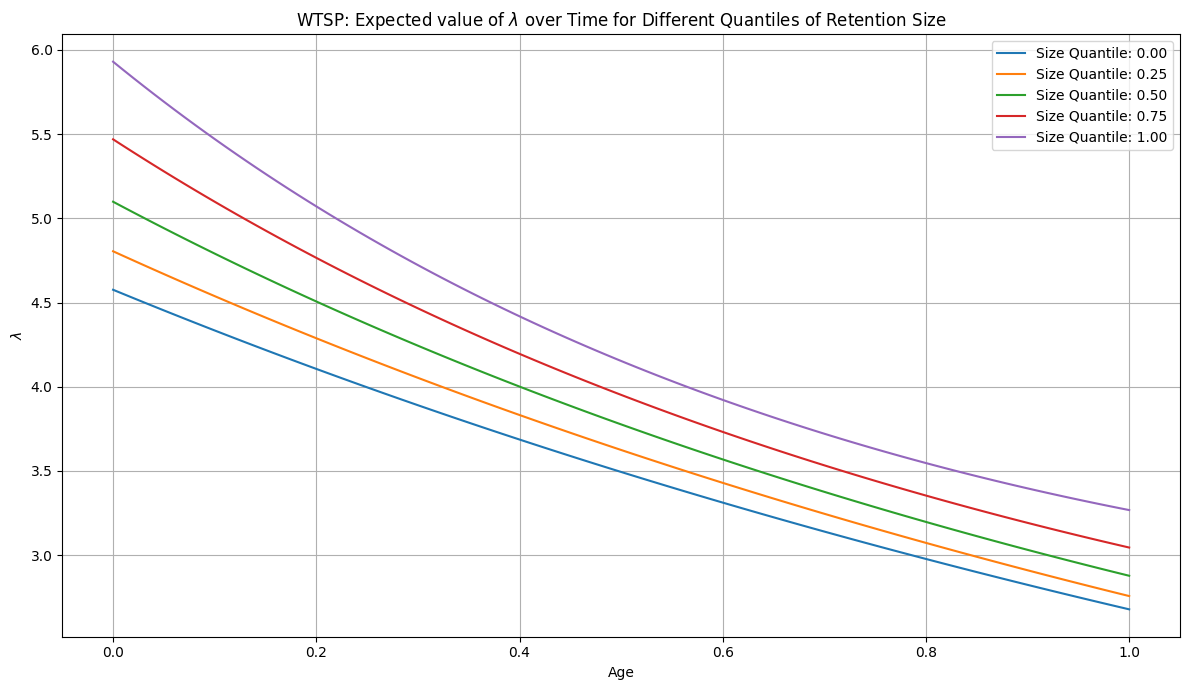

In [98]:
# Select quantiles for size
size_quantiles = np.percentile(size_values, [0, 25, 50, 75, 100])

# Compute lambda for each quantile of size across age values
lambda_by_size_quantiles = {}
for q in size_quantiles:
    lambda_by_size_quantiles[q] = np.array([
        np.exp(beta_age * age_values + beta_age_size * age_values * q + b0 + beta_size * q)
        for beta_age, beta_age_size, b0, beta_size in zip(beta_age_samples, beta_age_size_samples, beta_0_samples, beta_size_samples)
    ]).mean(axis=0)

# Plotting the expected value of lambda against age for each quantile of size
plt.figure(figsize=(12, 7))

for q, lambda_values in lambda_by_size_quantiles.items():
    plt.plot(age_values, lambda_values, label=f"Size Quantile: {q:.2f}")

plt.xlabel("Age")
plt.ylabel("$\lambda$")
plt.title("WTSP: Expected value of $\lambda$ over Time for Different Quantiles of Retention Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### C.9 Just Poisson!

In [23]:
poisson_model = CmdStanModel(stan_file=os.path.join(stan_path, "poisson.stan"))

12:12:02 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson.exe
12:13:04 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson.exe
12:13:04 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
12:13:04 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Models/Stan/poisson.hpp C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Models/Stan/poisson.stan
Warning in 'C:/Users/ilebe/Documents/!Masters!/Analysis/AbundanceConditionalOccupancy/Models/Stan/poisson.stan', line 65, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
   

In [54]:
poisson_samples = poisson_model.sample(
    data=MinMax_obs_and_covs_dict,
    parallel_chains=4,
    iter_sampling=1000,
    show_console=False)

12:25:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:03 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████


12:25:46 - cmdstanpy - INFO - CmdStan done processing.


In [22]:
summary_table = poisson_samples.summary()
summary_table

Mean      MCSE    StdDev          5%         50%   
lp__         -351.362000  0.051185  2.040220 -355.235000 -351.042000  \
alpha           0.073907  0.004191  0.175669   -0.223069    0.079963   
beta_age       -0.362897  0.016062  0.719821   -1.540070   -0.362759   
beta_size      -0.614043  0.007594  0.463587   -1.385240   -0.597663   
beta_conifer   -0.662785  0.004379  0.184749   -0.969799   -0.662253   
...                  ...       ...       ...         ...         ...   
log_lik[388]   -0.816882  0.009866  0.430079   -1.660240   -0.713764   
log_lik[389]   -1.131550  0.004275  0.184033   -1.470360   -1.065960   
log_lik[390]   -1.686600  0.006922  0.310536   -2.287310   -1.624730   
log_lik[391]   -1.033850  0.001186  0.051553   -1.135300   -1.014360   
log_lik[392]   -1.155340  0.003743  0.176626   -1.458210   -1.143700   

                     95%    N_Eff  N_Eff/s     R_hat  
lp__         -348.736000  1588.81  145.030  0.999961  
alpha           0.359261  1757.13  160.396  1.000380  
beta_age        0.827709  2008.30  183.323  1.000040  
beta_size       0.140339  3726.58  340.171  1.000980  
beta_conifer   -0.354690  1779.88  162.472  1.002740  
...                  ...      ...      ...       ...  
log_lik[388]   -0.315314  1900.22  173.457  0.999904  
log_lik[389]   -1.000590  1853.30  169.174  1.000100  
log_lik[390]   -1.316030  2012.59  183.715  1.000500  
log_lik[391]   -1.000120  1889.94  172.519  0.999716  
log_lik[392]   -0.886708  2227.10  203.296  0.999552  

[793 rows x 9 columns]

In [55]:
poisson_idata = az.from_cmdstanpy(
    posterior= poisson_samples, 
    posterior_predictive=["M_pred"],
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                   "patch" : MinMax_obs_and_covs_dict['patch'],
                    "percent_conifer": MinMax_obs_and_covs_dict['percent_conifer'], 
                    "percent_pine": MinMax_obs_and_covs_dict['percent_pine'],
                    "percent_deciduous": MinMax_obs_and_covs_dict['percent_deciduous']},
    log_likelihood="log_lik"
)

In [56]:
# bird = "YRWA"
poisson_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_250m_patch and size inter.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Models\\Inference Data\\REVI\\REVI_poiss_250m_patch and size inter.nc'

In [57]:
# Load the InferenceData from the NetCDF file
# bird = "RCKI"
BIRD_idata = az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_250m_patch and size inter.nc'))

Back transform the covariates so they are easier to interpret in the graphs

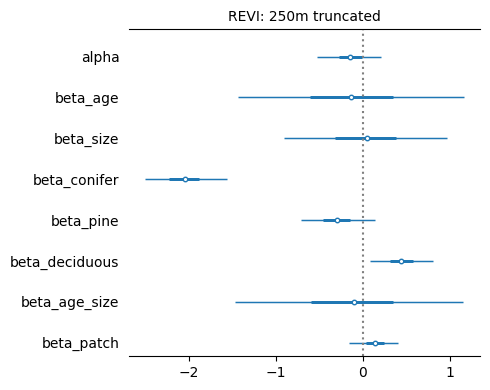

In [58]:
# BIRD_idata = WTSP_poiss_idata
ax = az.plot_forest(BIRD_idata, combined=True,
               figsize=(5, 4), textsize=10)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title(f'{bird}: 250m truncated', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Truncation 250m", "forest patch x size.png"))

To visualise the effect of a predictor of interest on the response/mechanism, it's a matrix multiplication where the response is predicted from all the posteriors that went into the model * a range of values for the covariate of interest + the other observed covariates held constant at their mean.

$lambda_{pred}$ = $alpha_{posterior}$ + $x_{posterior}$ * **X** + $y_{posterior}$ * $y_{\mu}$ + $z_{posterior}$ * $z_{\mu}$

In [84]:
# Prepare posteriors and vectors for all coefficients

intercept_draws = BIRD_idata['posterior']["alpha"].values.flatten()
age_draws = BIRD_idata['posterior']["beta_age"].values.flatten()
size_draws = BIRD_idata['posterior']["beta_size"].values.flatten()
deciduous_draws = BIRD_idata['posterior']["beta_deciduous"].values.flatten()
pine_draws = BIRD_idata['posterior']["beta_pine"].values.flatten()
conifer_draws = BIRD_idata['posterior']["beta_conifer"].values.flatten()
interaction_draws = BIRD_idata['posterior']["beta_age_size"].values.flatten()
patch_draws = BIRD_idata['posterior']["beta_patch"].values.flatten()

age_vector = np.linspace(min(BIRD_idata.constant_data["age"].values), 
                         max(BIRD_idata.constant_data["age"].values), 
                         100)

size_vector = np.linspace(min(BIRD_idata.constant_data["size"].values), 
                         max(BIRD_idata.constant_data["size"].values), 
                         100)
conifer_vector = np.linspace(min(BIRD_idata.constant_data["percent_conifer"].values), 
                         max(BIRD_idata.constant_data["percent_conifer"].values), 
                         100)

conifer_mean = BIRD_idata.constant_data["percent_conifer"].values.mean()
deciduous_mean = BIRD_idata.constant_data["percent_deciduous"].values.mean()
pine_mean = BIRD_idata.constant_data["percent_pine"].values.mean()
size_mean = BIRD_idata.constant_data["size"].values.mean()
age_mean = BIRD_idata.constant_data["age"].values.mean()


KeyError: 'beta_age'

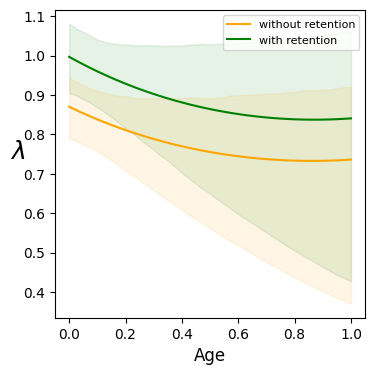

In [34]:
# Estimate lambda where patch is present or absent
patch = 0
Age_lambda_no_patch = np.array([
    np.exp(intercept_posterior +
           age_posterior * age_vector + 
           inter_posterior * size_mean * age_vector +
           patch_posterior * patch +
           size_posterior * patch  * size_mean +
           
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, inter_posterior, patch_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, interaction_draws, patch_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])


mean_Age_lambda_no_patch = np.mean(Age_lambda_no_patch, axis=0)
lower_Age_lambda_no_patch = np.percentile(Age_lambda_no_patch, 25, axis=0)
upper_Age_lambda_no_patch = np.percentile(Age_lambda_no_patch, 75, axis=0)

patch = 1
Age_lambda_with_patch = np.array([
    np.exp(intercept_posterior +
           age_posterior * age_vector + 
           inter_posterior * size_mean * age_vector +
           patch_posterior * patch +
           size_posterior * patch  * size_mean +
           
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, inter_posterior, patch_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, interaction_draws, patch_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

mean_Age_lambda_with_patch = np.mean(Age_lambda_with_patch, axis=0)
lower_Age_lambda_with_patch = np.percentile(Age_lambda_with_patch, 25, axis=0)
upper_Age_lambda_with_patch = np.percentile(Age_lambda_with_patch, 75, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(4, 4))
axes.plot(age_vector, mean_Age_lambda_no_patch, color="orange", label="without retention")
axes.plot(age_vector, mean_Age_lambda_with_patch, color="green", label="with retention")


axes.fill_between(size_vector, lower_Age_lambda_with_patch, upper_Age_lambda_with_patch, color="green", alpha=0.1)
axes.fill_between(size_vector, lower_Age_lambda_no_patch, upper_Age_lambda_no_patch, color="orange", alpha=0.1)
axes.set_xlabel("Age", size= 12)
axes.set_ylabel("$\lambda$", size=18, rotation=0)
axes.legend(fontsize=8)
axes.grid(False)
plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Closer than 100m", "age, with and without retn.png"))


In [366]:
# Estimate lambda keeping all predictors but one constant
lambda_pred_age = np.array([
    np.exp(intercept_posterior + age_posterior * age_vector + 
           size_posterior * 0.5 +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_age_no_retn = np.array([
    np.exp(intercept_posterior + age_posterior * age_vector + 
           size_posterior * 0 +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_age_large_retn = np.array([
    np.exp(intercept_posterior + age_posterior * age_vector + 
           size_posterior * 1 +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_size = np.array([
    np.exp(intercept_posterior + age_posterior * age_mean + 
           size_posterior * size_vector +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_size_conifer = np.array([
    np.exp(intercept_posterior + age_posterior * age_mean + 
           size_posterior * size_vector +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * 1)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])


lambda_pred_age_conifer = np.array([
    np.exp(intercept_posterior + age_posterior * age_vector + 
           size_posterior * size_mean +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_vector)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_conifer = np.array([
    np.exp(intercept_posterior + age_posterior * age_mean + 
           size_posterior * 0.5 +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_vector)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_conifer_no_retn = np.array([
    np.exp(intercept_posterior + age_posterior * age_mean + 
           size_posterior * 0 +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_vector)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_pred_conifer_large_retn = np.array([
    np.exp(intercept_posterior + age_posterior * age_mean + 
           size_posterior * 1 +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_vector)
    for intercept_posterior, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])


### Making several curves for multiple values of age, interaction posterior

In [367]:
# Estimate lambda from the interaciton term, creating many curves for several values of age
# Size always varies
lambda_inter = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_vector +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter = np.mean(lambda_inter, axis=0)
lower_bound_lambda_inter = np.percentile(lambda_inter, 2.5, axis=0)
upper_bound_lambda_inter = np.percentile(lambda_inter, 97.5, axis=0)


age_val = 0
lambda_inter_y0 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y0 = np.mean(lambda_inter_y0, axis=0)

age_val = 0.1
lambda_inter_y1 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y1 = np.mean(lambda_inter_y1, axis=0)

age_val = 0.25
lambda_inter_y2 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y2 = np.mean(lambda_inter_y2, axis=0)

age_val = 0.5
lambda_inter_y3 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y3 = np.mean(lambda_inter_y3, axis=0)

age_val = 0.75
lambda_inter_y4 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y4 = np.mean(lambda_inter_y4, axis=0)

age_val = 1
lambda_inter_y5 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y5 = np.mean(lambda_inter_y5, axis=0)


In [368]:
# lambda_pred_age
# Compute the mean and the 95% credible interval for lambda
mean_lambda_age = np.mean(lambda_pred_age, axis=0)
lower_bound_lambda_age = np.percentile(lambda_pred_age, 2.5, axis=0)
upper_bound_lambda_age = np.percentile(lambda_pred_age, 97.5, axis=0)

mean_lambda_age_no_retn = np.mean(lambda_pred_age_no_retn, axis=0)
lower_bound_lambda_age_no_retn = np.percentile(lambda_pred_age_no_retn, 2.5, axis=0)
upper_bound_lambda_age_no_retn = np.percentile(lambda_pred_age_no_retn, 97.5, axis=0)

mean_lambda_age_large_retn = np.mean(lambda_pred_age_large_retn, axis=0)
lower_bound_lambda_age_large_retn = np.percentile(lambda_pred_age_large_retn, 2.5, axis=0)
upper_bound_lambda_age__large_retn = np.percentile(lambda_pred_age_large_retn, 97.5, axis=0)

# Compute the mean and the 95% credible interval for lambda
mean_lambda_size = np.mean(lambda_pred_size, axis=0)
lower_bound_lambda_size = np.percentile(lambda_pred_size, 2.5, axis=0)
upper_bound_lambda_size = np.percentile(lambda_pred_size, 97.5, axis=0)

mean_lambda_size_conifer = np.mean(lambda_pred_size_conifer, axis=0)

mean_lambda_age_conifer = np.mean(lambda_pred_age_conifer, axis=0)

mean_lambda_conifer_no_retn = np.mean(lambda_pred_conifer_no_retn, axis=0)

mean_lambda_conifer = np.mean(lambda_pred_conifer, axis=0)

mean_lambda_conifer_large_retn = np.mean(lambda_pred_conifer_large_retn, axis=0)


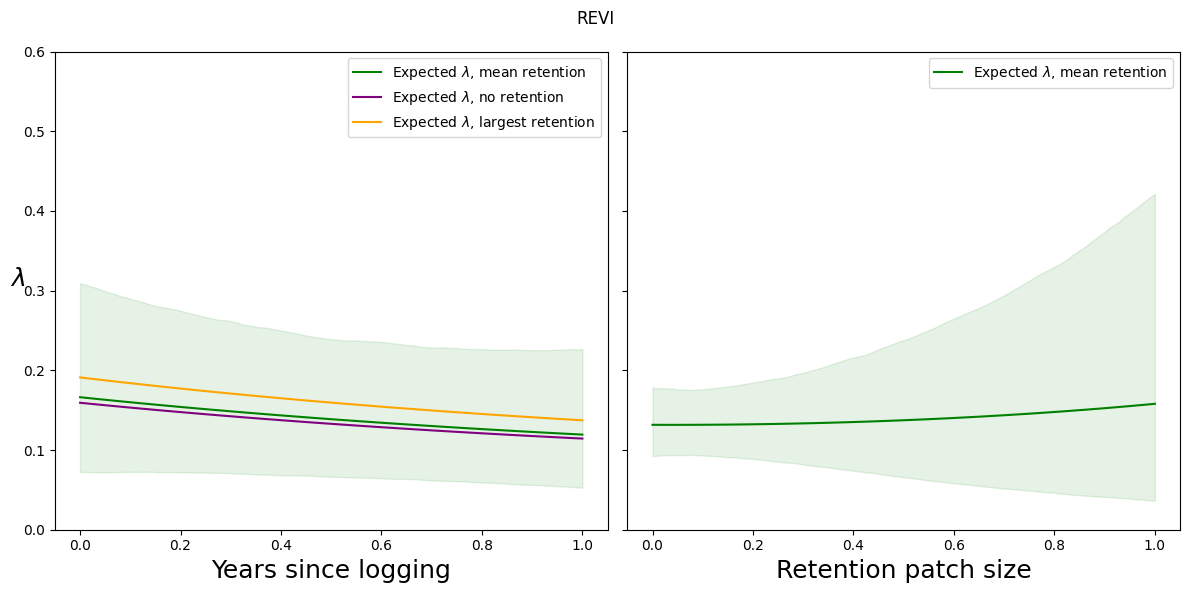

In [195]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
plt.ylim(0, 0.6)
# Plot for age
axes[0].plot(age_vector, mean_lambda_age, color="green", label="Expected $\lambda$, mean retention")
axes[0].plot(age_vector, mean_lambda_age_no_retn, color="purple", label="Expected $\lambda$, no retention")
axes[0].plot(age_vector, mean_lambda_age_large_retn, color="orange", label="Expected $\lambda$, largest retention")

axes[0].fill_between(age_vector, lower_bound_lambda_age, upper_bound_lambda_age, color="green", alpha=0.1)
axes[0].set_xlabel("Years since logging", size=18)
axes[0].set_ylabel("$\lambda$", size=18, rotation=0)
# axes[0].set_title(f"{bird}: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)

axes[1].plot(size_vector, mean_lambda_size, color="green", label="Expected $\lambda$, mean retention")
# axes[1].plot(size_vector, mean_lambda_size_conifer, color="green", label="conifer max")

# mean_lambda_size_conifer
axes[1].fill_between(size_vector, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1)
axes[1].set_xlabel("Retention patch size", size=18)
# axes[1].set_ylabel("$\lambda$", size=18, rotation=0)
# axes[1].set_title(f"{bird}: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)
fig.suptitle(f"{bird}")
plt.tight_layout()

plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Closer than 100m", "lambda age size pretty.png"))
plt.show()

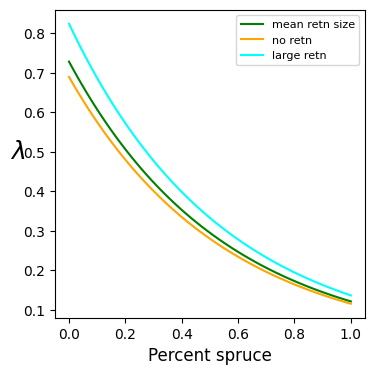

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(4, 4))
axes.plot(conifer_vector, mean_lambda_conifer, color="green", label="mean retn size")
axes.plot(conifer_vector, mean_lambda_conifer_no_retn, color="orange", label="no retn")
axes.plot(conifer_vector, mean_lambda_conifer_large_retn, color="aqua", label="large retn")

# axes[0].fill_between(size_vector, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1)
axes.set_xlabel("Percent spruce", size= 12)
axes.set_ylabel("$\lambda$", size=18, rotation=0)
axes.legend(fontsize=8)
axes.grid(False)

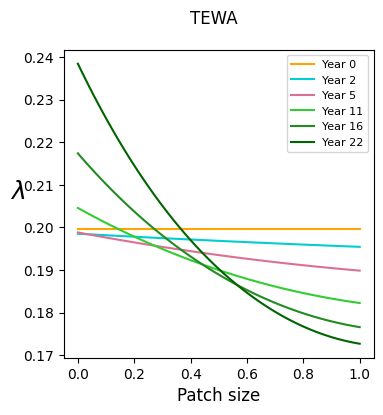

In [369]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(4, 4))
axes.plot(size_vector, mean_lambda_inter_y0, color="orange", label="Year 0")
axes.plot(size_vector, mean_lambda_inter_y1, color="darkturquoise", label="Year 2")
axes.plot(size_vector, mean_lambda_inter_y2, color="palevioletred", label="Year 5")

axes.plot(size_vector, mean_lambda_inter_y3, color="limegreen", label="Year 11")
axes.plot(size_vector, mean_lambda_inter_y4, color="forestgreen", label="Year 16")
axes.plot(size_vector, mean_lambda_inter_y5, color="darkgreen", label="Year 22")
# axes.plot(size_vector, mean_lambda_inter, color="gold", label="Year 22")

# axes.fill_between(size_vector, lower_bound_lambda_inter, upper_bound_lambda_inter, color="green", alpha=0.1)

# upper_bound_lambda_inter

# axes[0].fill_between(size_vector, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1)
axes.set_xlabel("Patch size", size= 12)
axes.set_ylabel("$\lambda$", size=18, rotation=0)
axes.legend(fontsize=8)
axes.grid(False)
fig.suptitle(f"{bird}")
plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Closer than 100m", "interaction age size.png"))


In [ ]:
# For both WTSP and REVI
# Estimate lambda from the interaciton term, creating many curves for several values of age
# Size always varies
lambda_inter = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_vector +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter = np.mean(lambda_inter, axis=0)
lower_bound_lambda_inter = np.percentile(lambda_inter, 2.5, axis=0)
upper_bound_lambda_inter = np.percentile(lambda_inter, 97.5, axis=0)


age_val = 0
lambda_inter_y0 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y0 = np.mean(lambda_inter_y0, axis=0)

age_val = 0.1
lambda_inter_y1 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y1 = np.mean(lambda_inter_y1, axis=0)

age_val = 0.25
lambda_inter_y2 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y2 = np.mean(lambda_inter_y2, axis=0)

age_val = 0.5
lambda_inter_y3 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y3 = np.mean(lambda_inter_y3, axis=0)

age_val = 0.75
lambda_inter_y4 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y4 = np.mean(lambda_inter_y4, axis=0)

age_val = 1
lambda_inter_y5 = np.array([
    np.exp(intercept_posterior + age_posterior * age_val + 
           size_posterior * 0.5 +
           inter_posterior * size_vector * age_val +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, size_posterior, inter_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, size_draws, interaction_draws, deciduous_draws, pine_draws, conifer_draws)
])
mean_lambda_inter_y5 = np.mean(lambda_inter_y5, axis=0)


Text(0.5, 1.0, 'WTSP')

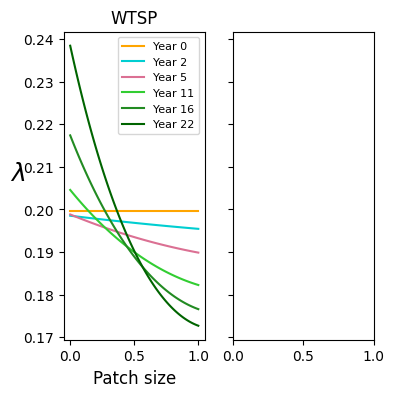

In [370]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(4, 4))
axes[0].plot(size_vector, mean_lambda_inter_y0, color="orange", label="Year 0")
axes[0].plot(size_vector, mean_lambda_inter_y1, color="darkturquoise", label="Year 2")
axes[0].plot(size_vector, mean_lambda_inter_y2, color="palevioletred", label="Year 5")
axes[0].plot(size_vector, mean_lambda_inter_y3, color="limegreen", label="Year 11")
axes[0].plot(size_vector, mean_lambda_inter_y4, color="forestgreen", label="Year 16")
axes[0].plot(size_vector, mean_lambda_inter_y5, color="darkgreen", label="Year 22")

axes[0].set_xlabel("Patch size", size= 12)
axes[0].set_ylabel("$\lambda$", size=18, rotation=0)
axes[0].legend(fontsize=8)
axes[0].grid(False)
axes[0].set_title('WTSP')

axes[1].plot(size_vector, mean_lambda_inter_y0, color="orange", label="Year 0")
axes[1].plot(size_vector, mean_lambda_inter_y1, color="darkturquoise", label="Year 2")
axes[1].plot(size_vector, mean_lambda_inter_y2, color="palevioletred", label="Year 5")
axes[1].plot(size_vector, mean_lambda_inter_y3, color="limegreen", label="Year 11")
axes[1].plot(size_vector, mean_lambda_inter_y4, color="forestgreen", label="Year 16")
axes[1].plot(size_vector, mean_lambda_inter_y5, color="darkgreen", label="Year 22")

axes[1].set_xlabel("Patch size", size= 12)
axes[1].set_ylabel("$\lambda$", size=18, rotation=0)
axes[1].legend(fontsize=8)
axes[1].grid(False)
axes[1].set_title('REVI')


Make a plot from the retn and age posteriors extracted from all models. Put those values in the same horizontal forest plot.

In [131]:
TEWA_retn_draws = BIRD_idata['posterior']['beta_age'].values.flatten()
numpy_path = r"C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\numpy arrays"
np.save(os.path.join(numpy_path, "TEWA_size_posterior.npy"), TEWA_retn_draws)

In [132]:
OSFL_retn_draws = np.load(os.path.join(numpy_path, "OSFL_size_posterior.npy"))
YRWA_retn_draws = np.load(os.path.join(numpy_path, "YRWA_size_posterior.npy"))
WTSP_retn_draws = np.load(os.path.join(numpy_path, "WSTP_size_posterior.npy"))
RCKI_retn_draws = np.load(os.path.join(numpy_path, "RCKI_size_posterior.npy"))
REVI_retn_draws = np.load(os.path.join(numpy_path, "REVI_size_posterior.npy"))
TEWA_retn_draws = np.load(os.path.join(numpy_path, "TEWA_size_posterior.npy"))

C:\Users\ilebe\AppData\Local\Temp\ipykernel_48168\320728985.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["OSFL", "YRWA", "WTSP", "WTSP", "RCKI", "REVI", "TEWA"])


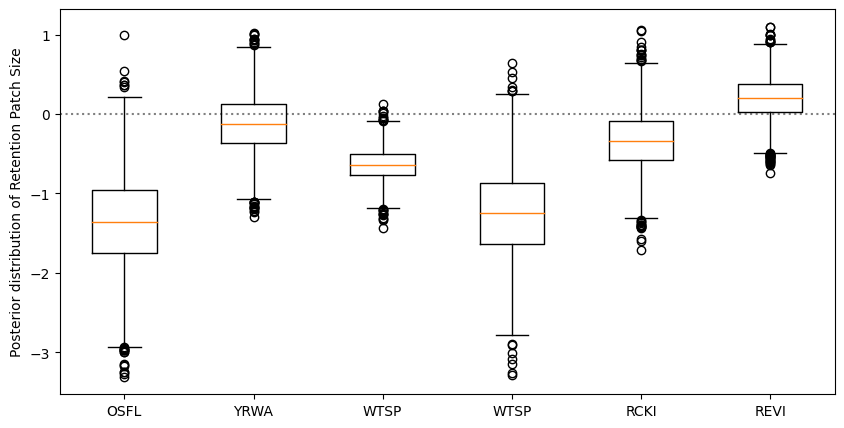

In [142]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
# Creating axes instance
ax.set_xticklabels(["OSFL", "YRWA", "WTSP", "WTSP", "RCKI", "REVI", "TEWA"])
ax.axhline(0, color="grey", linestyle="dotted")
# Creating plot
bp = ax.boxplot([OSFL_retn_draws, YRWA_retn_draws,WTSP_retn_draws ,RCKI_retn_draws ,REVI_retn_draws , TEWA_retn_draws])
ax.set_ylabel("Posterior distribution of Retention Patch Size") 
# show plot
plt.show()

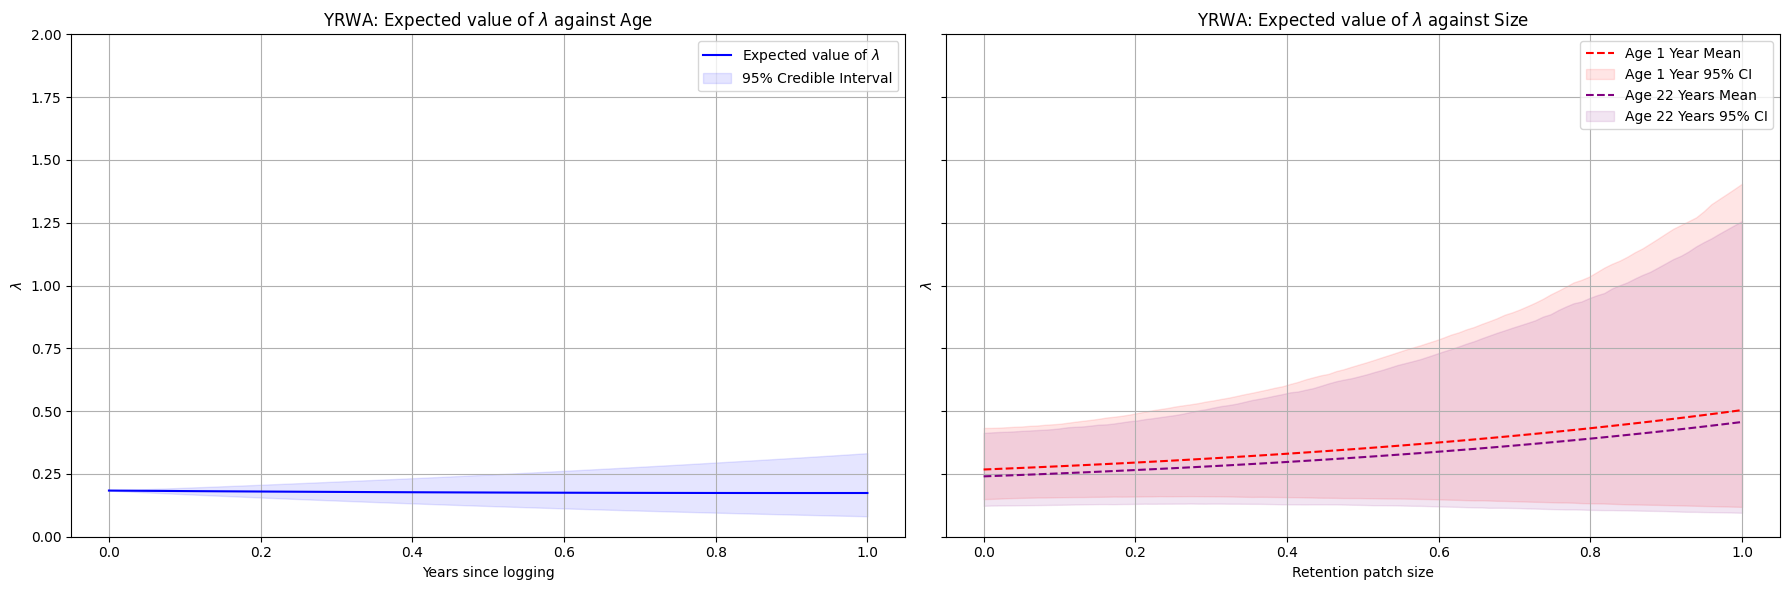

In [103]:
# Extract posterior samples for the relevant coefficients
beta_0_samples = BIRD_idata['posterior']["alpha"].values.flatten()
beta_age_samples = BIRD_idata['posterior']["beta_age"].values.flatten()
beta_size_samples = BIRD_idata['posterior']["beta_size"].values.flatten()

mean_intercept = BIRD_idata['posterior']["alpha"].values.flatten().mean()
beta_conifer_mean = BIRD_idata['posterior']["beta_conifer"].values.flatten().mean()
beta_pine_mean = BIRD_idata['posterior']["beta_pine"].values.flatten().mean()
beta_deciduous_mean = BIRD_idata['posterior']["beta_deciduous"].values.flatten().mean()
mean_beta_size  = BIRD_idata['posterior']["beta_size"].values.flatten().mean()

conifer_mean_value = BIRD_idata.constant_data["percent_conifer"].values.mean()
deciduous_mean_value = BIRD_idata.constant_data["percent_deciduous"].values.mean()
pine_mean_value = BIRD_idata.constant_data["percent_pine"].values.mean()
size_mean_value = BIRD_idata.constant_data["size"].values.mean()
# Evaluate the rate of change in lambda against a range of age values

age_values = np.linspace(min(BIRD_idata.constant_data["age"].values), 
                         max(BIRD_idata.constant_data["age"].values), 
                         100)

size_values = np.linspace(min(BIRD_idata.constant_data["size"].values), 
                         max(BIRD_idata.constant_data["size"].values), 
                         100)


# Compute lambda for each posterior sample and for each age value
# Set size to 0 as specified
# size_constant_value = 0 # change this to mean ag 

# Issue: i am making an array from arrays with matching sizes, but keeping the other predictors constant 
# means they are singular.
lambda_values_age = np.array([
    np.exp(beta_age * age_values + b0 + beta_size * size_constant_value)
    for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)
])

# Calculate lambda values across different age values
lambda_values_age = np.array([
    np.exp(mean_intercept + beta_age * age_values + 
           mean_beta_size * size_mean_value +
           beta_deciduous_mean * deciduous_mean_value +
           beta_pine_mean * pine_mean_value +
           beta_conifer_mean * conifer_mean_value)
    for beta_age in beta_age_samples
])

# Compute the mean and the 95% credible interval for lambda
mean_lambda_age = np.mean(lambda_values_age, axis=0)
lower_bound_lambda = np.percentile(lambda_values_age, 2.5, axis=0)
upper_bound_lambda = np.percentile(lambda_values_age, 97.5, axis=0)


# Correctly compute lambda for each posterior sample and for a range of size values, keeping age constant
age_constant_value = 0
lambda_values_size = np.array([
    np.exp(beta_age * age_constant_value
            + b0 
            + beta_size * size_values)
    for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)  
])

# Compute the mean and the 95% credible interval for lambda as size increases
mean_lambda_size = np.mean(lambda_values_size, axis=0)
lower_bound_lambda_size = np.percentile(lambda_values_size, 2.5, axis=0)
upper_bound_lambda_size = np.percentile(lambda_values_size, 97.5, axis=0)

# Compute lambda for age_since_logging at 1 year and 22 years
age_1_year = 0
age_22_years = 1

# Compute lambda for age_since_logging at 1 year and 22 years across the size range
lambda_values_age_1_year = np.array([
    np.exp(beta_age * age_1_year + b0 + beta_size * size_values)
    for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)
])

lambda_values_age_22_years = np.array([
    np.exp(beta_age * age_22_years + b0 + beta_size * size_values)
    for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)
])

# Compute the mean and 95% credible interval for these specific ages
mean_lambda_age_1_year = np.mean(lambda_values_age_1_year, axis=0)
lower_bound_lambda_age_1_year = np.percentile(lambda_values_age_1_year, 2.5, axis=0)
upper_bound_lambda_age_1_year = np.percentile(lambda_values_age_1_year, 97.5, axis=0)

mean_lambda_age_22_years = np.mean(lambda_values_age_22_years, axis=0)
lower_bound_lambda_age_22_years = np.percentile(lambda_values_age_22_years, 2.5, axis=0)
upper_bound_lambda_age_22_years = np.percentile(lambda_values_age_22_years, 97.5, axis=0)


# Rest of your plotting code remains the same


# Plotting the expected value of lambda against age and size with credible intervals
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 6))
plt.ylim(0, 2)

# Plot for age
axes[0].plot(age_values, mean_lambda_age, color="blue", label="Expected value of $\lambda$")
axes[0].fill_between(age_values, lower_bound_lambda, upper_bound_lambda, color="blue", alpha=0.1, label="95% Credible Interval")
axes[0].set_xlabel("Years since logging")
axes[0].set_ylabel("$\lambda$")
axes[0].set_title(f"{bird}: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)


# Plot for size
# Plot these specific lines on the second subplot
axes[1].plot(size_values, mean_lambda_age_1_year, color='red', linestyle='--', label='Age 1 Year Mean')
axes[1].fill_between(size_values, lower_bound_lambda_age_1_year, upper_bound_lambda_age_1_year, color='red', alpha=0.1, label='Age 1 Year 95% CI')

axes[1].plot(size_values, mean_lambda_age_22_years, color='purple', linestyle='--', label='Age 22 Years Mean')
axes[1].fill_between(size_values, lower_bound_lambda_age_22_years, upper_bound_lambda_age_22_years, color='purple', alpha=0.1, label='Age 22 Years 95% CI')

# axes[1].plot(size_values, mean_lambda_size, color="green", label="Expected value of $\lambda$")
# axes[1].fill_between(size_values, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1, label="95% Credible Interval")
axes[1].set_xlabel("Retention patch size")
axes[1].set_ylabel("$\lambda$")
axes[1].set_title(f"{bird}: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


From the pyrodivesrity paper:
>Black lines show mean predictions and shaded regions show 95% credible intervals for the relationship between occupancy and (a) years since fire, (b) burn severity, (c) diversity in burn severity, and (d) fir basal area. For predictions, other predictors are held at their average value and interactions with years since fire are shown by plotting effects at 1 and 10 years post-fire.

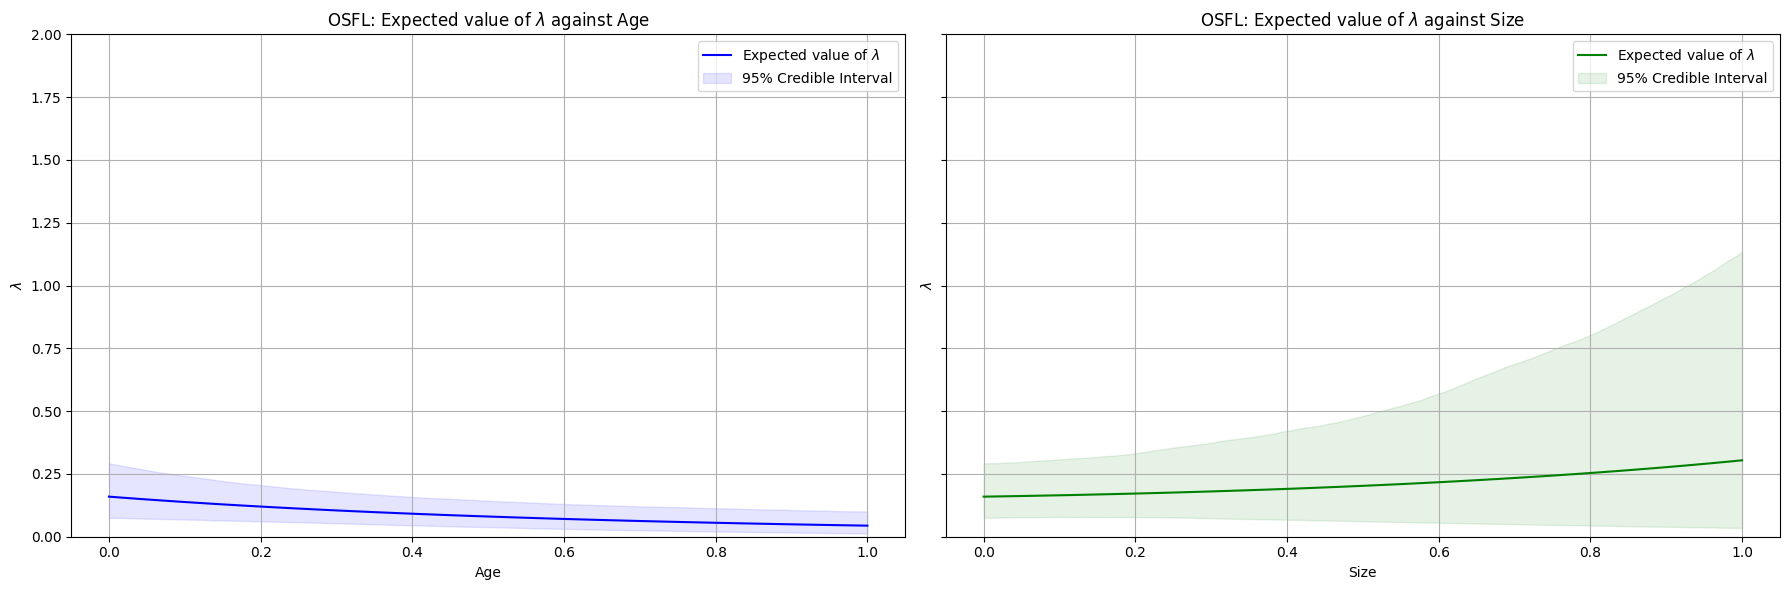

In [19]:
# Extract posterior samples for the relevant coefficients
beta_0_samples = BIRD_idata['posterior']["alpha"].values.flatten()
beta_age_samples = BIRD_idata['posterior']["beta_age"].values.flatten()
beta_size_samples = BIRD_idata['posterior']["beta_size"].values.flatten()

beta_conifer_samples = BIRD_idata['posterior']["beta_conifer"].values.flatten()
beta_pine_samples = BIRD_idata['posterior']["beta_pine"].values.flatten()
beta_deciduous_samples = BIRD_idata['posterior']["beta_deciduous"].values.flatten()

# Evaluate the rate of change in lambda against a range of age values
age_values = np.linspace(min(BIRD_idata.constant_data["age"].values), 
                         max(BIRD_idata.constant_data["age"].values), 
                         100)

size_values = np.linspace(min(BIRD_idata.constant_data["size"].values), 
                         max(BIRD_idata.constant_data["size"].values), 
                         100)

# Get mean values for all other predictors


# Compute lambda for each posterior sample and for each age value
# Set size to mean size?
size_constant_value = 0
lambda_values_age = np.array([
    np.exp(beta_age * age_values  + b0 + beta_size * size_constant_value)
    for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)
])

# Compute the mean and the 95% credible interval for lambda
mean_lambda_age = np.mean(lambda_values_age, axis=0)
lower_bound_lambda = np.percentile(lambda_values_age, 2.5, axis=0)
upper_bound_lambda = np.percentile(lambda_values_age, 97.5, axis=0)


# Correctly compute lambda for each posterior sample and for a range of size values, keeping age constant
age_constant_value = 0
lambda_values_size = np.array([
    np.exp(beta_age * age_constant_value
            + b0 
            + beta_size * size_values)
    for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)  
])

# Compute the mean and the 95% credible interval for lambda as size increases
mean_lambda_size = np.mean(lambda_values_size, axis=0)
lower_bound_lambda_size = np.percentile(lambda_values_size, 2.5, axis=0)
upper_bound_lambda_size = np.percentile(lambda_values_size, 97.5, axis=0)


# Plotting the expected value of lambda against age and size with credible intervals
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 6))
plt.ylim(0, 2)

# Plot for age
axes[0].plot(age_values, mean_lambda_age, color="blue", label="Expected value of $\lambda$")
axes[0].fill_between(age_values, lower_bound_lambda, upper_bound_lambda, color="blue", alpha=0.1, label="95% Credible Interval")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("$\lambda$")
axes[0].set_title(f"{bird}: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)


# Plot for size
axes[1].plot(size_values, mean_lambda_size, color="green", label="Expected value of $\lambda$")
axes[1].fill_between(size_values, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1, label="95% Credible Interval")
axes[1].set_xlabel("Size")
axes[1].set_ylabel("$\lambda$")
axes[1].set_title(f"{bird}: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


In [46]:
BIRD_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

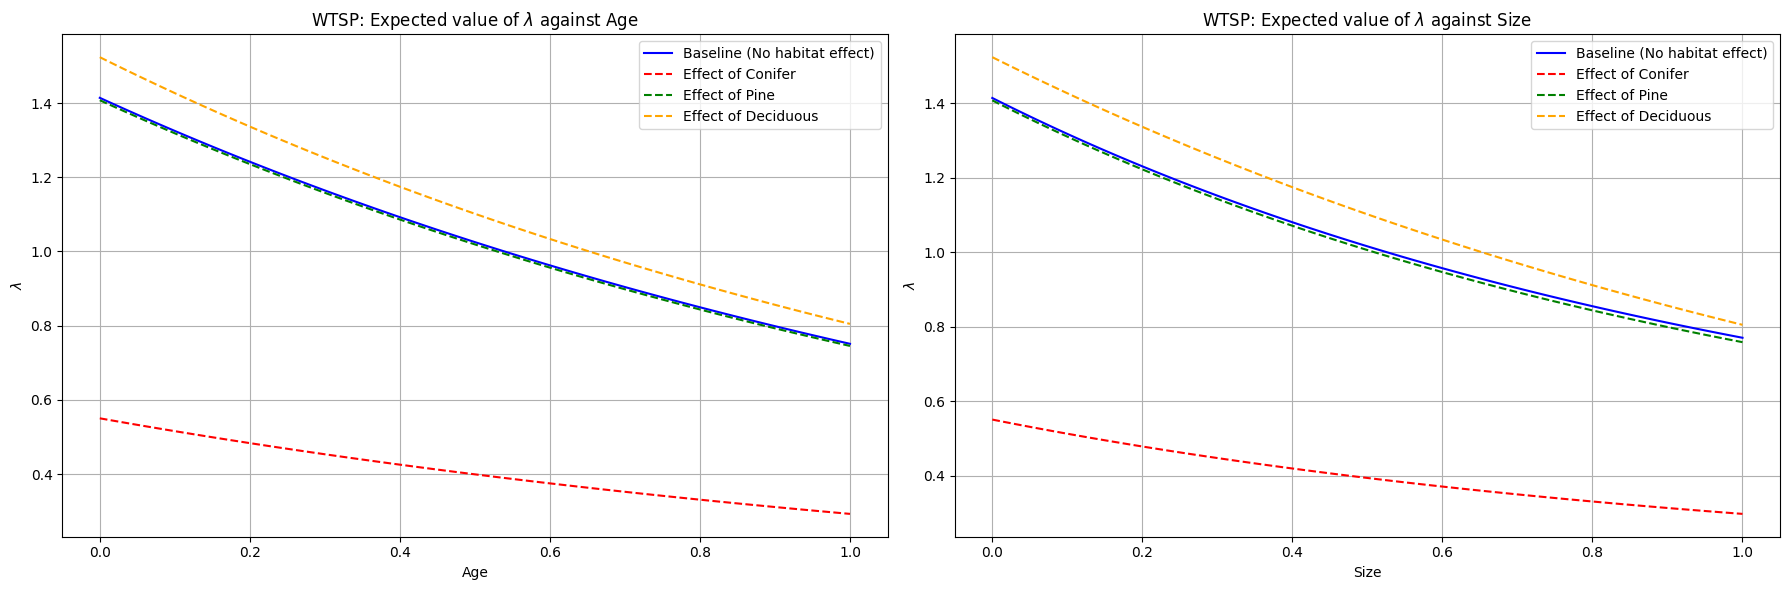

In [91]:
# Extract posterior samples for habitat covariates
# BIRD_idata = YRWA_poiss_idata
beta_conifer_samples = BIRD_idata['posterior']["beta_conifer"].values.flatten()
beta_pine_samples = BIRD_idata['posterior']["beta_pine"].values.flatten()
beta_deciduous_samples = BIRD_idata['posterior']["beta_deciduous"].values.flatten()

# Compute lambda for age with each forest type set to its maximum, size is constant
lambda_age_conifer = np.array([
    np.exp(beta_age * age_values 
            + b0 + beta_size * size_constant_value
             + beta_conifer)
    for beta_age, b0, beta_size, beta_conifer in zip(beta_age_samples,                                                                    
                                                                    beta_0_samples, 
                                                                    beta_size_samples, 
                                                                    beta_conifer_samples)
]).mean(axis=0)

lambda_age_pine = np.array([
    np.exp(beta_age * age_values 
            + b0 + beta_size * size_constant_value 
            + beta_pine)
    for beta_age, b0, beta_size, beta_pine in zip(beta_age_samples, 
                                                                beta_0_samples,
                                                                 beta_size_samples,
                                                                  beta_pine_samples)
]).mean(axis=0)

lambda_age_deciduous = np.array([
    np.exp(beta_age * age_values 
            + b0 
            + beta_size * size_constant_value 
            + beta_deciduous)
    for beta_age, b0, beta_size, beta_deciduous in zip(beta_age_samples,
                                                                    beta_0_samples,
                                                                    beta_size_samples,
                                                                    beta_deciduous_samples)
]).mean(axis=0)

# Compute lambda for size with each forest type set to its maximum, age constant
lambda_size_conifer = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_conifer)
    for beta_age, b0, beta_size, beta_conifer in zip(beta_age_samples,
                                                                    beta_0_samples, 
                                                                    beta_size_samples, 
                                                                    beta_conifer_samples)
]).mean(axis=0)

lambda_size_pine = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_pine)
    for beta_age, b0, beta_size, beta_pine in zip(beta_age_samples,
                                                                    beta_0_samples,                                                                    
                                                                    beta_size_samples, 
                                                                    beta_pine_samples)
]).mean(axis=0)

lambda_size_deciduous = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_deciduous)
    for beta_age, b0, beta_size, beta_deciduous in zip(beta_age_samples, 
                                                                        beta_0_samples, 
                                                                        beta_size_samples, 
                                                                        beta_deciduous_samples)
]).mean(axis=0)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for age
axes[0].plot(age_values, mean_lambda_age, color="blue", label="Baseline (No habitat effect)")
axes[0].plot(age_values, lambda_age_conifer, color="red", linestyle="--", label="Effect of Conifer")
axes[0].plot(age_values, lambda_age_pine, color="green", linestyle="--", label="Effect of Pine")
axes[0].plot(age_values, lambda_age_deciduous, color="orange", linestyle="--", label="Effect of Deciduous")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("$\lambda$")
axes[0].set_title(f"{bird}: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)

# Plot for size
axes[1].plot(size_values, mean_lambda_size, color="blue", label="Baseline (No habitat effect)")
axes[1].plot(size_values, lambda_size_conifer, color="red", linestyle="--", label="Effect of Conifer")
axes[1].plot(size_values, lambda_size_pine, color="green", linestyle="--", label="Effect of Pine")
axes[1].plot(size_values, lambda_age_deciduous, color="orange", linestyle="--", label="Effect of Deciduous")
axes[1].set_xlabel("Size")
axes[1].set_ylabel("$\lambda$")
axes[1].set_title(f"{bird}: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()


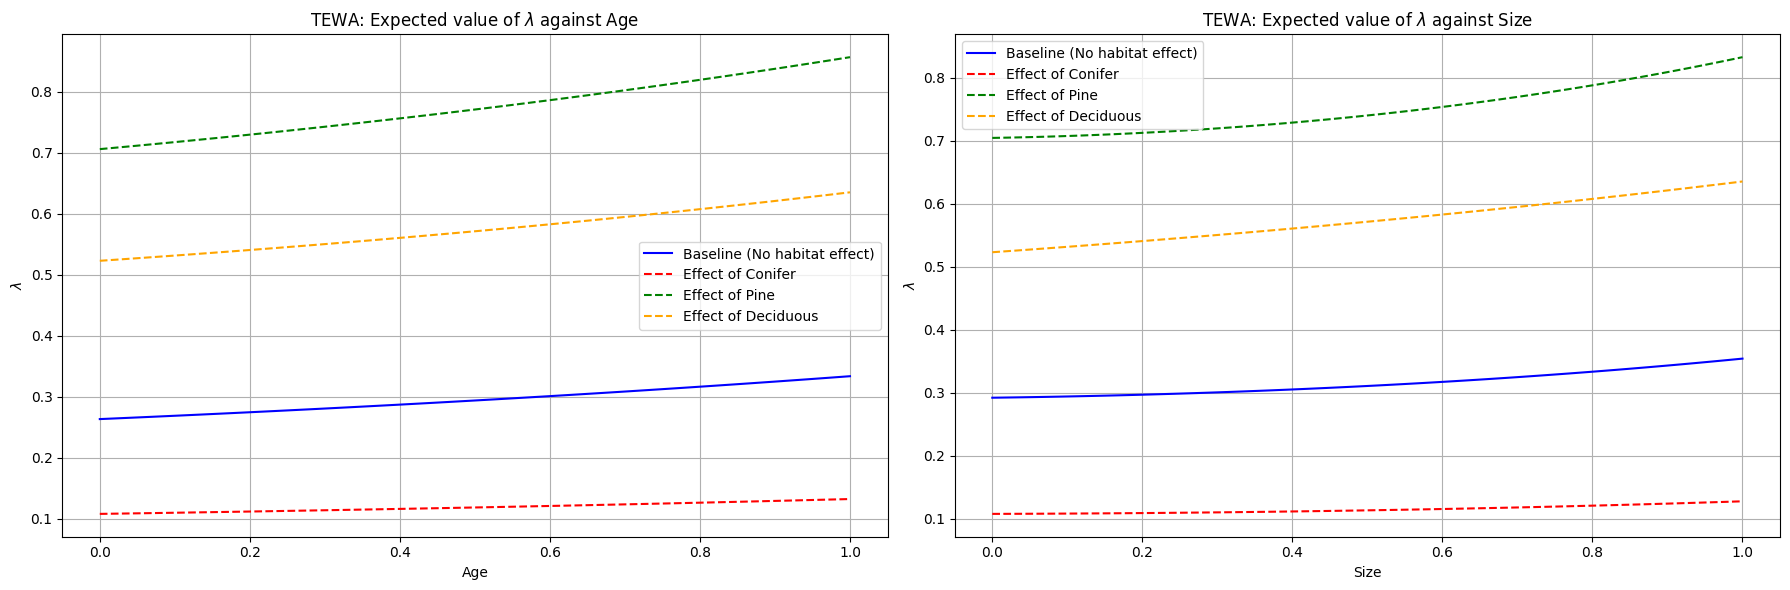

In [110]:
# Extract posterior samples for habitat covariates
# BIRD_idata = YRWA_poiss_idata
beta_conifer_samples = BIRD_idata['posterior']["beta_conifer"].values.flatten()
beta_pine_samples = BIRD_idata['posterior']["beta_pine"].values.flatten()
beta_deciduous_samples = BIRD_idata['posterior']["beta_deciduous"].values.flatten()

# Compute lambda for age with each forest type set to its maximum, size is constant
lambda_age_conifer = np.array([
    np.exp(beta_age * age_values 
            + b0 + beta_size * size_constant_value
             + beta_conifer)
    for beta_age, b0, beta_size, beta_conifer in zip(beta_age_samples,                                                                    
                                                                    beta_0_samples, 
                                                                    beta_size_samples, 
                                                                    beta_conifer_samples)
]).mean(axis=0)

lambda_age_pine = np.array([
    np.exp(beta_age * age_values 
            + b0 + beta_size * size_constant_value 
            + beta_pine)
    for beta_age, b0, beta_size, beta_pine in zip(beta_age_samples, 
                                                                beta_0_samples,
                                                                 beta_size_samples,
                                                                  beta_pine_samples)
]).mean(axis=0)

lambda_age_deciduous = np.array([
    np.exp(beta_age * age_values 
            + b0 
            + beta_size * size_constant_value 
            + beta_deciduous)
    for beta_age, b0, beta_size, beta_deciduous in zip(beta_age_samples,
                                                                    beta_0_samples,
                                                                    beta_size_samples,
                                                                    beta_deciduous_samples)
]).mean(axis=0)

# Compute lambda for size with each forest type set to its maximum, age constant
lambda_size_conifer = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_conifer)
    for beta_age, b0, beta_size, beta_conifer in zip(beta_age_samples,
                                                                    beta_0_samples, 
                                                                    beta_size_samples, 
                                                                    beta_conifer_samples)
]).mean(axis=0)

lambda_size_pine = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_pine)
    for beta_age, b0, beta_size, beta_pine in zip(beta_age_samples,
                                                                    beta_0_samples,                                                                    
                                                                    beta_size_samples, 
                                                                    beta_pine_samples)
]).mean(axis=0)

lambda_size_deciduous = np.array([
    np.exp(beta_age * age_constant_value 
            + b0 
            + beta_size * size_values 
            + beta_deciduous)
    for beta_age, b0, beta_size, beta_deciduous in zip(beta_age_samples, 
                                                                        beta_0_samples, 
                                                                        beta_size_samples, 
                                                                        beta_deciduous_samples)
]).mean(axis=0)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot for age
axes[0].plot(age_values, mean_lambda_age, color="blue", label="Baseline (No habitat effect)")
axes[0].plot(age_values, lambda_age_conifer, color="red", linestyle="--", label="Effect of Conifer")
axes[0].plot(age_values, lambda_age_pine, color="green", linestyle="--", label="Effect of Pine")
axes[0].plot(age_values, lambda_age_deciduous, color="orange", linestyle="--", label="Effect of Deciduous")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("$\lambda$")
axes[0].set_title(f"{bird}: Expected value of $\lambda$ against Age")
axes[0].legend()
axes[0].grid(False)

# Plot for size
axes[1].plot(size_values, mean_lambda_size, color="blue", label="Baseline (No habitat effect)")
axes[1].plot(size_values, lambda_size_conifer, color="red", linestyle="--", label="Effect of Conifer")
axes[1].plot(size_values, lambda_size_pine, color="green", linestyle="--", label="Effect of Pine")
axes[1].plot(size_values, lambda_age_deciduous, color="orange", linestyle="--", label="Effect of Deciduous")
axes[1].set_xlabel("Size")
axes[1].set_ylabel("$\lambda$")
axes[1].set_title(f"{bird}: Expected value of $\lambda$ against Size")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
plt.show()

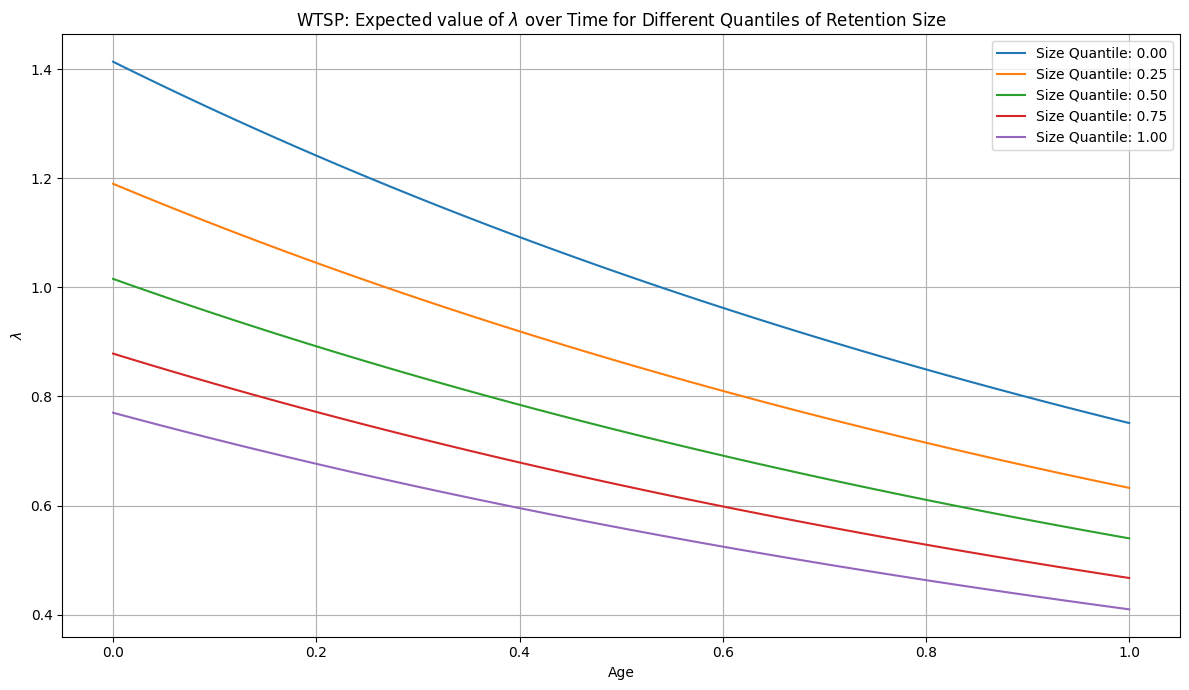

In [92]:
# Select quantiles for size
size_quantiles = np.percentile(size_values, [0, 25, 50, 75, 100])

# Compute lambda for each quantile of size across age values
lambda_by_size_quantiles = {}
for q in size_quantiles:
    lambda_by_size_quantiles[q] = np.array([
        np.exp(beta_age * age_values + b0 + beta_size * q)
        for beta_age, b0, beta_size in zip(beta_age_samples, beta_0_samples, beta_size_samples)
    ]).mean(axis=0)

# Plotting the expected value of lambda against age for each quantile of size
plt.figure(figsize=(12, 7))

for q, lambda_values in lambda_by_size_quantiles.items():
    plt.plot(age_values, lambda_values, label=f"Size Quantile: {q:.2f}")

plt.xlabel("Age")
plt.ylabel("$\lambda$")
plt.title(f"{bird}: Expected value of $\lambda$ over Time for Different Quantiles of Retention Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### C.10 Binomial N-mixture

In [24]:
BinNMix_model = CmdStanModel(stan_file=os.path.join(stan_path, "binomial N-mixture model.stan"))

ValueError: Failed to get source info for Stan model 'C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\zero-inflated binomial N-mixture model.stan'. Console:
Warning in 'C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\zero-inflated binomial N-mixture model.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\zero-inflated binomial N-mixture model.stan', line 18, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\zero-inflated binomial N-mixture model.stan', line 80, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Semantic error in 'C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\zero-inflated binomial N-mixture model.stan', line 49, column 12 to column 66:
   -------------------------------------------------
    47:                        + beta_conifer * percent_conifer;
    48:  
    49:    logit_p = rep_matrix(alpha_0 + alpha_1 * tod + alpha_2 + toy, J);
                     ^
    50:  }
    51:  
   -------------------------------------------------

Ill-typed arguments supplied to function 'rep_matrix':
(matrix, int)
Available signatures:
(vector, int) => matrix
  The first argument must be vector but got matrix
(row_vector, int) => matrix
  The first argument must be row_vector but got matrix
(complex_vector, int) => complex_matrix
  The first argument must be complex_vector but got matrix
(complex_row_vector, int) => complex_matrix
  The first argument must be complex_row_vector but got matrix
(real, int, int) => matrix
  Expected 3 arguments but found 2 arguments.
(Additional signatures omitted)


### C.11 Poisson with hierarchy on the intercept for presence of patch

In [104]:
HierPatchModel = CmdStanModel(stan_file=os.path.join(stan_path, "poisson with patch hier.stan"))


15:48:17 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson with patch hier.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson with patch hier.exe
15:48:43 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson with patch hier.exe
15:48:43 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
15:48:43 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/ilebe/AppData/Local/Temp/tmpd0g4lpkr/tmp0nqcdbkm.hpp C:/Users/ilebe/AppData/Local/Temp/tmpd0g4lpkr/tmp0nqcdbkm.stan
Warning in 'C:/Users/ilebe/AppData/Local/Temp/tmpd0g4lpkr/tmp0nqcdbkm.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keywor

In [162]:
HierPatch_samples = HierPatchModel.sample(
    data=MinMax_obs_and_covs_dict,
    parallel_chains=4,
    iter_sampling=1000,
    show_console=False)

16:06:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02


16:06:56 - cmdstanpy - INFO - CmdStan done processing.


In [163]:
HierPatch_idata = az.from_cmdstanpy(
    posterior= HierPatch_samples, 
    # posterior_predictive=["M_pred"],
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "patch": MinMax_obs_and_covs_dict["patch"],
                   "size" : MinMax_obs_and_covs_dict['size'],
                    "percent_conifer": MinMax_obs_and_covs_dict['percent_conifer'], 
                    "percent_pine": MinMax_obs_and_covs_dict['percent_pine'],
                    "percent_deciduous": MinMax_obs_and_covs_dict['percent_deciduous']}
    # log_likelihood="log_lik"
).to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_hier_intercept.nc'))

# RCKI_poiss_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_100m_inter.nc'))
# BIRD_idata = RCKI_HierPatch_idata

In [164]:
# Load the InferenceData from the NetCDF file
bird = "WTSP"
BIRD_idata = az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_hier_intercept.nc'))

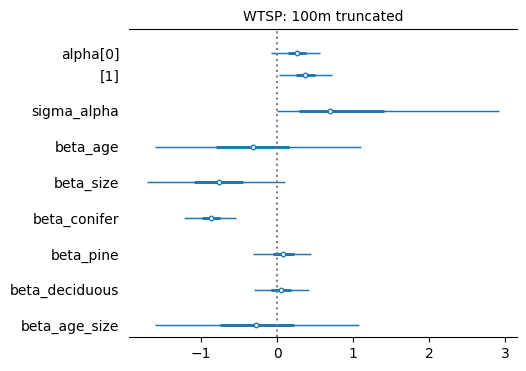

In [165]:
# BIRD_idata = WTSP_poiss_idata
ax = az.plot_forest(BIRD_idata, combined=True,
               figsize=(5, 4), textsize=10)
ax[0].axvline(0, color="grey", linestyle="dotted")
ax[0].set_title(f'{bird}: 100m truncated', fontsize=10)
plt.savefig(os.path.join(posterior_figures_path, bird, "Intercept hierarchy", "forest with intercept.png"))

In [166]:
# Prepare model estimates
alpha_noPatch_draws = BIRD_idata['posterior']['alpha'][0].values.flatten()
alpha_withPatch_draws = BIRD_idata['posterior']['alpha'][1].values.flatten()
age_draws = BIRD_idata['posterior']["beta_age"].values.flatten()
size_draws = BIRD_idata['posterior']["beta_size"].values.flatten()
deciduous_draws = BIRD_idata['posterior']["beta_deciduous"].values.flatten()
pine_draws = BIRD_idata['posterior']["beta_pine"].values.flatten()
conifer_draws = BIRD_idata['posterior']["beta_conifer"].values.flatten()
interaction_draws = BIRD_idata['posterior']["beta_age_size"].values.flatten()

conifer_mean = BIRD_idata.constant_data["percent_conifer"].values.mean()
deciduous_mean = BIRD_idata.constant_data["percent_deciduous"].values.mean()
pine_mean = BIRD_idata.constant_data["percent_pine"].values.mean()
size_mean = BIRD_idata.constant_data["size"].values.mean()
age_mean = BIRD_idata.constant_data["age"].values.mean()

age_vector = np.linspace(min(BIRD_idata.constant_data["age"].values), 
                         max(BIRD_idata.constant_data["age"].values), 
                         100)
# Calculate lambda for each patch and age
lambda_patch_0 = np.array([
    np.exp(alpha_noPatch_post + age_posterior * age_vector + 
           size_posterior * size_mean +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for alpha_noPatch_post, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in
    zip(alpha_noPatch_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

lambda_patch_1 =  np.array([
    np.exp(alpha_withPatch_post + age_posterior * age_vector + 
           size_posterior * size_mean +
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for alpha_withPatch_post, age_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in
    zip(alpha_withPatch_draws, age_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

mean_lambda_patch_0 = np.mean(lambda_patch_0, axis=0)
lower_bound_lambda_patch_0 = np.percentile(lambda_patch_0, 2.5, axis=0)
upper_bound_lambda_patch_0 = np.percentile(lambda_patch_0, 97.5, axis=0)

mean_lambda_patch_1 = np.mean(lambda_patch_1, axis=0)
lower_bound_lambda_patch_1 = np.percentile(lambda_patch_1, 2.5, axis=0)
upper_bound_lambda_patch_1 = np.percentile(lambda_patch_1, 97.5, axis=0)


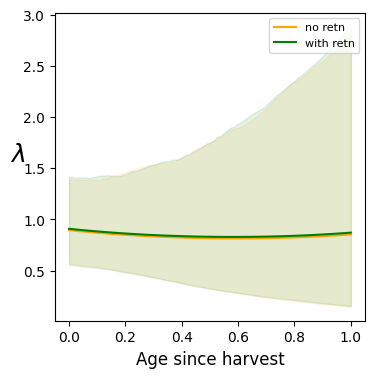

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(4, 4))
axes.plot(age_vector, mean_lambda_patch_0, color="orange", label="no retn")
axes.plot(age_vector, mean_lambda_patch_1, color="green", label="with retn")

axes.fill_between(age_vector, lower_bound_lambda_patch_0, upper_bound_lambda_patch_0, color="orange", alpha=0.1)
axes.fill_between(age_vector, lower_bound_lambda_patch_1, upper_bound_lambda_patch_1, color="green", alpha=0.1)
axes.set_xlabel("Age since harvest", size= 12)
axes.set_ylabel("$\lambda$", size=18, rotation=0)
axes.legend(fontsize=8)
axes.grid(False)

plt.savefig(os.path.join(posterior_figures_path, bird, "Intercept hierarchy", "age separate intercepts.png"))


In [88]:
RCKI_HierPatch_idata['posterior']['alpha'][0]

<xarray.DataArray 'alpha' (draw: 1000, alpha_dim_0: 2)>
array([[-3.02965, -2.64247],
       [-2.7419 , -1.8681 ],
       [-2.19834, -2.41091],
       ...,
       [-3.24492, -2.73559],
       [-3.05825, -1.75616],
       [-3.22757, -1.53298]])
Coordinates:
    chain        int32 0
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * alpha_dim_0  (alpha_dim_0) int32 0 1

In [77]:
HierPatchRCKI_samples.summary()

Mean      MCSE    StdDev        5%       50%       95%   
lp__        -62.69140  0.035231  1.472530 -65.58120 -62.34670 -60.96230  \
alpha[1]     -2.80317  0.009075  0.471506  -3.62899  -2.78046  -2.05053   
alpha[2]     -2.15247  0.007342  0.363151  -2.76744  -2.13547  -1.59240   
sigma_alpha   0.98783  0.015280  0.968710   0.05140   0.68968   2.88631   
beta_age     -1.82896  0.012840  0.628340  -2.88717  -1.81709  -0.79569   

                  N_Eff     N_Eff/s     R_hat  
lp__         1746.98000  1259.54000  0.999716  
alpha[1]     2699.44000  1946.25000  0.999742  
alpha[2]     2446.71000  1764.03000  1.000140  
sigma_alpha  4017.88199  2896.81470  0.999270  
beta_age     2392.95091  1725.27102  1.000450

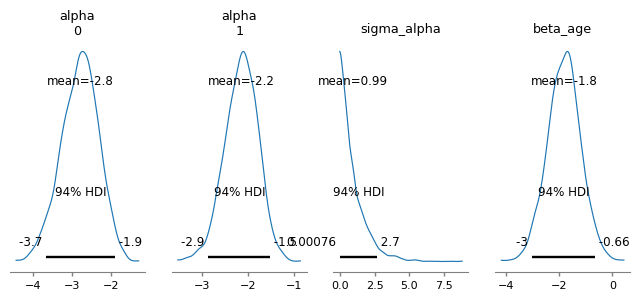

In [81]:
axes =  az.plot_posterior(HierPatchRCKI_samples, figsize=(8, 3), textsize=8)

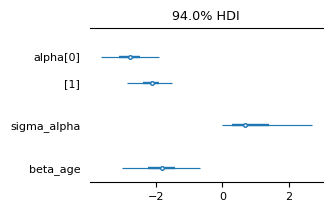

In [82]:
az.plot_forest(HierPatchRCKI_samples,
               combined=True,
                 figsize=(3, 2 ), textsize=8);

### C.12 Poisson with categorical tree type

In [5]:
poisson_trees = CmdStanModel(stan_file=os.path.join(stan_path, "poisson forest cats.stan"))

10:17:42 - cmdstanpy - INFO - compiling stan file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson forest cats.stan to exe file C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson forest cats.exe
10:18:35 - cmdstanpy - INFO - compiled model executable: C:\Users\ilebe\Documents\!Masters!\Analysis\AbundanceConditionalOccupancy\Models\Stan\poisson forest cats.exe


In [17]:
poisson_minimum_preds = CmdStanModel(stan_file=os.path.join(stan_path, "poisson forest cats less predictors.stan"))

In [159]:
poissonModel_samples = poisson_trees.sample(
    data=MinMax_obs_and_covs_dict,
    parallel_chains=4,
    iter_warmup = 2000,
    iter_sampling = 10000,
    show_console=False)

12:35:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▏         | 00:00 Iteration:     1 / 12000 [  0%]  (Warmup)


chain 1 |▎         | 00:00 Iteration:   200 / 12000 [  1%]  (Warmup)


chain 1 |▍         | 00:00 Iteration:   400 / 12000 [  3%]  (Warmup)


chain 1 |▋         | 00:00 Iteration:   600 / 12000 [  5%]  (Warmup)


chain 1 |▊         | 00:00 Iteration:   800 / 12000 [  6%]  (Warmup)


chain 1 |▉         | 00:00 Iteration:  1000 / 12000 [  8%]  (Warmup)


chain 1 |█▏        | 00:00 Iteration:  1200 / 12000 [ 10%]  (Warmup)


chain 1 |█▍        | 00:01 Iteration:  1500 / 12000 [ 12%]  (Warmup)


chain 1 |█▌        | 00:01 Iteration:  1700 / 12000 [ 14%]  (Warmup)


chain 1 |█▋        | 00:01 Iteration:  1900 / 12000 [ 15%]  (Warmup)


chain 1 |█▉        | 00:01 Iteration:  2100 / 12000 [ 17%]  (Sampling)


chain 1 |██▏       | 00:01 Iteration:  2300 / 12000 [ 19%]  (Sampling)


chain 1 |██▎       | 00:01 Iteration:  2500 / 12000 [ 20%]  (Sampling)


chain 1 |██▍       | 00:01 Iteration:  2700 / 12000 [ 22%]  (Sampling)



12:35:50 - cmdstanpy - INFO - CmdStan done processing.


In [32]:
poissonModel_samples.summary()

Mean      MCSE    StdDev          5%         50%   
lp__                  -391.576000  0.041741  1.724610 -394.758000 -391.255000  \
alpha                   -0.013070  0.001096  0.068854   -0.130295   -0.012499   
beta_size[1]             0.172555  0.007470  0.568975   -0.779814    0.192834   
beta_size[2]             0.746386  0.008016  0.580037   -0.223278    0.773096   
beta_size[3]            -0.384666  0.008216  0.640699   -1.490560   -0.356932   
...                           ...       ...       ...         ...         ...   
pred_lambda_pine[388]    0.061860  0.001995  0.157956   -0.207574    0.071263   
pred_lambda_pine[389]   -0.013070  0.001096  0.068854   -0.130295   -0.012499   
pred_lambda_pine[390]   -0.013070  0.001096  0.068854   -0.130295   -0.012499   
pred_lambda_pine[391]   -0.002353  0.000798  0.054568   -0.091091   -0.000880   
pred_lambda_pine[392]   -0.013070  0.001096  0.068854   -0.130295   -0.012499   

                              95%    N_Eff   N_Eff/s     R_hat  
lp__                  -389.383000  1707.12   661.676  1.000480  
alpha                    0.098931  3947.34  1529.980  0.999489  
beta_size[1]             1.080810  5802.04  2248.850  0.999985  
beta_size[2]             1.649980  5236.53  2029.660  0.999789  
beta_size[3]             0.630382  6081.20  2357.060  1.000090  
...                           ...      ...       ...       ...  
pred_lambda_pine[388]    0.312730  6270.64  2430.480  0.999886  
pred_lambda_pine[389]    0.098931  3947.34  1529.980  0.999489  
pred_lambda_pine[390]    0.098931  3947.34  1529.980  0.999489  
pred_lambda_pine[391]    0.088428  4671.77  1810.760  0.999380  
pred_lambda_pine[392]    0.098931  3947.34  1529.980  0.999489  

[399 rows x 9 columns]

In [148]:
poissonUNL_idata = az.from_cmdstanpy(
    posterior= poissonModel_samples,
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                   "patch" :MinMax_obs_and_covs_dict['patch'],
                   "tree_groups": MinMax_obs_and_covs_dict['tree_groups']},
    coords= {"beta_size_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"],
            "beta_age_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"]}
)
poissonUNL_idata.rename_vars({"beta_size": "Patch Size", "beta_patch":"Patch", "beta_age_patch": "Patch:Age", "beta_age": "Age"}, inplace=True)

poissonUNL_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_UNL_patch_longer_equation_patch_age.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Models\\Inference Data\\REVI\\REVI_poiss_UNL_patch_longer_equation_patch_age.nc'

In [160]:
poisson150_idata = az.from_cmdstanpy(
    posterior= poissonModel_samples,
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                   "patch" :MinMax_obs_and_covs_dict['patch'],
                   "tree_groups": MinMax_obs_and_covs_dict['tree_groups']},
    coords= {"beta_size_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"],
            "beta_age_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"]}
)
poisson150_idata.rename_vars({"beta_size": "Patch Size", "beta_patch":"Patch", "beta_age_patch": "Patch:Age", "beta_age": "Age"}, inplace=True)

poisson150_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_150_patch_longer_equation_patch_age.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Models\\Inference Data\\REVI\\REVI_poiss_150_patch_longer_equation_patch_age.nc'

In [154]:
poisson250_idata = az.from_cmdstanpy(
    posterior= poissonModel_samples,
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                   "patch" :MinMax_obs_and_covs_dict['patch'],
                   "tree_groups": MinMax_obs_and_covs_dict['tree_groups']},
    coords= {"beta_size_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"],
            "beta_age_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"]}
)
poisson250_idata.rename_vars({"beta_size": "Patch Size", "beta_patch":"Patch", "beta_age_patch": "Patch:Age", "beta_age": "Age"}, inplace=True)

poisson250_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_250_patch_longer_equation_patch_age.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Models\\Inference Data\\REVI\\REVI_poiss_250_patch_longer_equation_patch_age.nc'

In [161]:
# bird = 'WTSP'
# poisson150_idata = az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_150m_patch_longer_equation.nc'))
# poisson250_idata = az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_250m_patch_longer_equation.nc'))
# poissonUNL_idata= az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_UNL_patch_longer_equation.nc'))


poisson150_idata = az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_150_patch_longer_equation_patch_age.nc'))
poisson250_idata = az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_250_patch_longer_equation_patch_age.nc'))
poissonUNL_idata= az.from_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_UNL_patch_longer_equation_patch_age.nc'))

In [162]:
az.summary(poisson150_idata, hdi_prob = .95, round_to = 3).to_csv(os.path.join(summary_tables_path, f'{bird}_150_poisson_patch_age.csv'), index=True)
az.summary(poisson250_idata, hdi_prob = .95, round_to = 3).to_csv(os.path.join(summary_tables_path, f'{bird}_250_poisson_patch_age.csv'), index=True)
az.summary(poissonUNL_idata, hdi_prob = .95, round_to = 3).to_csv(os.path.join(summary_tables_path, f'{bird}_UNL_poisson_patch_age.csv'), index=True)

In [ ]:
poissonUNL_idata = az.from_cmdstanpy(
    posterior= poissonModel_samples,
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                   "patch" :MinMax_obs_and_covs_dict['patch'],
                   "tree_groups": MinMax_obs_and_covs_dict['tree_groups']},
    coords= {"beta_size_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"],
            "beta_age_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"]}
)
poissonUNL_idata.rename_vars({"beta_size": "patch size", "beta_patch":"patch", "beta_age_patch": "patch:age"}, inplace=True)

poissonUNL_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_UNL_patch_treeGroup3.nc'))

In [63]:
poisson250_idata = az.from_cmdstanpy(
    posterior= poissonModel_samples,
    observed_data={"M": MinMax_obs_and_covs_dict["M"]},
    constant_data={"age": MinMax_obs_and_covs_dict["age"], 
                   "size" : MinMax_obs_and_covs_dict['size'],
                   "patch" :MinMax_obs_and_covs_dict['patch'],
                   "tree_groups": MinMax_obs_and_covs_dict['tree_groups']},
    coords= {"beta_size_dim_0" : ["Pine", "Deciduous", "Mixed", "Spruce"]}
)
poisson250_idata.rename_vars({"beta_size": "patch size","beta_age_patch": "patch:age"}, inplace=True)

poisson250_idata.to_netcdf(os.path.join(idata_path, f'{bird}', f'{bird}_poiss_250m_minimum_preds.nc'))

'C:\\Users\\ilebe\\Documents\\!Masters!\\Analysis\\AbundanceConditionalOccupancy\\Models\\Inference Data\\OSFL\\OSFL_poiss_250m_minimum_preds.nc'

"Pine": 1, "Deciduous": 2, "Mixedwood": 3, "Spruce": 4

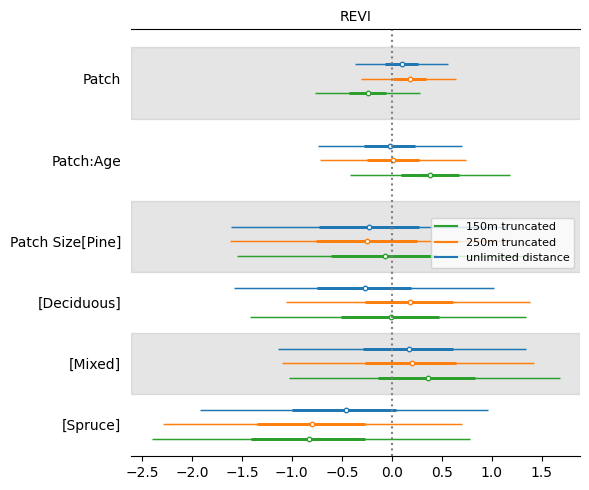

In [164]:
# BIRD_idata = WTSP_poiss_idata
plt.rc('legend', fontsize=8)
ax = az.plot_forest([poissonUNL_idata, poisson250_idata, poisson150_idata], combined=True,
               figsize=(6, 5), textsize=10, kind='forestplot', filter_vars =None,
                model_names=['unlimited distance', '250m truncated', '150m truncated'],
                legend=True,
                var_names=["Patch", "Patch:Age", "Patch Size", ])

ax[0].axvline(0, color="grey", linestyle="dotted")
# ax[0].legend(loc="upper right")
ax[0].set_title(f'{bird}', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Select Params_unlimited vs 250m vs 150m.png"))

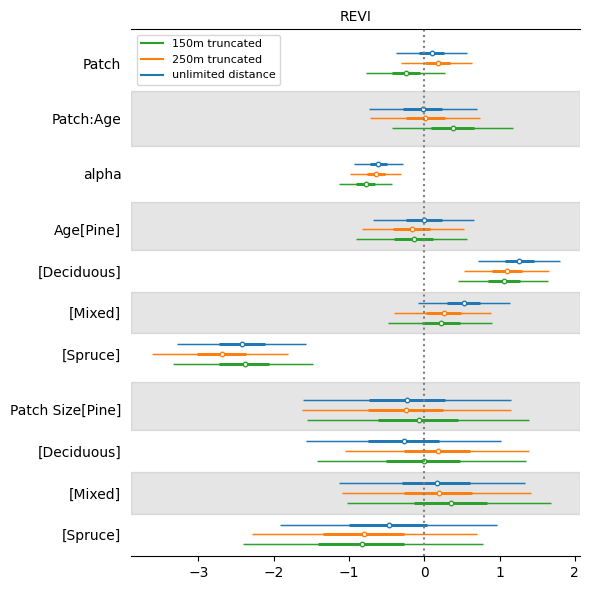

In [166]:
# BIRD_idata = WTSP_poiss_idata
plt.rc('legend', fontsize=8)
ax = az.plot_forest([poissonUNL_idata, poisson250_idata, poisson150_idata], combined=True,
               figsize=(6, 6), textsize=10, kind='forestplot', filter_vars ="like",
                model_names=['unlimited distance',  '250m truncated', '150m truncated'],
                legend=True)
                # var_names=['alpha', 'beta_size'])
ax[0].axvline(0, color="grey", linestyle="dotted")
# ax[0].legend(loc="upper right")
ax[0].set_title(f'{bird}', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Full model_unlimited vs 250m vs 150m.png"))

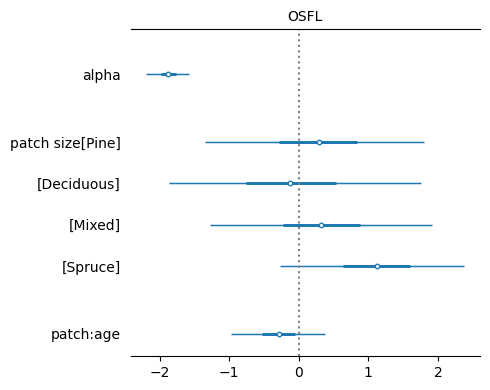

In [64]:
# az.labels.DimCoordLabeller.dim_coord_to_str(poisson100_idata['Coordinates'], coord_val, coord_idx)
ax = az.plot_forest(poisson250_idata, combined=True,
               figsize=(5, 4), textsize=10, kind='forestplot', filter_vars ="like",
)
ax[0].axvline(0, color="grey", linestyle="dotted")
# ax[0].legend(loc="upper right")
ax[0].set_title(f'{bird}', fontsize=10)
plt.tight_layout()
# plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "unlimited vs 250m vs 100m.png"))

In [ ]:
# Get avergae summary of results

In [82]:
# Prepare posteriors and vectors for all coefficients
poisson_idata = poisson250_idata
BIRD_idata = poisson250_idata
intercept_draws = BIRD_idata['posterior']["alpha"].values.flatten()
size_PINE_draws = BIRD_idata['posterior']["patch size"][0].values.flatten()
size_DECID_draws = BIRD_idata['posterior']["patch size"][1].values.flatten()
size_MIXED_draws = BIRD_idata['posterior']["patch size"][2].values.flatten()
size_SPRUCE_draws = BIRD_idata['posterior']["patch size"][3].values.flatten()
age_patch_draws = BIRD_idata['posterior']["patch:age"].values.flatten()

age_vector = np.linspace(min(BIRD_idata.constant_data["age"].values), 
                         max(BIRD_idata.constant_data["age"].values), 
                         100)

size_vector = np.linspace(min(BIRD_idata.constant_data["size"].values), 
                         max(BIRD_idata.constant_data["size"].values), 
                         100)

# size_mean = BIRD_idata.constant_data["size"].values.mean()
age_mean = BIRD_idata.constant_data["age"].values.mean()

# Estimate lambda keeping all predictors but one constant
lambda_size_PINE = np.array([
    np.exp(intercept_posterior + size_pine_post * size_vector
           + age_patch_post * 1 * age_mean)
    for intercept_posterior, size_pine_post, age_patch_post in 
    zip(intercept_draws, size_PINE_draws, age_patch_draws)
])
mean_size_PINE = np.mean(lambda_size_PINE, axis=0)

lambda_size_DECID = np.array([
    np.exp(intercept_posterior + size_dec_post * size_vector
           + age_patch_post * 1 * age_mean)
    for intercept_posterior, size_dec_post, age_patch_post in 
    zip(intercept_draws, size_DECID_draws, age_patch_draws)
])
mean_size_DEC = np.mean(lambda_size_DECID, axis=0)

lambda_size_MIX = np.array([
    np.exp(intercept_posterior + size_mix_post * size_vector
           + age_patch_post * 1 * age_mean)
    for intercept_posterior, size_mix_post, age_patch_post in 
    zip(intercept_draws, size_MIXED_draws, age_patch_draws)
])
mean_size_MIX = np.mean(lambda_size_MIX, axis=0)

lambda_size_SPR = np.array([
    np.exp(intercept_posterior + size_spr_post * size_vector
           + age_patch_post * 1 * age_mean)
    for intercept_posterior, size_spr_post, age_patch_post in 
    zip(intercept_draws, size_SPRUCE_draws, age_patch_draws)
])
mean_size_SPR = np.mean(lambda_size_SPR, axis=0)


Text(0.5, 0.98, 'OSFL')

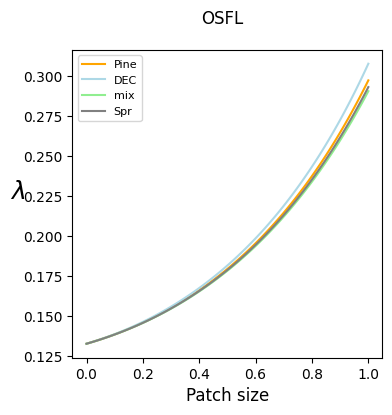

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(4, 4))
axes.plot(size_vector, mean_size_PINE, color="orange", label="Pine")
axes.plot(size_vector, mean_size_DEC, color="lightblue", label="DEC")
axes.plot(size_vector, mean_size_MIX, color="lightgreen", label="mix")
axes.plot(size_vector, mean_size_SPR, color="grey", label="Spr")
# axes.plot(size_vector, mean_lambda_inter, color="gold", label="Year 22")
# axes.fill_between(size_vector, lower_bound_lambda_inter, upper_bound_lambda_inter, color="green", alpha=0.1)
# upper_bound_lambda_inter

# axes[0].fill_between(size_vector, lower_bound_lambda_size, upper_bound_lambda_size, color="green", alpha=0.1)
axes.set_xlabel("Patch size", size= 12)
axes.set_ylabel("$\lambda$", size=18, rotation=0)
axes.legend(fontsize=8)
axes.grid(False)
fig.suptitle(f"{bird}")
# plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Closer than 100m", "interaction age size.png"))


In [ ]:
# Estimate lambda where patch is present or absent
patch = 0
Age_lambda_no_patch = np.array([
    np.exp(intercept_posterior +
           age_posterior * age_vector + 
           inter_posterior * size_mean * age_vector +
           patch_posterior * patch +
           size_posterior * patch  * size_mean +
           
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, inter_posterior, patch_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, interaction_draws, patch_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])


mean_Age_lambda_no_patch = np.mean(Age_lambda_no_patch, axis=0)
lower_Age_lambda_no_patch = np.percentile(Age_lambda_no_patch, 25, axis=0)
upper_Age_lambda_no_patch = np.percentile(Age_lambda_no_patch, 75, axis=0)

patch = 1
Age_lambda_with_patch = np.array([
    np.exp(intercept_posterior +
           age_posterior * age_vector + 
           inter_posterior * size_mean * age_vector +
           patch_posterior * patch +
           size_posterior * patch  * size_mean +
           
           deciduous_posterior * deciduous_mean +
           pine_posterior * pine_mean +
           conifer_posterior * conifer_mean)
    for intercept_posterior, age_posterior, inter_posterior, patch_posterior, size_posterior, deciduous_posterior, pine_posterior, conifer_posterior in 
    zip(intercept_draws, age_draws, interaction_draws, patch_draws, size_draws, deciduous_draws, pine_draws, conifer_draws)
])

mean_Age_lambda_with_patch = np.mean(Age_lambda_with_patch, axis=0)
lower_Age_lambda_with_patch = np.percentile(Age_lambda_with_patch, 25, axis=0)
upper_Age_lambda_with_patch = np.percentile(Age_lambda_with_patch, 75, axis=0)

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(4, 4))
axes.plot(age_vector, mean_Age_lambda_no_patch, color="orange", label="without retention")
axes.plot(age_vector, mean_Age_lambda_with_patch, color="green", label="with retention")


axes.fill_between(size_vector, lower_Age_lambda_with_patch, upper_Age_lambda_with_patch, color="green", alpha=0.1)
axes.fill_between(size_vector, lower_Age_lambda_no_patch, upper_Age_lambda_no_patch, color="orange", alpha=0.1)
axes.set_xlabel("Age", size= 12)
axes.set_ylabel("$\lambda$", size=18, rotation=0)
axes.legend(fontsize=8)
axes.grid(False)
plt.savefig(os.path.join(posterior_figures_path, bird, "Poisson", "Closer than 100m", "age, with and without retn.png"))


### Some Other stuff.

array([[<Axes: title={'center': 'beta0_psi'}>,
        <Axes: title={'center': 'beta1_psi'}>,
        <Axes: title={'center': 'beta2_psi'}>],
       [<Axes: title={'center': 'beta_size'}>,
        <Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_conifer_psi'}>],
       [<Axes: title={'center': 'beta_deciduous_psi'}>,
        <Axes: title={'center': 'beta_pine_psi'}>,
        <Axes: title={'center': 'beta_conifer_lambda'}>],
       [<Axes: title={'center': 'beta_deciduous_lambda'}>,
        <Axes: title={'center': 'beta_pine_lambda'}>, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

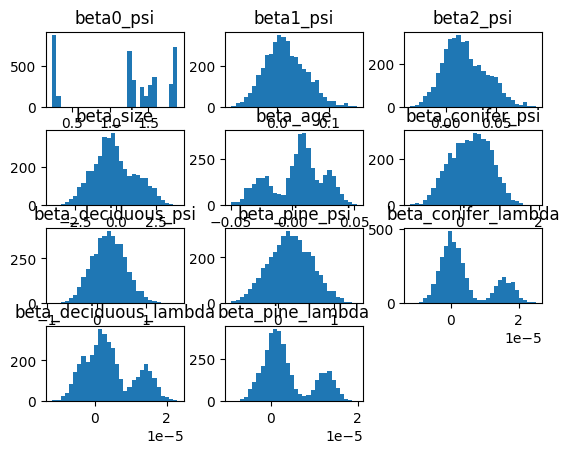

In [154]:
plt.tight_layout()
key_draws_post.hist(grid=False, bins=30)

##### Is a Poisson the best distribution?
This whole process, I've assumed that the mean and variance are equal. Here we'll check if a negative-binomial should be considered/.

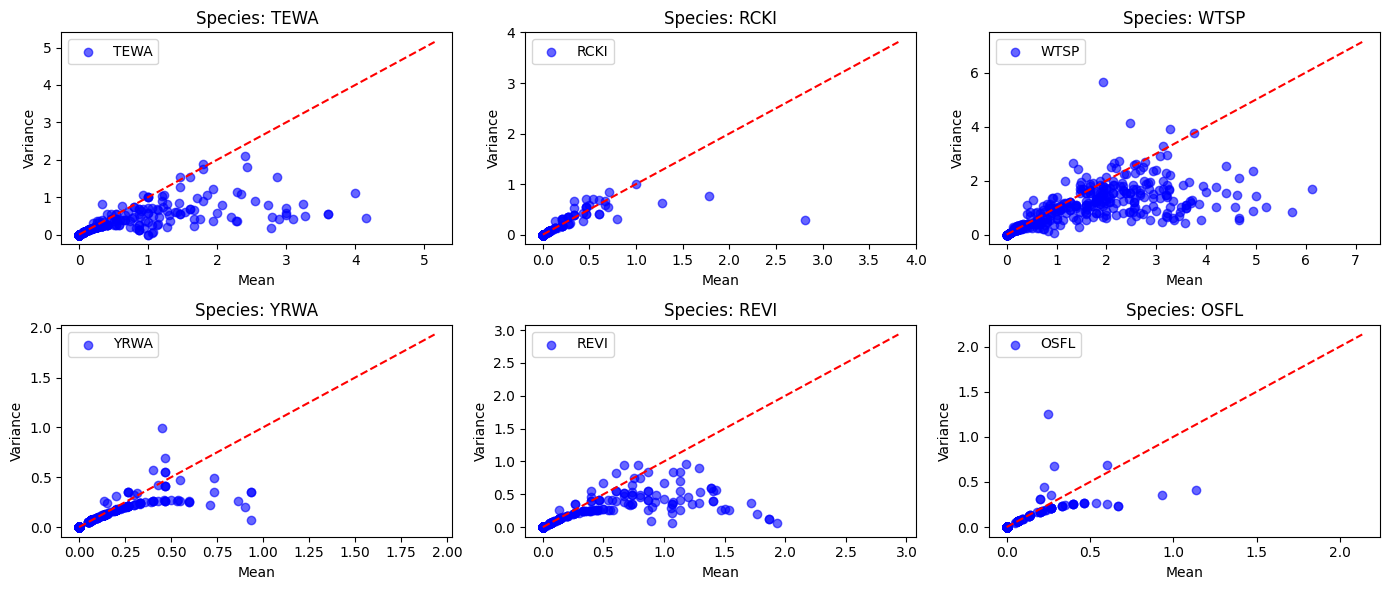

In [34]:
# Redoing the visualization using all sites, not just the overdispersed ones
species_columns = ['TEWA', 'RCKI', 'WTSP', 'YRWA', 'REVI', 'OSFL']

# Set up the figure and axes: 2 rows and 3 columns of subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 6))

# Flatten the 2D array of axes to iterate over it
axs = axs.flatten()

for ax, species in zip(axs, species_columns):
    grouped_species_data = counts.groupby(['location', 'recording_date_time'])[species].sum().reset_index()
    stats_data = grouped_species_data.groupby('location')[species].agg(['mean', 'var'])
    
    ax.scatter(stats_data['mean'], stats_data['var'], label=species, color='blue', alpha=0.6)
    ax.plot([0, stats_data['mean'].max() + 1], [0, stats_data['mean'].max() + 1], 'r--')  # Line where mean=variance
    ax.set_title(f"Species: {species}")
    ax.set_xlabel("Mean")
    ax.set_ylabel("Variance")
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'dispersion.png'))


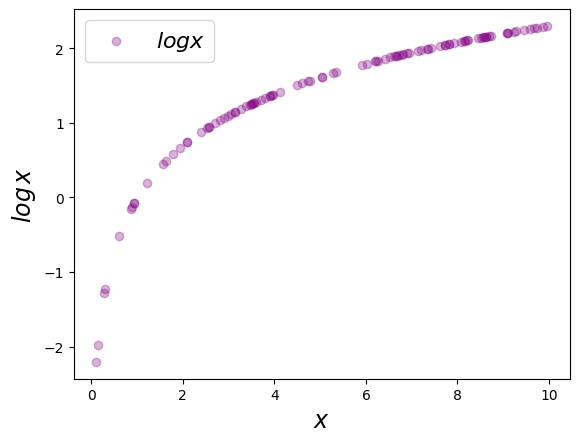

In [10]:
import random as rd
import math 
import matplotlib.pyplot as plt

random=[]
xlist = []
for i in range(100):
    x = rd.uniform(0,10)# choose numbers between 0 and 10 
    xlist.append(x)
    random.append(math.log(x))
plt.scatter(xlist, random, c='purple',alpha=0.3,label=r'$log x$')
plt.ylabel(r'$log \, x$', fontsize=17)
plt.xlabel(r'$x$',fontsize=17)
plt.legend(fontsize=16)
plt.show()

In [14]:
math.log(0.01)

-4.605170185988091

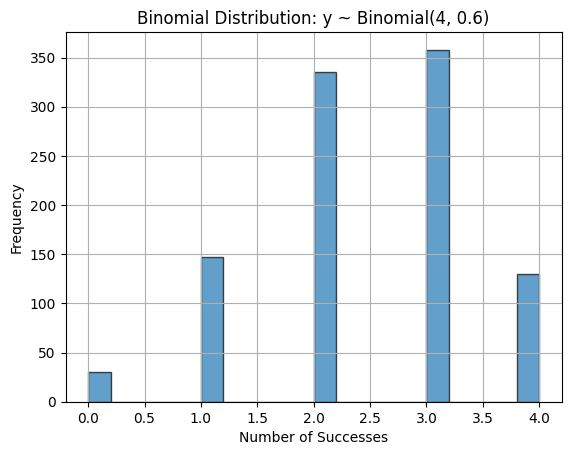

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating data for Binomial distribution
N = 4  # number of trials
p = 0.6  # probability of success
y = np.random.binomial(N, p, 1000)  # 1000 samples from the binomial distribution

# Plotting the distribution
plt.hist(y, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Successes')
plt.ylabel('Frequency')
plt.title(f'Binomial Distribution: y ~ Binomial({N}, {p})')
plt.grid(True)
plt.show()
